In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(488769, 828)
(488769, 8)
validation
(87055, 828)
(87055, 8)
test
(43409, 828)
(43409, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/49 [..............................] - ETA: 1:21 - loss: 2.2143 - STD: 0.0396 - MAE: 0.2219

 4/49 [=>............................] - ETA: 1s - loss: 1.6908 - STD: 0.1029 - MAE: 0.1860  

 5/49 [==>...........................] - ETA: 1s - loss: 1.6381 - STD: 0.1276 - MAE: 0.1761

 6/49 [==>...........................] - ETA: 1s - loss: 1.6066 - STD: 0.1464 - MAE: 0.1688

 7/49 [===>..........................] - ETA: 1s - loss: 1.5825 - STD: 0.1601 - MAE: 0.1633

 8/49 [===>..........................] - ETA: 1s - loss: 1.5605 - STD: 0.1696 - MAE: 0.1593

 9/49 [====>.........................] - ETA: 2s - loss: 1.5458 - STD: 0.1758 - MAE: 0.1569

10/49 [=====>........................] - ETA: 2s - loss: 1.5331 - STD: 0.1794 - MAE: 0.1554

11/49 [=====>........................] - ETA: 2s - loss: 1.5233 - STD: 0.1810 - MAE: 0.1547

12/49 [======>.......................] - ETA: 1s - loss: 1.5139 - STD: 0.1814 - MAE: 0.1544

13/49 [======>.......................] - ETA: 1s - loss: 1.5042 - STD: 0.1811 - MAE: 0.1544

14/49 [=======>......................] - ETA: 1s - loss: 1.4987 - STD: 0.1805 - MAE: 0.1546

15/49 [========>.....................] - ETA: 1s - loss: 1.4912 - STD: 0.1798 - MAE: 0.1548

16/49 [========>.....................] - ETA: 4s - loss: 1.4860 - STD: 0.1792 - MAE: 0.1549

19/49 [==========>...................] - ETA: 3s - loss: 1.4678 - STD: 0.1791 - MAE: 0.1546

21/49 [===========>..................] - ETA: 2s - loss: 1.4598 - STD: 0.1801 - MAE: 0.1541

22/49 [============>.................] - ETA: 2s - loss: 1.4559 - STD: 0.1807 - MAE: 0.1539

23/49 [=============>................] - ETA: 2s - loss: 1.4527 - STD: 0.1813 - MAE: 0.1536

24/49 [=============>................] - ETA: 2s - loss: 1.4496 - STD: 0.1819 - MAE: 0.1533

25/49 [==============>...............] - ETA: 2s - loss: 1.4469 - STD: 0.1823 - MAE: 0.1531

26/49 [==============>...............] - ETA: 2s - loss: 1.4439 - STD: 0.1826 - MAE: 0.1530

27/49 [===============>..............] - ETA: 2s - loss: 1.4413 - STD: 0.1828 - MAE: 0.1528

28/49 [================>.............] - ETA: 1s - loss: 1.4388 - STD: 0.1829 - MAE: 0.1528

29/49 [================>.............] - ETA: 1s - loss: 1.4367 - STD: 0.1828 - MAE: 0.1528

30/49 [=================>............] - ETA: 1s - loss: 1.4342 - STD: 0.1827 - MAE: 0.1528

31/49 [=================>............] - ETA: 1s - loss: 1.4326 - STD: 0.1825 - MAE: 0.1528

32/49 [==================>...........] - ETA: 1s - loss: 1.4311 - STD: 0.1823 - MAE: 0.1529

33/49 [===================>..........] - ETA: 1s - loss: 1.4295 - STD: 0.1821 - MAE: 0.1530

34/49 [===================>..........] - ETA: 1s - loss: 1.4276 - STD: 0.1819 - MAE: 0.1530

35/49 [====================>.........] - ETA: 1s - loss: 1.4261 - STD: 0.1818 - MAE: 0.1530

36/49 [=====================>........] - ETA: 1s - loss: 1.4245 - STD: 0.1817 - MAE: 0.1530

37/49 [=====================>........] - ETA: 1s - loss: 1.4229 - STD: 0.1817 - MAE: 0.1530

38/49 [======================>.......] - ETA: 0s - loss: 1.4212 - STD: 0.1818 - MAE: 0.1530

39/49 [======================>.......] - ETA: 0s - loss: 1.4200 - STD: 0.1819 - MAE: 0.1529

40/49 [=======================>......] - ETA: 0s - loss: 1.4185 - STD: 0.1821 - MAE: 0.1528

41/49 [========================>.....] - ETA: 0s - loss: 1.4172 - STD: 0.1822 - MAE: 0.1527

42/49 [========================>.....] - ETA: 0s - loss: 1.4159 - STD: 0.1824 - MAE: 0.1526

43/49 [=========================>....] - ETA: 0s - loss: 1.4146 - STD: 0.1826 - MAE: 0.1525

44/49 [=========================>....] - ETA: 0s - loss: 1.4134 - STD: 0.1827 - MAE: 0.1525

45/49 [==========================>...] - ETA: 0s - loss: 1.4128 - STD: 0.1828 - MAE: 0.1524

46/49 [===========================>..] - ETA: 0s - loss: 1.4119 - STD: 0.1829 - MAE: 0.1524

47/49 [===========================>..] - ETA: 0s - loss: 1.4107 - STD: 0.1830 - MAE: 0.1523

48/49 [============================>.] - ETA: 0s - loss: 1.4098 - STD: 0.1830 - MAE: 0.1523

49/49 [==============================] - ETA: 0s - loss: 1.4091 - STD: 0.1829 - MAE: 0.1523

49/49 [==============================] - 6s 97ms/step - loss: 1.4091 - STD: 0.1829 - MAE: 0.1523 - val_loss: 1.3811 - val_STD: 0.1807 - val_MAE: 0.1535


Epoch 2/10000


 1/49 [..............................] - ETA: 4s - loss: 1.3638 - STD: 0.1807 - MAE: 0.1525

 2/49 [>.............................] - ETA: 3s - loss: 1.3637 - STD: 0.1803 - MAE: 0.1526

 3/49 [>.............................] - ETA: 3s - loss: 1.3635 - STD: 0.1800 - MAE: 0.1527

 4/49 [=>............................] - ETA: 2s - loss: 1.3642 - STD: 0.1799 - MAE: 0.1527

 5/49 [==>...........................] - ETA: 2s - loss: 1.3622 - STD: 0.1799 - MAE: 0.1526

 6/49 [==>...........................] - ETA: 2s - loss: 1.3585 - STD: 0.1801 - MAE: 0.1522

 7/49 [===>..........................] - ETA: 2s - loss: 1.3610 - STD: 0.1805 - MAE: 0.1523

 8/49 [===>..........................] - ETA: 2s - loss: 1.3637 - STD: 0.1810 - MAE: 0.1522

 9/49 [====>.........................] - ETA: 2s - loss: 1.3637 - STD: 0.1814 - MAE: 0.1521

10/49 [=====>........................] - ETA: 2s - loss: 1.3620 - STD: 0.1818 - MAE: 0.1518

11/49 [=====>........................] - ETA: 2s - loss: 1.3628 - STD: 0.1821 - MAE: 0.1517

12/49 [======>.......................] - ETA: 2s - loss: 1.3621 - STD: 0.1824 - MAE: 0.1516

13/49 [======>.......................] - ETA: 2s - loss: 1.3632 - STD: 0.1826 - MAE: 0.1516

14/49 [=======>......................] - ETA: 2s - loss: 1.3621 - STD: 0.1827 - MAE: 0.1515

15/49 [========>.....................] - ETA: 2s - loss: 1.3622 - STD: 0.1827 - MAE: 0.1515

16/49 [========>.....................] - ETA: 2s - loss: 1.3633 - STD: 0.1828 - MAE: 0.1515

17/49 [=========>....................] - ETA: 2s - loss: 1.3641 - STD: 0.1827 - MAE: 0.1516

18/49 [==========>...................] - ETA: 1s - loss: 1.3642 - STD: 0.1827 - MAE: 0.1516

19/49 [==========>...................] - ETA: 1s - loss: 1.3647 - STD: 0.1827 - MAE: 0.1517

20/49 [===========>..................] - ETA: 1s - loss: 1.3648 - STD: 0.1826 - MAE: 0.1517

21/49 [===========>..................] - ETA: 1s - loss: 1.3651 - STD: 0.1826 - MAE: 0.1517

22/49 [============>.................] - ETA: 1s - loss: 1.3651 - STD: 0.1826 - MAE: 0.1517

23/49 [=============>................] - ETA: 1s - loss: 1.3652 - STD: 0.1827 - MAE: 0.1516

24/49 [=============>................] - ETA: 1s - loss: 1.3654 - STD: 0.1828 - MAE: 0.1516

25/49 [==============>...............] - ETA: 1s - loss: 1.3651 - STD: 0.1828 - MAE: 0.1516

26/49 [==============>...............] - ETA: 1s - loss: 1.3657 - STD: 0.1829 - MAE: 0.1516

27/49 [===============>..............] - ETA: 1s - loss: 1.3662 - STD: 0.1830 - MAE: 0.1516

28/49 [================>.............] - ETA: 1s - loss: 1.3661 - STD: 0.1830 - MAE: 0.1515

29/49 [================>.............] - ETA: 1s - loss: 1.3660 - STD: 0.1831 - MAE: 0.1515

30/49 [=================>............] - ETA: 1s - loss: 1.3659 - STD: 0.1830 - MAE: 0.1516

31/49 [=================>............] - ETA: 1s - loss: 1.3658 - STD: 0.1830 - MAE: 0.1516

32/49 [==================>...........] - ETA: 1s - loss: 1.3662 - STD: 0.1829 - MAE: 0.1516

33/49 [===================>..........] - ETA: 1s - loss: 1.3656 - STD: 0.1829 - MAE: 0.1516

34/49 [===================>..........] - ETA: 0s - loss: 1.3658 - STD: 0.1828 - MAE: 0.1516

35/49 [====================>.........] - ETA: 0s - loss: 1.3657 - STD: 0.1828 - MAE: 0.1516

36/49 [=====================>........] - ETA: 0s - loss: 1.3657 - STD: 0.1828 - MAE: 0.1516

37/49 [=====================>........] - ETA: 0s - loss: 1.3659 - STD: 0.1828 - MAE: 0.1516

38/49 [======================>.......] - ETA: 0s - loss: 1.3661 - STD: 0.1828 - MAE: 0.1516

39/49 [======================>.......] - ETA: 0s - loss: 1.3662 - STD: 0.1828 - MAE: 0.1516

40/49 [=======================>......] - ETA: 0s - loss: 1.3658 - STD: 0.1828 - MAE: 0.1516

41/49 [========================>.....] - ETA: 0s - loss: 1.3658 - STD: 0.1828 - MAE: 0.1516

42/49 [========================>.....] - ETA: 0s - loss: 1.3654 - STD: 0.1828 - MAE: 0.1516

43/49 [=========================>....] - ETA: 0s - loss: 1.3651 - STD: 0.1828 - MAE: 0.1516

44/49 [=========================>....] - ETA: 0s - loss: 1.3647 - STD: 0.1829 - MAE: 0.1515

45/49 [==========================>...] - ETA: 0s - loss: 1.3642 - STD: 0.1829 - MAE: 0.1515

46/49 [===========================>..] - ETA: 0s - loss: 1.3641 - STD: 0.1829 - MAE: 0.1515

47/49 [===========================>..] - ETA: 0s - loss: 1.3641 - STD: 0.1830 - MAE: 0.1515

48/49 [============================>.] - ETA: 0s - loss: 1.3641 - STD: 0.1830 - MAE: 0.1514

49/49 [==============================] - ETA: 0s - loss: 1.3641 - STD: 0.1830 - MAE: 0.1514

49/49 [==============================] - 3s 69ms/step - loss: 1.3641 - STD: 0.1830 - MAE: 0.1514 - val_loss: 1.3633 - val_STD: 0.1817 - val_MAE: 0.1519


Epoch 3/10000


 1/49 [..............................] - ETA: 5s - loss: 1.3641 - STD: 0.1817 - MAE: 0.1517

 2/49 [>.............................] - ETA: 3s - loss: 1.3556 - STD: 0.1810 - MAE: 0.1515

 3/49 [>.............................] - ETA: 3s - loss: 1.3527 - STD: 0.1807 - MAE: 0.1514

 4/49 [=>............................] - ETA: 2s - loss: 1.3448 - STD: 0.1809 - MAE: 0.1509

 5/49 [==>...........................] - ETA: 2s - loss: 1.3421 - STD: 0.1815 - MAE: 0.1506

 6/49 [==>...........................] - ETA: 2s - loss: 1.3404 - STD: 0.1823 - MAE: 0.1502

 7/49 [===>..........................] - ETA: 2s - loss: 1.3405 - STD: 0.1829 - MAE: 0.1499

 8/49 [===>..........................] - ETA: 2s - loss: 1.3416 - STD: 0.1834 - MAE: 0.1498

 9/49 [====>.........................] - ETA: 2s - loss: 1.3420 - STD: 0.1835 - MAE: 0.1498

10/49 [=====>........................] - ETA: 2s - loss: 1.3420 - STD: 0.1834 - MAE: 0.1499

11/49 [=====>........................] - ETA: 2s - loss: 1.3431 - STD: 0.1831 - MAE: 0.1500

12/49 [======>.......................] - ETA: 2s - loss: 1.3413 - STD: 0.1828 - MAE: 0.1500

13/49 [======>.......................] - ETA: 2s - loss: 1.3396 - STD: 0.1828 - MAE: 0.1499

14/49 [=======>......................] - ETA: 2s - loss: 1.3385 - STD: 0.1831 - MAE: 0.1497

15/49 [========>.....................] - ETA: 2s - loss: 1.3378 - STD: 0.1835 - MAE: 0.1495

16/49 [========>.....................] - ETA: 2s - loss: 1.3359 - STD: 0.1838 - MAE: 0.1492

17/49 [=========>....................] - ETA: 2s - loss: 1.3346 - STD: 0.1840 - MAE: 0.1491

18/49 [==========>...................] - ETA: 1s - loss: 1.3333 - STD: 0.1839 - MAE: 0.1491

19/49 [==========>...................] - ETA: 1s - loss: 1.3316 - STD: 0.1838 - MAE: 0.1490

20/49 [===========>..................] - ETA: 1s - loss: 1.3319 - STD: 0.1838 - MAE: 0.1490

21/49 [===========>..................] - ETA: 1s - loss: 1.3307 - STD: 0.1839 - MAE: 0.1489

22/49 [============>.................] - ETA: 1s - loss: 1.3300 - STD: 0.1840 - MAE: 0.1488

23/49 [=============>................] - ETA: 1s - loss: 1.3290 - STD: 0.1842 - MAE: 0.1487

24/49 [=============>................] - ETA: 1s - loss: 1.3279 - STD: 0.1845 - MAE: 0.1485

25/49 [==============>...............] - ETA: 1s - loss: 1.3262 - STD: 0.1847 - MAE: 0.1483

26/49 [==============>...............] - ETA: 1s - loss: 1.3255 - STD: 0.1850 - MAE: 0.1482

27/49 [===============>..............] - ETA: 1s - loss: 1.3242 - STD: 0.1851 - MAE: 0.1480

28/49 [================>.............] - ETA: 1s - loss: 1.3228 - STD: 0.1853 - MAE: 0.1479

29/49 [================>.............] - ETA: 1s - loss: 1.3218 - STD: 0.1856 - MAE: 0.1477

30/49 [=================>............] - ETA: 1s - loss: 1.3209 - STD: 0.1858 - MAE: 0.1476

31/49 [=================>............] - ETA: 1s - loss: 1.3194 - STD: 0.1859 - MAE: 0.1475

32/49 [==================>...........] - ETA: 1s - loss: 1.3182 - STD: 0.1860 - MAE: 0.1473

33/49 [===================>..........] - ETA: 1s - loss: 1.3169 - STD: 0.1863 - MAE: 0.1471

34/49 [===================>..........] - ETA: 0s - loss: 1.3154 - STD: 0.1866 - MAE: 0.1469

35/49 [====================>.........] - ETA: 0s - loss: 1.3147 - STD: 0.1867 - MAE: 0.1468

36/49 [=====================>........] - ETA: 0s - loss: 1.3133 - STD: 0.1868 - MAE: 0.1467

37/49 [=====================>........] - ETA: 0s - loss: 1.3115 - STD: 0.1870 - MAE: 0.1466

38/49 [======================>.......] - ETA: 0s - loss: 1.3100 - STD: 0.1873 - MAE: 0.1464

39/49 [======================>.......] - ETA: 0s - loss: 1.3096 - STD: 0.1876 - MAE: 0.1462

40/49 [=======================>......] - ETA: 0s - loss: 1.3085 - STD: 0.1876 - MAE: 0.1462

41/49 [========================>.....] - ETA: 0s - loss: 1.3075 - STD: 0.1876 - MAE: 0.1461

42/49 [========================>.....] - ETA: 0s - loss: 1.3065 - STD: 0.1880 - MAE: 0.1459

43/49 [=========================>....] - ETA: 0s - loss: 1.3057 - STD: 0.1884 - MAE: 0.1457

44/49 [=========================>....] - ETA: 0s - loss: 1.3045 - STD: 0.1885 - MAE: 0.1456

45/49 [==========================>...] - ETA: 0s - loss: 1.3033 - STD: 0.1885 - MAE: 0.1455

46/49 [===========================>..] - ETA: 0s - loss: 1.3028 - STD: 0.1888 - MAE: 0.1453

47/49 [===========================>..] - ETA: 0s - loss: 1.3019 - STD: 0.1892 - MAE: 0.1451

48/49 [============================>.] - ETA: 0s - loss: 1.3008 - STD: 0.1893 - MAE: 0.1450

49/49 [==============================] - ETA: 0s - loss: 1.3000 - STD: 0.1894 - MAE: 0.1449

49/49 [==============================] - 3s 69ms/step - loss: 1.3000 - STD: 0.1894 - MAE: 0.1449 - val_loss: 1.2665 - val_STD: 0.1848 - val_MAE: 0.1433


Epoch 4/10000


 1/49 [..............................] - ETA: 4s - loss: 1.2662 - STD: 0.1967 - MAE: 0.1399

 2/49 [>.............................] - ETA: 3s - loss: 1.2537 - STD: 0.1986 - MAE: 0.1386

 3/49 [>.............................] - ETA: 3s - loss: 1.2524 - STD: 0.1993 - MAE: 0.1383

 4/49 [=>............................] - ETA: 2s - loss: 1.2531 - STD: 0.1991 - MAE: 0.1384

 5/49 [==>...........................] - ETA: 2s - loss: 1.2557 - STD: 0.1986 - MAE: 0.1388

 6/49 [==>...........................] - ETA: 2s - loss: 1.2525 - STD: 0.1982 - MAE: 0.1388

 7/49 [===>..........................] - ETA: 2s - loss: 1.2515 - STD: 0.1991 - MAE: 0.1383

 8/49 [===>..........................] - ETA: 2s - loss: 1.2510 - STD: 0.1990 - MAE: 0.1383

 9/49 [====>.........................] - ETA: 2s - loss: 1.2500 - STD: 0.1985 - MAE: 0.1385

10/49 [=====>........................] - ETA: 2s - loss: 1.2486 - STD: 0.1992 - MAE: 0.1381

11/49 [=====>........................] - ETA: 2s - loss: 1.2477 - STD: 0.1990 - MAE: 0.1382

12/49 [======>.......................] - ETA: 2s - loss: 1.2469 - STD: 0.1990 - MAE: 0.1381

13/49 [======>.......................] - ETA: 2s - loss: 1.2470 - STD: 0.1995 - MAE: 0.1379

14/49 [=======>......................] - ETA: 2s - loss: 1.2463 - STD: 0.1986 - MAE: 0.1382

15/49 [========>.....................] - ETA: 2s - loss: 1.2447 - STD: 0.1995 - MAE: 0.1378

16/49 [========>.....................] - ETA: 2s - loss: 1.2445 - STD: 0.1998 - MAE: 0.1377

17/49 [=========>....................] - ETA: 2s - loss: 1.2435 - STD: 0.1989 - MAE: 0.1380

18/49 [==========>...................] - ETA: 1s - loss: 1.2425 - STD: 0.1997 - MAE: 0.1376

19/49 [==========>...................] - ETA: 1s - loss: 1.2418 - STD: 0.2003 - MAE: 0.1373

20/49 [===========>..................] - ETA: 1s - loss: 1.2410 - STD: 0.1995 - MAE: 0.1376

21/49 [===========>..................] - ETA: 1s - loss: 1.2407 - STD: 0.1998 - MAE: 0.1375

22/49 [============>.................] - ETA: 1s - loss: 1.2411 - STD: 0.2007 - MAE: 0.1371

23/49 [=============>................] - ETA: 1s - loss: 1.2414 - STD: 0.2000 - MAE: 0.1374

24/49 [=============>................] - ETA: 1s - loss: 1.2413 - STD: 0.1996 - MAE: 0.1376

25/49 [==============>...............] - ETA: 1s - loss: 1.2413 - STD: 0.2002 - MAE: 0.1373

26/49 [==============>...............] - ETA: 1s - loss: 1.2412 - STD: 0.2006 - MAE: 0.1371

27/49 [===============>..............] - ETA: 1s - loss: 1.2400 - STD: 0.2002 - MAE: 0.1372

28/49 [================>.............] - ETA: 1s - loss: 1.2392 - STD: 0.2001 - MAE: 0.1372

29/49 [================>.............] - ETA: 1s - loss: 1.2378 - STD: 0.2007 - MAE: 0.1369

30/49 [=================>............] - ETA: 1s - loss: 1.2370 - STD: 0.2010 - MAE: 0.1368

31/49 [=================>............] - ETA: 1s - loss: 1.2365 - STD: 0.2007 - MAE: 0.1369

32/49 [==================>...........] - ETA: 1s - loss: 1.2358 - STD: 0.2005 - MAE: 0.1369

33/49 [===================>..........] - ETA: 1s - loss: 1.2354 - STD: 0.2010 - MAE: 0.1367

34/49 [===================>..........] - ETA: 0s - loss: 1.2342 - STD: 0.2012 - MAE: 0.1366

35/49 [====================>.........] - ETA: 0s - loss: 1.2344 - STD: 0.2010 - MAE: 0.1366

36/49 [=====================>........] - ETA: 0s - loss: 1.2337 - STD: 0.2008 - MAE: 0.1367

37/49 [=====================>........] - ETA: 0s - loss: 1.2336 - STD: 0.2011 - MAE: 0.1366

38/49 [======================>.......] - ETA: 0s - loss: 1.2331 - STD: 0.2013 - MAE: 0.1365

39/49 [======================>.......] - ETA: 0s - loss: 1.2327 - STD: 0.2011 - MAE: 0.1366

40/49 [=======================>......] - ETA: 0s - loss: 1.2322 - STD: 0.2011 - MAE: 0.1365

41/49 [========================>.....] - ETA: 0s - loss: 1.2318 - STD: 0.2014 - MAE: 0.1364

42/49 [========================>.....] - ETA: 0s - loss: 1.2313 - STD: 0.2015 - MAE: 0.1364

43/49 [=========================>....] - ETA: 0s - loss: 1.2309 - STD: 0.2012 - MAE: 0.1364

44/49 [=========================>....] - ETA: 0s - loss: 1.2299 - STD: 0.2013 - MAE: 0.1364

45/49 [==========================>...] - ETA: 0s - loss: 1.2291 - STD: 0.2016 - MAE: 0.1362

46/49 [===========================>..] - ETA: 0s - loss: 1.2287 - STD: 0.2016 - MAE: 0.1362

47/49 [===========================>..] - ETA: 0s - loss: 1.2285 - STD: 0.2014 - MAE: 0.1363

48/49 [============================>.] - ETA: 0s - loss: 1.2279 - STD: 0.2014 - MAE: 0.1363

49/49 [==============================] - ETA: 0s - loss: 1.2268 - STD: 0.2016 - MAE: 0.1361

49/49 [==============================] - 3s 69ms/step - loss: 1.2268 - STD: 0.2016 - MAE: 0.1361 - val_loss: 1.1964 - val_STD: 0.1988 - val_MAE: 0.1349


Epoch 5/10000


 1/49 [..............................] - ETA: 4s - loss: 1.1973 - STD: 0.2080 - MAE: 0.1328

 2/49 [>.............................] - ETA: 3s - loss: 1.1957 - STD: 0.2016 - MAE: 0.1351

 3/49 [>.............................] - ETA: 3s - loss: 1.1932 - STD: 0.2012 - MAE: 0.1352

 4/49 [=>............................] - ETA: 2s - loss: 1.1938 - STD: 0.2038 - MAE: 0.1341

 5/49 [==>...........................] - ETA: 2s - loss: 1.1911 - STD: 0.2045 - MAE: 0.1338

 6/49 [==>...........................] - ETA: 2s - loss: 1.1892 - STD: 0.2039 - MAE: 0.1339

 7/49 [===>..........................] - ETA: 2s - loss: 1.1884 - STD: 0.2039 - MAE: 0.1339

 8/49 [===>..........................] - ETA: 2s - loss: 1.1871 - STD: 0.2041 - MAE: 0.1338

 9/49 [====>.........................] - ETA: 2s - loss: 1.1870 - STD: 0.2043 - MAE: 0.1337

10/49 [=====>........................] - ETA: 2s - loss: 1.1851 - STD: 0.2041 - MAE: 0.1337

11/49 [=====>........................] - ETA: 2s - loss: 1.1839 - STD: 0.2042 - MAE: 0.1336

12/49 [======>.......................] - ETA: 2s - loss: 1.1812 - STD: 0.2044 - MAE: 0.1334

13/49 [======>.......................] - ETA: 2s - loss: 1.1785 - STD: 0.2042 - MAE: 0.1334

14/49 [=======>......................] - ETA: 2s - loss: 1.1771 - STD: 0.2046 - MAE: 0.1332

15/49 [========>.....................] - ETA: 2s - loss: 1.1757 - STD: 0.2047 - MAE: 0.1331

16/49 [========>.....................] - ETA: 2s - loss: 1.1747 - STD: 0.2046 - MAE: 0.1331

17/49 [=========>....................] - ETA: 2s - loss: 1.1743 - STD: 0.2047 - MAE: 0.1331

18/49 [==========>...................] - ETA: 1s - loss: 1.1736 - STD: 0.2049 - MAE: 0.1330

19/49 [==========>...................] - ETA: 1s - loss: 1.1718 - STD: 0.2047 - MAE: 0.1330

20/49 [===========>..................] - ETA: 1s - loss: 1.1709 - STD: 0.2051 - MAE: 0.1328

21/49 [===========>..................] - ETA: 1s - loss: 1.1698 - STD: 0.2050 - MAE: 0.1328

22/49 [============>.................] - ETA: 1s - loss: 1.1688 - STD: 0.2049 - MAE: 0.1328

23/49 [=============>................] - ETA: 1s - loss: 1.1676 - STD: 0.2050 - MAE: 0.1327

24/49 [=============>................] - ETA: 1s - loss: 1.1663 - STD: 0.2052 - MAE: 0.1327

25/49 [==============>...............] - ETA: 1s - loss: 1.1650 - STD: 0.2051 - MAE: 0.1326

26/49 [==============>...............] - ETA: 1s - loss: 1.1634 - STD: 0.2052 - MAE: 0.1326

27/49 [===============>..............] - ETA: 1s - loss: 1.1632 - STD: 0.2055 - MAE: 0.1325

28/49 [================>.............] - ETA: 1s - loss: 1.1616 - STD: 0.2055 - MAE: 0.1324

29/49 [================>.............] - ETA: 1s - loss: 1.1603 - STD: 0.2057 - MAE: 0.1322

30/49 [=================>............] - ETA: 1s - loss: 1.1591 - STD: 0.2060 - MAE: 0.1321

31/49 [=================>............] - ETA: 1s - loss: 1.1580 - STD: 0.2060 - MAE: 0.1321

32/49 [==================>...........] - ETA: 1s - loss: 1.1571 - STD: 0.2060 - MAE: 0.1321

33/49 [===================>..........] - ETA: 1s - loss: 1.1558 - STD: 0.2062 - MAE: 0.1319

34/49 [===================>..........] - ETA: 0s - loss: 1.1543 - STD: 0.2063 - MAE: 0.1318

35/49 [====================>.........] - ETA: 0s - loss: 1.1534 - STD: 0.2065 - MAE: 0.1317

36/49 [=====================>........] - ETA: 0s - loss: 1.1521 - STD: 0.2065 - MAE: 0.1317

37/49 [=====================>........] - ETA: 0s - loss: 1.1511 - STD: 0.2066 - MAE: 0.1316

38/49 [======================>.......] - ETA: 0s - loss: 1.1504 - STD: 0.2068 - MAE: 0.1315

39/49 [======================>.......] - ETA: 0s - loss: 1.1497 - STD: 0.2069 - MAE: 0.1315

40/49 [=======================>......] - ETA: 0s - loss: 1.1490 - STD: 0.2068 - MAE: 0.1315

41/49 [========================>.....] - ETA: 0s - loss: 1.1480 - STD: 0.2071 - MAE: 0.1313

42/49 [========================>.....] - ETA: 0s - loss: 1.1473 - STD: 0.2072 - MAE: 0.1313

43/49 [=========================>....] - ETA: 0s - loss: 1.1467 - STD: 0.2071 - MAE: 0.1313

44/49 [=========================>....] - ETA: 0s - loss: 1.1456 - STD: 0.2071 - MAE: 0.1312

45/49 [==========================>...] - ETA: 0s - loss: 1.1450 - STD: 0.2074 - MAE: 0.1311

46/49 [===========================>..] - ETA: 0s - loss: 1.1444 - STD: 0.2074 - MAE: 0.1311

47/49 [===========================>..] - ETA: 0s - loss: 1.1436 - STD: 0.2073 - MAE: 0.1311

48/49 [============================>.] - ETA: 0s - loss: 1.1427 - STD: 0.2075 - MAE: 0.1310

49/49 [==============================] - ETA: 0s - loss: 1.1418 - STD: 0.2076 - MAE: 0.1309

49/49 [==============================] - 3s 68ms/step - loss: 1.1418 - STD: 0.2076 - MAE: 0.1309 - val_loss: 1.1636 - val_STD: 0.1988 - val_MAE: 0.1351


Epoch 6/10000


 1/49 [..............................] - ETA: 4s - loss: 1.0863 - STD: 0.2069 - MAE: 0.1293

 2/49 [>.............................] - ETA: 2s - loss: 1.1010 - STD: 0.2112 - MAE: 0.1282

 3/49 [>.............................] - ETA: 2s - loss: 1.0995 - STD: 0.2113 - MAE: 0.1281

 4/49 [=>............................] - ETA: 2s - loss: 1.1023 - STD: 0.2102 - MAE: 0.1288

 5/49 [==>...........................] - ETA: 2s - loss: 1.0992 - STD: 0.2104 - MAE: 0.1286

 6/49 [==>...........................] - ETA: 2s - loss: 1.0967 - STD: 0.2114 - MAE: 0.1280

 7/49 [===>..........................] - ETA: 2s - loss: 1.0973 - STD: 0.2113 - MAE: 0.1281

 8/49 [===>..........................] - ETA: 2s - loss: 1.0975 - STD: 0.2109 - MAE: 0.1283

 9/49 [====>.........................] - ETA: 2s - loss: 1.0983 - STD: 0.2111 - MAE: 0.1283

10/49 [=====>........................] - ETA: 2s - loss: 1.0990 - STD: 0.2110 - MAE: 0.1284

11/49 [=====>........................] - ETA: 2s - loss: 1.0973 - STD: 0.2106 - MAE: 0.1285

12/49 [======>.......................] - ETA: 2s - loss: 1.0982 - STD: 0.2115 - MAE: 0.1282

13/49 [======>.......................] - ETA: 2s - loss: 1.0974 - STD: 0.2109 - MAE: 0.1284

14/49 [=======>......................] - ETA: 2s - loss: 1.0972 - STD: 0.2110 - MAE: 0.1283

15/49 [========>.....................] - ETA: 2s - loss: 1.0971 - STD: 0.2114 - MAE: 0.1282

16/49 [========>.....................] - ETA: 2s - loss: 1.0965 - STD: 0.2111 - MAE: 0.1283

17/49 [=========>....................] - ETA: 2s - loss: 1.0956 - STD: 0.2108 - MAE: 0.1284

18/49 [==========>...................] - ETA: 1s - loss: 1.0944 - STD: 0.2112 - MAE: 0.1282

19/49 [==========>...................] - ETA: 1s - loss: 1.0938 - STD: 0.2115 - MAE: 0.1281

20/49 [===========>..................] - ETA: 1s - loss: 1.0940 - STD: 0.2111 - MAE: 0.1282

21/49 [===========>..................] - ETA: 1s - loss: 1.0935 - STD: 0.2111 - MAE: 0.1282

22/49 [============>.................] - ETA: 1s - loss: 1.0941 - STD: 0.2115 - MAE: 0.1281

23/49 [=============>................] - ETA: 1s - loss: 1.0932 - STD: 0.2115 - MAE: 0.1281

24/49 [=============>................] - ETA: 1s - loss: 1.0933 - STD: 0.2113 - MAE: 0.1282

25/49 [==============>...............] - ETA: 1s - loss: 1.0918 - STD: 0.2113 - MAE: 0.1281

26/49 [==============>...............] - ETA: 1s - loss: 1.0914 - STD: 0.2117 - MAE: 0.1279

27/49 [===============>..............] - ETA: 1s - loss: 1.0906 - STD: 0.2117 - MAE: 0.1279

28/49 [================>.............] - ETA: 1s - loss: 1.0902 - STD: 0.2114 - MAE: 0.1281

29/49 [================>.............] - ETA: 1s - loss: 1.0898 - STD: 0.2115 - MAE: 0.1280

30/49 [=================>............] - ETA: 1s - loss: 1.0900 - STD: 0.2118 - MAE: 0.1279

31/49 [=================>............] - ETA: 1s - loss: 1.0895 - STD: 0.2117 - MAE: 0.1279

32/49 [==================>...........] - ETA: 1s - loss: 1.0901 - STD: 0.2114 - MAE: 0.1281

33/49 [===================>..........] - ETA: 1s - loss: 1.0897 - STD: 0.2115 - MAE: 0.1280

34/49 [===================>..........] - ETA: 0s - loss: 1.0892 - STD: 0.2118 - MAE: 0.1279

35/49 [====================>.........] - ETA: 0s - loss: 1.0886 - STD: 0.2118 - MAE: 0.1279

36/49 [=====================>........] - ETA: 0s - loss: 1.0881 - STD: 0.2116 - MAE: 0.1279

37/49 [=====================>........] - ETA: 0s - loss: 1.0875 - STD: 0.2116 - MAE: 0.1279

38/49 [======================>.......] - ETA: 0s - loss: 1.0868 - STD: 0.2118 - MAE: 0.1278

39/49 [======================>.......] - ETA: 0s - loss: 1.0865 - STD: 0.2119 - MAE: 0.1277

40/49 [=======================>......] - ETA: 0s - loss: 1.0855 - STD: 0.2118 - MAE: 0.1278

41/49 [========================>.....] - ETA: 0s - loss: 1.0847 - STD: 0.2119 - MAE: 0.1277

42/49 [========================>.....] - ETA: 0s - loss: 1.0844 - STD: 0.2121 - MAE: 0.1276

43/49 [=========================>....] - ETA: 0s - loss: 1.0836 - STD: 0.2120 - MAE: 0.1276

44/49 [=========================>....] - ETA: 0s - loss: 1.0834 - STD: 0.2120 - MAE: 0.1276

45/49 [==========================>...] - ETA: 0s - loss: 1.0828 - STD: 0.2121 - MAE: 0.1275

46/49 [===========================>..] - ETA: 0s - loss: 1.0822 - STD: 0.2122 - MAE: 0.1275

47/49 [===========================>..] - ETA: 0s - loss: 1.0818 - STD: 0.2123 - MAE: 0.1274

48/49 [============================>.] - ETA: 0s - loss: 1.0811 - STD: 0.2122 - MAE: 0.1274

49/49 [==============================] - ETA: 0s - loss: 1.0803 - STD: 0.2124 - MAE: 0.1273

49/49 [==============================] - 3s 70ms/step - loss: 1.0803 - STD: 0.2124 - MAE: 0.1273 - val_loss: 1.1470 - val_STD: 0.2126 - val_MAE: 0.1292


Epoch 7/10000


 1/49 [..............................] - ETA: 4s - loss: 1.0591 - STD: 0.2183 - MAE: 0.1239

 2/49 [>.............................] - ETA: 3s - loss: 1.0552 - STD: 0.2139 - MAE: 0.1254

 3/49 [>.............................] - ETA: 2s - loss: 1.0526 - STD: 0.2157 - MAE: 0.1246

 4/49 [=>............................] - ETA: 2s - loss: 1.0570 - STD: 0.2167 - MAE: 0.1245

 5/49 [==>...........................] - ETA: 2s - loss: 1.0639 - STD: 0.2143 - MAE: 0.1258

 6/49 [==>...........................] - ETA: 2s - loss: 1.0650 - STD: 0.2134 - MAE: 0.1263

 7/49 [===>..........................] - ETA: 2s - loss: 1.0656 - STD: 0.2134 - MAE: 0.1264

 8/49 [===>..........................] - ETA: 2s - loss: 1.0660 - STD: 0.2134 - MAE: 0.1264

 9/49 [====>.........................] - ETA: 2s - loss: 1.0624 - STD: 0.2136 - MAE: 0.1262

10/49 [=====>........................] - ETA: 2s - loss: 1.0618 - STD: 0.2136 - MAE: 0.1262

11/49 [=====>........................] - ETA: 2s - loss: 1.0598 - STD: 0.2136 - MAE: 0.1261

12/49 [======>.......................] - ETA: 2s - loss: 1.0582 - STD: 0.2140 - MAE: 0.1258

13/49 [======>.......................] - ETA: 2s - loss: 1.0572 - STD: 0.2145 - MAE: 0.1256

14/49 [=======>......................] - ETA: 2s - loss: 1.0551 - STD: 0.2142 - MAE: 0.1256

15/49 [========>.....................] - ETA: 2s - loss: 1.0544 - STD: 0.2142 - MAE: 0.1256

16/49 [========>.....................] - ETA: 2s - loss: 1.0529 - STD: 0.2146 - MAE: 0.1254

17/49 [=========>....................] - ETA: 2s - loss: 1.0510 - STD: 0.2147 - MAE: 0.1253

18/49 [==========>...................] - ETA: 1s - loss: 1.0509 - STD: 0.2146 - MAE: 0.1253

19/49 [==========>...................] - ETA: 1s - loss: 1.0500 - STD: 0.2145 - MAE: 0.1253

20/49 [===========>..................] - ETA: 1s - loss: 1.0501 - STD: 0.2146 - MAE: 0.1253

21/49 [===========>..................] - ETA: 1s - loss: 1.0493 - STD: 0.2145 - MAE: 0.1253

22/49 [============>.................] - ETA: 1s - loss: 1.0487 - STD: 0.2144 - MAE: 0.1254

23/49 [=============>................] - ETA: 1s - loss: 1.0486 - STD: 0.2147 - MAE: 0.1252

24/49 [=============>................] - ETA: 1s - loss: 1.0486 - STD: 0.2147 - MAE: 0.1252

25/49 [==============>...............] - ETA: 1s - loss: 1.0479 - STD: 0.2144 - MAE: 0.1253

26/49 [==============>...............] - ETA: 1s - loss: 1.0475 - STD: 0.2145 - MAE: 0.1253

27/49 [===============>..............] - ETA: 1s - loss: 1.0468 - STD: 0.2147 - MAE: 0.1252

28/49 [================>.............] - ETA: 1s - loss: 1.0462 - STD: 0.2147 - MAE: 0.1252

29/49 [================>.............] - ETA: 1s - loss: 1.0455 - STD: 0.2145 - MAE: 0.1252

30/49 [=================>............] - ETA: 1s - loss: 1.0445 - STD: 0.2147 - MAE: 0.1251

31/49 [=================>............] - ETA: 1s - loss: 1.0439 - STD: 0.2149 - MAE: 0.1250

32/49 [==================>...........] - ETA: 1s - loss: 1.0427 - STD: 0.2147 - MAE: 0.1251

33/49 [===================>..........] - ETA: 1s - loss: 1.0424 - STD: 0.2147 - MAE: 0.1251

34/49 [===================>..........] - ETA: 0s - loss: 1.0417 - STD: 0.2148 - MAE: 0.1250

35/49 [====================>.........] - ETA: 0s - loss: 1.0408 - STD: 0.2148 - MAE: 0.1249

36/49 [=====================>........] - ETA: 0s - loss: 1.0400 - STD: 0.2149 - MAE: 0.1249

37/49 [=====================>........] - ETA: 0s - loss: 1.0395 - STD: 0.2149 - MAE: 0.1249

38/49 [======================>.......] - ETA: 0s - loss: 1.0387 - STD: 0.2149 - MAE: 0.1249

39/49 [======================>.......] - ETA: 0s - loss: 1.0378 - STD: 0.2150 - MAE: 0.1248

40/49 [=======================>......] - ETA: 0s - loss: 1.0370 - STD: 0.2150 - MAE: 0.1247

41/49 [========================>.....] - ETA: 0s - loss: 1.0363 - STD: 0.2150 - MAE: 0.1247

42/49 [========================>.....] - ETA: 0s - loss: 1.0355 - STD: 0.2150 - MAE: 0.1247

43/49 [=========================>....] - ETA: 0s - loss: 1.0349 - STD: 0.2150 - MAE: 0.1247

44/49 [=========================>....] - ETA: 0s - loss: 1.0342 - STD: 0.2151 - MAE: 0.1246

45/49 [==========================>...] - ETA: 0s - loss: 1.0332 - STD: 0.2151 - MAE: 0.1245

46/49 [===========================>..] - ETA: 0s - loss: 1.0323 - STD: 0.2152 - MAE: 0.1245

47/49 [===========================>..] - ETA: 0s - loss: 1.0320 - STD: 0.2153 - MAE: 0.1244

48/49 [============================>.] - ETA: 0s - loss: 1.0312 - STD: 0.2153 - MAE: 0.1244

49/49 [==============================] - ETA: 0s - loss: 1.0304 - STD: 0.2153 - MAE: 0.1243

49/49 [==============================] - 3s 71ms/step - loss: 1.0304 - STD: 0.2153 - MAE: 0.1243 - val_loss: 1.1077 - val_STD: 0.2214 - val_MAE: 0.1234


Epoch 8/10000


 1/49 [..............................] - ETA: 4s - loss: 1.0202 - STD: 0.2262 - MAE: 0.1199

 2/49 [>.............................] - ETA: 3s - loss: 0.9929 - STD: 0.2209 - MAE: 0.1207

 3/49 [>.............................] - ETA: 3s - loss: 0.9941 - STD: 0.2189 - MAE: 0.1217

 4/49 [=>............................] - ETA: 2s - loss: 0.9951 - STD: 0.2193 - MAE: 0.1216

 5/49 [==>...........................] - ETA: 2s - loss: 0.9949 - STD: 0.2191 - MAE: 0.1215

 6/49 [==>...........................] - ETA: 2s - loss: 0.9921 - STD: 0.2188 - MAE: 0.1216

 7/49 [===>..........................] - ETA: 2s - loss: 0.9931 - STD: 0.2186 - MAE: 0.1217

 8/49 [===>..........................] - ETA: 2s - loss: 0.9921 - STD: 0.2192 - MAE: 0.1213

 9/49 [====>.........................] - ETA: 2s - loss: 0.9919 - STD: 0.2191 - MAE: 0.1213

10/49 [=====>........................] - ETA: 2s - loss: 0.9891 - STD: 0.2193 - MAE: 0.1211

11/49 [=====>........................] - ETA: 2s - loss: 0.9878 - STD: 0.2195 - MAE: 0.1210

12/49 [======>.......................] - ETA: 2s - loss: 0.9865 - STD: 0.2198 - MAE: 0.1208

13/49 [======>.......................] - ETA: 2s - loss: 0.9853 - STD: 0.2198 - MAE: 0.1208

14/49 [=======>......................] - ETA: 2s - loss: 0.9851 - STD: 0.2197 - MAE: 0.1209

15/49 [========>.....................] - ETA: 2s - loss: 0.9842 - STD: 0.2196 - MAE: 0.1209

16/49 [========>.....................] - ETA: 2s - loss: 0.9837 - STD: 0.2199 - MAE: 0.1208

17/49 [=========>....................] - ETA: 2s - loss: 0.9820 - STD: 0.2200 - MAE: 0.1206

18/49 [==========>...................] - ETA: 1s - loss: 0.9812 - STD: 0.2199 - MAE: 0.1206

19/49 [==========>...................] - ETA: 1s - loss: 0.9804 - STD: 0.2199 - MAE: 0.1206

20/49 [===========>..................] - ETA: 1s - loss: 0.9795 - STD: 0.2200 - MAE: 0.1205

21/49 [===========>..................] - ETA: 1s - loss: 0.9789 - STD: 0.2203 - MAE: 0.1204

22/49 [============>.................] - ETA: 1s - loss: 0.9776 - STD: 0.2201 - MAE: 0.1204

23/49 [=============>................] - ETA: 1s - loss: 0.9771 - STD: 0.2202 - MAE: 0.1204

24/49 [=============>................] - ETA: 1s - loss: 0.9774 - STD: 0.2205 - MAE: 0.1202

25/49 [==============>...............] - ETA: 1s - loss: 0.9762 - STD: 0.2204 - MAE: 0.1202

26/49 [==============>...............] - ETA: 1s - loss: 0.9750 - STD: 0.2204 - MAE: 0.1201

27/49 [===============>..............] - ETA: 1s - loss: 0.9750 - STD: 0.2207 - MAE: 0.1200

28/49 [================>.............] - ETA: 1s - loss: 0.9740 - STD: 0.2207 - MAE: 0.1200

29/49 [================>.............] - ETA: 1s - loss: 0.9735 - STD: 0.2206 - MAE: 0.1201

30/49 [=================>............] - ETA: 1s - loss: 0.9726 - STD: 0.2208 - MAE: 0.1199

31/49 [=================>............] - ETA: 1s - loss: 0.9720 - STD: 0.2210 - MAE: 0.1198

32/49 [==================>...........] - ETA: 1s - loss: 0.9714 - STD: 0.2209 - MAE: 0.1198

33/49 [===================>..........] - ETA: 1s - loss: 0.9713 - STD: 0.2207 - MAE: 0.1199

34/49 [===================>..........] - ETA: 0s - loss: 0.9706 - STD: 0.2209 - MAE: 0.1198

35/49 [====================>.........] - ETA: 0s - loss: 0.9699 - STD: 0.2211 - MAE: 0.1197

36/49 [=====================>........] - ETA: 0s - loss: 0.9693 - STD: 0.2211 - MAE: 0.1197

37/49 [=====================>........] - ETA: 0s - loss: 0.9688 - STD: 0.2210 - MAE: 0.1197

38/49 [======================>.......] - ETA: 0s - loss: 0.9678 - STD: 0.2211 - MAE: 0.1196

39/49 [======================>.......] - ETA: 0s - loss: 0.9677 - STD: 0.2213 - MAE: 0.1195

40/49 [=======================>......] - ETA: 0s - loss: 0.9672 - STD: 0.2213 - MAE: 0.1195

41/49 [========================>.....] - ETA: 0s - loss: 0.9665 - STD: 0.2211 - MAE: 0.1195

42/49 [========================>.....] - ETA: 0s - loss: 0.9659 - STD: 0.2213 - MAE: 0.1195

43/49 [=========================>....] - ETA: 0s - loss: 0.9653 - STD: 0.2215 - MAE: 0.1193

44/49 [=========================>....] - ETA: 0s - loss: 0.9648 - STD: 0.2215 - MAE: 0.1193

45/49 [==========================>...] - ETA: 0s - loss: 0.9646 - STD: 0.2213 - MAE: 0.1194

46/49 [===========================>..] - ETA: 0s - loss: 0.9642 - STD: 0.2214 - MAE: 0.1194

47/49 [===========================>..] - ETA: 0s - loss: 0.9638 - STD: 0.2215 - MAE: 0.1193

48/49 [============================>.] - ETA: 0s - loss: 0.9634 - STD: 0.2215 - MAE: 0.1193

49/49 [==============================] - ETA: 0s - loss: 0.9629 - STD: 0.2215 - MAE: 0.1193

49/49 [==============================] - 3s 69ms/step - loss: 0.9629 - STD: 0.2215 - MAE: 0.1193 - val_loss: 1.0876 - val_STD: 0.2242 - val_MAE: 0.1224


Epoch 9/10000


 1/49 [..............................] - ETA: 4s - loss: 0.9307 - STD: 0.2283 - MAE: 0.1150

 2/49 [>.............................] - ETA: 3s - loss: 0.9420 - STD: 0.2255 - MAE: 0.1169

 3/49 [>.............................] - ETA: 2s - loss: 0.9402 - STD: 0.2239 - MAE: 0.1174

 4/49 [=>............................] - ETA: 2s - loss: 0.9374 - STD: 0.2245 - MAE: 0.1170

 5/49 [==>...........................] - ETA: 2s - loss: 0.9363 - STD: 0.2248 - MAE: 0.1167

 6/49 [==>...........................] - ETA: 2s - loss: 0.9368 - STD: 0.2248 - MAE: 0.1168

 7/49 [===>..........................] - ETA: 2s - loss: 0.9370 - STD: 0.2243 - MAE: 0.1170

 8/49 [===>..........................] - ETA: 2s - loss: 0.9372 - STD: 0.2241 - MAE: 0.1172

 9/49 [====>.........................] - ETA: 2s - loss: 0.9370 - STD: 0.2247 - MAE: 0.1169

10/49 [=====>........................] - ETA: 2s - loss: 0.9368 - STD: 0.2246 - MAE: 0.1169

11/49 [=====>........................] - ETA: 2s - loss: 0.9362 - STD: 0.2240 - MAE: 0.1172

12/49 [======>.......................] - ETA: 2s - loss: 0.9356 - STD: 0.2244 - MAE: 0.1170

13/49 [======>.......................] - ETA: 2s - loss: 0.9356 - STD: 0.2246 - MAE: 0.1169

14/49 [=======>......................] - ETA: 2s - loss: 0.9350 - STD: 0.2239 - MAE: 0.1172

15/49 [========>.....................] - ETA: 2s - loss: 0.9348 - STD: 0.2241 - MAE: 0.1171

16/49 [========>.....................] - ETA: 2s - loss: 0.9350 - STD: 0.2245 - MAE: 0.1170

17/49 [=========>....................] - ETA: 2s - loss: 0.9355 - STD: 0.2241 - MAE: 0.1172

18/49 [==========>...................] - ETA: 1s - loss: 0.9359 - STD: 0.2240 - MAE: 0.1173

19/49 [==========>...................] - ETA: 1s - loss: 0.9359 - STD: 0.2242 - MAE: 0.1172

20/49 [===========>..................] - ETA: 1s - loss: 0.9358 - STD: 0.2243 - MAE: 0.1171

21/49 [===========>..................] - ETA: 1s - loss: 0.9349 - STD: 0.2241 - MAE: 0.1172

22/49 [============>.................] - ETA: 1s - loss: 0.9340 - STD: 0.2240 - MAE: 0.1172

23/49 [=============>................] - ETA: 1s - loss: 0.9335 - STD: 0.2242 - MAE: 0.1171

24/49 [=============>................] - ETA: 1s - loss: 0.9331 - STD: 0.2242 - MAE: 0.1171

25/49 [==============>...............] - ETA: 1s - loss: 0.9328 - STD: 0.2240 - MAE: 0.1171

26/49 [==============>...............] - ETA: 1s - loss: 0.9332 - STD: 0.2242 - MAE: 0.1171

27/49 [===============>..............] - ETA: 1s - loss: 0.9335 - STD: 0.2241 - MAE: 0.1172

28/49 [================>.............] - ETA: 1s - loss: 0.9337 - STD: 0.2241 - MAE: 0.1172

29/49 [================>.............] - ETA: 1s - loss: 0.9335 - STD: 0.2241 - MAE: 0.1172

30/49 [=================>............] - ETA: 1s - loss: 0.9335 - STD: 0.2240 - MAE: 0.1172

31/49 [=================>............] - ETA: 1s - loss: 0.9331 - STD: 0.2242 - MAE: 0.1171

32/49 [==================>...........] - ETA: 1s - loss: 0.9325 - STD: 0.2241 - MAE: 0.1171

33/49 [===================>..........] - ETA: 1s - loss: 0.9323 - STD: 0.2241 - MAE: 0.1171

34/49 [===================>..........] - ETA: 0s - loss: 0.9317 - STD: 0.2243 - MAE: 0.1170

35/49 [====================>.........] - ETA: 0s - loss: 0.9309 - STD: 0.2243 - MAE: 0.1170

36/49 [=====================>........] - ETA: 0s - loss: 0.9305 - STD: 0.2243 - MAE: 0.1170

37/49 [=====================>........] - ETA: 0s - loss: 0.9304 - STD: 0.2245 - MAE: 0.1169

38/49 [======================>.......] - ETA: 0s - loss: 0.9305 - STD: 0.2245 - MAE: 0.1169

39/49 [======================>.......] - ETA: 0s - loss: 0.9302 - STD: 0.2242 - MAE: 0.1170

40/49 [=======================>......] - ETA: 0s - loss: 0.9302 - STD: 0.2244 - MAE: 0.1169

41/49 [========================>.....] - ETA: 0s - loss: 0.9297 - STD: 0.2245 - MAE: 0.1168

42/49 [========================>.....] - ETA: 0s - loss: 0.9300 - STD: 0.2243 - MAE: 0.1169

43/49 [=========================>....] - ETA: 0s - loss: 0.9296 - STD: 0.2243 - MAE: 0.1170

44/49 [=========================>....] - ETA: 0s - loss: 0.9293 - STD: 0.2245 - MAE: 0.1169

45/49 [==========================>...] - ETA: 0s - loss: 0.9290 - STD: 0.2245 - MAE: 0.1169

46/49 [===========================>..] - ETA: 0s - loss: 0.9292 - STD: 0.2244 - MAE: 0.1169

47/49 [===========================>..] - ETA: 0s - loss: 0.9292 - STD: 0.2244 - MAE: 0.1169

48/49 [============================>.] - ETA: 0s - loss: 0.9291 - STD: 0.2245 - MAE: 0.1169

49/49 [==============================] - ETA: 0s - loss: 0.9287 - STD: 0.2245 - MAE: 0.1168

49/49 [==============================] - 3s 69ms/step - loss: 0.9287 - STD: 0.2245 - MAE: 0.1168 - val_loss: 1.0653 - val_STD: 0.2236 - val_MAE: 0.1217


Epoch 10/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8875 - STD: 0.2249 - MAE: 0.1146

 2/49 [>.............................] - ETA: 2s - loss: 0.9061 - STD: 0.2268 - MAE: 0.1149

 3/49 [>.............................] - ETA: 2s - loss: 0.9070 - STD: 0.2254 - MAE: 0.1156

 4/49 [=>............................] - ETA: 2s - loss: 0.9086 - STD: 0.2244 - MAE: 0.1161

 5/49 [==>...........................] - ETA: 2s - loss: 0.9097 - STD: 0.2250 - MAE: 0.1159

 6/49 [==>...........................] - ETA: 2s - loss: 0.9103 - STD: 0.2256 - MAE: 0.1157

 7/49 [===>..........................] - ETA: 2s - loss: 0.9102 - STD: 0.2251 - MAE: 0.1158

 8/49 [===>..........................] - ETA: 2s - loss: 0.9119 - STD: 0.2250 - MAE: 0.1159

 9/49 [====>.........................] - ETA: 2s - loss: 0.9114 - STD: 0.2257 - MAE: 0.1156

10/49 [=====>........................] - ETA: 2s - loss: 0.9122 - STD: 0.2256 - MAE: 0.1157

11/49 [=====>........................] - ETA: 2s - loss: 0.9135 - STD: 0.2251 - MAE: 0.1160

12/49 [======>.......................] - ETA: 2s - loss: 0.9137 - STD: 0.2254 - MAE: 0.1159

13/49 [======>.......................] - ETA: 2s - loss: 0.9132 - STD: 0.2257 - MAE: 0.1157

14/49 [=======>......................] - ETA: 2s - loss: 0.9134 - STD: 0.2256 - MAE: 0.1158

15/49 [========>.....................] - ETA: 2s - loss: 0.9138 - STD: 0.2256 - MAE: 0.1158

16/49 [========>.....................] - ETA: 2s - loss: 0.9137 - STD: 0.2254 - MAE: 0.1159

17/49 [=========>....................] - ETA: 2s - loss: 0.9123 - STD: 0.2257 - MAE: 0.1157

18/49 [==========>...................] - ETA: 1s - loss: 0.9120 - STD: 0.2262 - MAE: 0.1155

19/49 [==========>...................] - ETA: 1s - loss: 0.9127 - STD: 0.2256 - MAE: 0.1157

20/49 [===========>..................] - ETA: 1s - loss: 0.9125 - STD: 0.2256 - MAE: 0.1157

21/49 [===========>..................] - ETA: 1s - loss: 0.9133 - STD: 0.2260 - MAE: 0.1156

22/49 [============>.................] - ETA: 1s - loss: 0.9129 - STD: 0.2257 - MAE: 0.1157

23/49 [=============>................] - ETA: 1s - loss: 0.9139 - STD: 0.2256 - MAE: 0.1158

24/49 [=============>................] - ETA: 1s - loss: 0.9135 - STD: 0.2258 - MAE: 0.1157

25/49 [==============>...............] - ETA: 1s - loss: 0.9133 - STD: 0.2259 - MAE: 0.1157

26/49 [==============>...............] - ETA: 1s - loss: 0.9135 - STD: 0.2259 - MAE: 0.1157

27/49 [===============>..............] - ETA: 1s - loss: 0.9135 - STD: 0.2258 - MAE: 0.1157

28/49 [================>.............] - ETA: 1s - loss: 0.9137 - STD: 0.2259 - MAE: 0.1157

29/49 [================>.............] - ETA: 1s - loss: 0.9142 - STD: 0.2261 - MAE: 0.1156

30/49 [=================>............] - ETA: 1s - loss: 0.9136 - STD: 0.2259 - MAE: 0.1156

31/49 [=================>............] - ETA: 1s - loss: 0.9140 - STD: 0.2260 - MAE: 0.1156

32/49 [==================>...........] - ETA: 1s - loss: 0.9147 - STD: 0.2261 - MAE: 0.1156

33/49 [===================>..........] - ETA: 1s - loss: 0.9145 - STD: 0.2259 - MAE: 0.1157

34/49 [===================>..........] - ETA: 0s - loss: 0.9143 - STD: 0.2260 - MAE: 0.1156

35/49 [====================>.........] - ETA: 0s - loss: 0.9149 - STD: 0.2261 - MAE: 0.1156

36/49 [=====================>........] - ETA: 0s - loss: 0.9147 - STD: 0.2259 - MAE: 0.1157

37/49 [=====================>........] - ETA: 0s - loss: 0.9153 - STD: 0.2258 - MAE: 0.1158

38/49 [======================>.......] - ETA: 0s - loss: 0.9150 - STD: 0.2261 - MAE: 0.1156

39/49 [======================>.......] - ETA: 0s - loss: 0.9146 - STD: 0.2261 - MAE: 0.1156

40/49 [=======================>......] - ETA: 0s - loss: 0.9143 - STD: 0.2259 - MAE: 0.1156

41/49 [========================>.....] - ETA: 0s - loss: 0.9136 - STD: 0.2261 - MAE: 0.1155

42/49 [========================>.....] - ETA: 0s - loss: 0.9133 - STD: 0.2264 - MAE: 0.1154

43/49 [=========================>....] - ETA: 0s - loss: 0.9128 - STD: 0.2262 - MAE: 0.1154

44/49 [=========================>....] - ETA: 0s - loss: 0.9129 - STD: 0.2261 - MAE: 0.1155

45/49 [==========================>...] - ETA: 0s - loss: 0.9127 - STD: 0.2263 - MAE: 0.1154

46/49 [===========================>..] - ETA: 0s - loss: 0.9127 - STD: 0.2263 - MAE: 0.1154

47/49 [===========================>..] - ETA: 0s - loss: 0.9123 - STD: 0.2261 - MAE: 0.1155

48/49 [============================>.] - ETA: 0s - loss: 0.9119 - STD: 0.2263 - MAE: 0.1154

49/49 [==============================] - ETA: 0s - loss: 0.9119 - STD: 0.2264 - MAE: 0.1153

49/49 [==============================] - 3s 69ms/step - loss: 0.9119 - STD: 0.2264 - MAE: 0.1153 - val_loss: 1.0637 - val_STD: 0.2213 - val_MAE: 0.1232


Epoch 11/10000


 1/49 [..............................] - ETA: 5s - loss: 0.9073 - STD: 0.2201 - MAE: 0.1180

 2/49 [>.............................] - ETA: 3s - loss: 0.9052 - STD: 0.2213 - MAE: 0.1174

 3/49 [>.............................] - ETA: 2s - loss: 0.9133 - STD: 0.2249 - MAE: 0.1163

 4/49 [=>............................] - ETA: 2s - loss: 0.9077 - STD: 0.2244 - MAE: 0.1162

 5/49 [==>...........................] - ETA: 2s - loss: 0.9025 - STD: 0.2239 - MAE: 0.1161

 6/49 [==>...........................] - ETA: 2s - loss: 0.9031 - STD: 0.2253 - MAE: 0.1156

 7/49 [===>..........................] - ETA: 2s - loss: 0.9025 - STD: 0.2255 - MAE: 0.1155

 8/49 [===>..........................] - ETA: 2s - loss: 0.9021 - STD: 0.2252 - MAE: 0.1156

 9/49 [====>.........................] - ETA: 2s - loss: 0.9017 - STD: 0.2258 - MAE: 0.1153

10/49 [=====>........................] - ETA: 2s - loss: 0.9017 - STD: 0.2264 - MAE: 0.1150

11/49 [=====>........................] - ETA: 2s - loss: 0.9006 - STD: 0.2261 - MAE: 0.1151

12/49 [======>.......................] - ETA: 2s - loss: 0.8989 - STD: 0.2260 - MAE: 0.1150

13/49 [======>.......................] - ETA: 2s - loss: 0.8983 - STD: 0.2268 - MAE: 0.1146

14/49 [=======>......................] - ETA: 2s - loss: 0.8981 - STD: 0.2268 - MAE: 0.1146

15/49 [========>.....................] - ETA: 2s - loss: 0.8988 - STD: 0.2263 - MAE: 0.1149

16/49 [========>.....................] - ETA: 2s - loss: 0.8983 - STD: 0.2265 - MAE: 0.1147

17/49 [=========>....................] - ETA: 2s - loss: 0.8972 - STD: 0.2269 - MAE: 0.1145

18/49 [==========>...................] - ETA: 1s - loss: 0.8973 - STD: 0.2268 - MAE: 0.1145

19/49 [==========>...................] - ETA: 1s - loss: 0.8972 - STD: 0.2268 - MAE: 0.1145

20/49 [===========>..................] - ETA: 1s - loss: 0.8965 - STD: 0.2270 - MAE: 0.1144

21/49 [===========>..................] - ETA: 1s - loss: 0.8967 - STD: 0.2273 - MAE: 0.1143

22/49 [============>.................] - ETA: 1s - loss: 0.8967 - STD: 0.2271 - MAE: 0.1144

23/49 [=============>................] - ETA: 1s - loss: 0.8965 - STD: 0.2272 - MAE: 0.1143

24/49 [=============>................] - ETA: 1s - loss: 0.8962 - STD: 0.2274 - MAE: 0.1142

25/49 [==============>...............] - ETA: 1s - loss: 0.8965 - STD: 0.2273 - MAE: 0.1143

26/49 [==============>...............] - ETA: 1s - loss: 0.8969 - STD: 0.2273 - MAE: 0.1143

27/49 [===============>..............] - ETA: 1s - loss: 0.8963 - STD: 0.2274 - MAE: 0.1142

28/49 [================>.............] - ETA: 1s - loss: 0.8965 - STD: 0.2273 - MAE: 0.1143

29/49 [================>.............] - ETA: 1s - loss: 0.8963 - STD: 0.2274 - MAE: 0.1142

30/49 [=================>............] - ETA: 1s - loss: 0.8965 - STD: 0.2275 - MAE: 0.1142

31/49 [=================>............] - ETA: 1s - loss: 0.8967 - STD: 0.2274 - MAE: 0.1142

32/49 [==================>...........] - ETA: 1s - loss: 0.8963 - STD: 0.2273 - MAE: 0.1143

33/49 [===================>..........] - ETA: 1s - loss: 0.8962 - STD: 0.2275 - MAE: 0.1142

34/49 [===================>..........] - ETA: 0s - loss: 0.8956 - STD: 0.2275 - MAE: 0.1142

35/49 [====================>.........] - ETA: 0s - loss: 0.8952 - STD: 0.2275 - MAE: 0.1142

36/49 [=====================>........] - ETA: 0s - loss: 0.8948 - STD: 0.2275 - MAE: 0.1141

37/49 [=====================>........] - ETA: 0s - loss: 0.8945 - STD: 0.2276 - MAE: 0.1141

38/49 [======================>.......] - ETA: 0s - loss: 0.8943 - STD: 0.2276 - MAE: 0.1140

39/49 [======================>.......] - ETA: 0s - loss: 0.8941 - STD: 0.2276 - MAE: 0.1140

40/49 [=======================>......] - ETA: 0s - loss: 0.8940 - STD: 0.2277 - MAE: 0.1140

41/49 [========================>.....] - ETA: 0s - loss: 0.8938 - STD: 0.2277 - MAE: 0.1140

42/49 [========================>.....] - ETA: 0s - loss: 0.8935 - STD: 0.2277 - MAE: 0.1139

43/49 [=========================>....] - ETA: 0s - loss: 0.8932 - STD: 0.2278 - MAE: 0.1139

44/49 [=========================>....] - ETA: 0s - loss: 0.8931 - STD: 0.2277 - MAE: 0.1139

45/49 [==========================>...] - ETA: 0s - loss: 0.8928 - STD: 0.2277 - MAE: 0.1139

46/49 [===========================>..] - ETA: 0s - loss: 0.8924 - STD: 0.2278 - MAE: 0.1138

47/49 [===========================>..] - ETA: 0s - loss: 0.8923 - STD: 0.2278 - MAE: 0.1138

48/49 [============================>.] - ETA: 0s - loss: 0.8920 - STD: 0.2278 - MAE: 0.1138

49/49 [==============================] - ETA: 0s - loss: 0.8918 - STD: 0.2279 - MAE: 0.1138

49/49 [==============================] - 3s 69ms/step - loss: 0.8918 - STD: 0.2279 - MAE: 0.1138 - val_loss: 1.0394 - val_STD: 0.2312 - val_MAE: 0.1174


Epoch 12/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8768 - STD: 0.2298 - MAE: 0.1123

 2/49 [>.............................] - ETA: 3s - loss: 0.8771 - STD: 0.2278 - MAE: 0.1132

 3/49 [>.............................] - ETA: 3s - loss: 0.8774 - STD: 0.2296 - MAE: 0.1124

 4/49 [=>............................] - ETA: 2s - loss: 0.8770 - STD: 0.2292 - MAE: 0.1125

 5/49 [==>...........................] - ETA: 2s - loss: 0.8827 - STD: 0.2284 - MAE: 0.1133

 6/49 [==>...........................] - ETA: 2s - loss: 0.8798 - STD: 0.2292 - MAE: 0.1128

 7/49 [===>..........................] - ETA: 2s - loss: 0.8815 - STD: 0.2293 - MAE: 0.1129

 8/49 [===>..........................] - ETA: 2s - loss: 0.8844 - STD: 0.2281 - MAE: 0.1136

 9/49 [====>.........................] - ETA: 2s - loss: 0.8836 - STD: 0.2283 - MAE: 0.1134

10/49 [=====>........................] - ETA: 2s - loss: 0.8835 - STD: 0.2289 - MAE: 0.1131

11/49 [=====>........................] - ETA: 2s - loss: 0.8827 - STD: 0.2287 - MAE: 0.1132

12/49 [======>.......................] - ETA: 2s - loss: 0.8825 - STD: 0.2283 - MAE: 0.1133

13/49 [======>.......................] - ETA: 2s - loss: 0.8844 - STD: 0.2291 - MAE: 0.1130

14/49 [=======>......................] - ETA: 2s - loss: 0.8840 - STD: 0.2288 - MAE: 0.1132

15/49 [========>.....................] - ETA: 2s - loss: 0.8837 - STD: 0.2284 - MAE: 0.1133

16/49 [========>.....................] - ETA: 2s - loss: 0.8838 - STD: 0.2293 - MAE: 0.1129

17/49 [=========>....................] - ETA: 2s - loss: 0.8837 - STD: 0.2291 - MAE: 0.1130

18/49 [==========>...................] - ETA: 1s - loss: 0.8833 - STD: 0.2287 - MAE: 0.1131

19/49 [==========>...................] - ETA: 1s - loss: 0.8832 - STD: 0.2290 - MAE: 0.1130

20/49 [===========>..................] - ETA: 1s - loss: 0.8828 - STD: 0.2293 - MAE: 0.1128

21/49 [===========>..................] - ETA: 1s - loss: 0.8829 - STD: 0.2290 - MAE: 0.1130

22/49 [============>.................] - ETA: 1s - loss: 0.8827 - STD: 0.2291 - MAE: 0.1130

23/49 [=============>................] - ETA: 1s - loss: 0.8824 - STD: 0.2292 - MAE: 0.1129

24/49 [=============>................] - ETA: 1s - loss: 0.8820 - STD: 0.2290 - MAE: 0.1130

25/49 [==============>...............] - ETA: 1s - loss: 0.8818 - STD: 0.2290 - MAE: 0.1129

26/49 [==============>...............] - ETA: 1s - loss: 0.8813 - STD: 0.2292 - MAE: 0.1128

27/49 [===============>..............] - ETA: 1s - loss: 0.8806 - STD: 0.2291 - MAE: 0.1128

28/49 [================>.............] - ETA: 1s - loss: 0.8806 - STD: 0.2289 - MAE: 0.1129

29/49 [================>.............] - ETA: 1s - loss: 0.8812 - STD: 0.2294 - MAE: 0.1127

30/49 [=================>............] - ETA: 1s - loss: 0.8816 - STD: 0.2291 - MAE: 0.1128

31/49 [=================>............] - ETA: 1s - loss: 0.8814 - STD: 0.2290 - MAE: 0.1129

32/49 [==================>...........] - ETA: 1s - loss: 0.8811 - STD: 0.2293 - MAE: 0.1127

33/49 [===================>..........] - ETA: 1s - loss: 0.8815 - STD: 0.2294 - MAE: 0.1127

34/49 [===================>..........] - ETA: 0s - loss: 0.8821 - STD: 0.2293 - MAE: 0.1128

35/49 [====================>.........] - ETA: 0s - loss: 0.8818 - STD: 0.2294 - MAE: 0.1127

36/49 [=====================>........] - ETA: 0s - loss: 0.8826 - STD: 0.2295 - MAE: 0.1127

37/49 [=====================>........] - ETA: 0s - loss: 0.8823 - STD: 0.2296 - MAE: 0.1127

38/49 [======================>.......] - ETA: 0s - loss: 0.8820 - STD: 0.2294 - MAE: 0.1127

39/49 [======================>.......] - ETA: 0s - loss: 0.8819 - STD: 0.2294 - MAE: 0.1127

40/49 [=======================>......] - ETA: 0s - loss: 0.8822 - STD: 0.2296 - MAE: 0.1127

41/49 [========================>.....] - ETA: 0s - loss: 0.8820 - STD: 0.2293 - MAE: 0.1128

42/49 [========================>.....] - ETA: 0s - loss: 0.8819 - STD: 0.2292 - MAE: 0.1128

43/49 [=========================>....] - ETA: 0s - loss: 0.8820 - STD: 0.2294 - MAE: 0.1128

44/49 [=========================>....] - ETA: 0s - loss: 0.8816 - STD: 0.2294 - MAE: 0.1127

45/49 [==========================>...] - ETA: 0s - loss: 0.8814 - STD: 0.2292 - MAE: 0.1128

46/49 [===========================>..] - ETA: 0s - loss: 0.8812 - STD: 0.2294 - MAE: 0.1127

47/49 [===========================>..] - ETA: 0s - loss: 0.8810 - STD: 0.2295 - MAE: 0.1126

48/49 [============================>.] - ETA: 0s - loss: 0.8808 - STD: 0.2295 - MAE: 0.1126

49/49 [==============================] - ETA: 0s - loss: 0.8805 - STD: 0.2295 - MAE: 0.1126

49/49 [==============================] - 3s 68ms/step - loss: 0.8805 - STD: 0.2295 - MAE: 0.1126 - val_loss: 1.0390 - val_STD: 0.2369 - val_MAE: 0.1148


Epoch 13/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8807 - STD: 0.2365 - MAE: 0.1094

 2/49 [>.............................] - ETA: 3s - loss: 0.8712 - STD: 0.2346 - MAE: 0.1098

 3/49 [>.............................] - ETA: 2s - loss: 0.8709 - STD: 0.2318 - MAE: 0.1111

 4/49 [=>............................] - ETA: 2s - loss: 0.8669 - STD: 0.2313 - MAE: 0.1111

 5/49 [==>...........................] - ETA: 2s - loss: 0.8699 - STD: 0.2327 - MAE: 0.1106

 6/49 [==>...........................] - ETA: 2s - loss: 0.8707 - STD: 0.2318 - MAE: 0.1111

 7/49 [===>..........................] - ETA: 2s - loss: 0.8724 - STD: 0.2300 - MAE: 0.1120

 8/49 [===>..........................] - ETA: 2s - loss: 0.8728 - STD: 0.2310 - MAE: 0.1116

 9/49 [====>.........................] - ETA: 2s - loss: 0.8730 - STD: 0.2317 - MAE: 0.1113

10/49 [=====>........................] - ETA: 2s - loss: 0.8730 - STD: 0.2308 - MAE: 0.1117

11/49 [=====>........................] - ETA: 2s - loss: 0.8738 - STD: 0.2299 - MAE: 0.1122

12/49 [======>.......................] - ETA: 2s - loss: 0.8740 - STD: 0.2304 - MAE: 0.1120

13/49 [======>.......................] - ETA: 2s - loss: 0.8735 - STD: 0.2308 - MAE: 0.1118

14/49 [=======>......................] - ETA: 2s - loss: 0.8735 - STD: 0.2304 - MAE: 0.1120

15/49 [========>.....................] - ETA: 2s - loss: 0.8730 - STD: 0.2299 - MAE: 0.1122

16/49 [========>.....................] - ETA: 2s - loss: 0.8722 - STD: 0.2300 - MAE: 0.1121

17/49 [=========>....................] - ETA: 2s - loss: 0.8721 - STD: 0.2305 - MAE: 0.1119

18/49 [==========>...................] - ETA: 1s - loss: 0.8717 - STD: 0.2301 - MAE: 0.1120

19/49 [==========>...................] - ETA: 1s - loss: 0.8714 - STD: 0.2298 - MAE: 0.1121

20/49 [===========>..................] - ETA: 1s - loss: 0.8715 - STD: 0.2301 - MAE: 0.1120

21/49 [===========>..................] - ETA: 1s - loss: 0.8711 - STD: 0.2303 - MAE: 0.1119

22/49 [============>.................] - ETA: 1s - loss: 0.8711 - STD: 0.2303 - MAE: 0.1119

23/49 [=============>................] - ETA: 1s - loss: 0.8707 - STD: 0.2303 - MAE: 0.1119

24/49 [=============>................] - ETA: 1s - loss: 0.8709 - STD: 0.2303 - MAE: 0.1119

25/49 [==============>...............] - ETA: 1s - loss: 0.8702 - STD: 0.2305 - MAE: 0.1117

26/49 [==============>...............] - ETA: 1s - loss: 0.8700 - STD: 0.2305 - MAE: 0.1117

27/49 [===============>..............] - ETA: 1s - loss: 0.8694 - STD: 0.2306 - MAE: 0.1116

28/49 [================>.............] - ETA: 1s - loss: 0.8687 - STD: 0.2307 - MAE: 0.1115

29/49 [================>.............] - ETA: 1s - loss: 0.8676 - STD: 0.2307 - MAE: 0.1115

30/49 [=================>............] - ETA: 1s - loss: 0.8675 - STD: 0.2307 - MAE: 0.1114

31/49 [=================>............] - ETA: 1s - loss: 0.8669 - STD: 0.2307 - MAE: 0.1114

32/49 [==================>...........] - ETA: 1s - loss: 0.8668 - STD: 0.2309 - MAE: 0.1113

33/49 [===================>..........] - ETA: 1s - loss: 0.8667 - STD: 0.2308 - MAE: 0.1114

34/49 [===================>..........] - ETA: 0s - loss: 0.8666 - STD: 0.2308 - MAE: 0.1114

35/49 [====================>.........] - ETA: 0s - loss: 0.8661 - STD: 0.2309 - MAE: 0.1113

36/49 [=====================>........] - ETA: 0s - loss: 0.8664 - STD: 0.2309 - MAE: 0.1113

37/49 [=====================>........] - ETA: 0s - loss: 0.8662 - STD: 0.2308 - MAE: 0.1113

38/49 [======================>.......] - ETA: 0s - loss: 0.8662 - STD: 0.2308 - MAE: 0.1113

39/49 [======================>.......] - ETA: 0s - loss: 0.8663 - STD: 0.2309 - MAE: 0.1113

40/49 [=======================>......] - ETA: 0s - loss: 0.8665 - STD: 0.2309 - MAE: 0.1113

41/49 [========================>.....] - ETA: 0s - loss: 0.8666 - STD: 0.2307 - MAE: 0.1114

42/49 [========================>.....] - ETA: 0s - loss: 0.8667 - STD: 0.2308 - MAE: 0.1114

43/49 [=========================>....] - ETA: 0s - loss: 0.8665 - STD: 0.2309 - MAE: 0.1113

44/49 [=========================>....] - ETA: 0s - loss: 0.8663 - STD: 0.2308 - MAE: 0.1114

45/49 [==========================>...] - ETA: 0s - loss: 0.8659 - STD: 0.2308 - MAE: 0.1113

46/49 [===========================>..] - ETA: 0s - loss: 0.8656 - STD: 0.2309 - MAE: 0.1113

47/49 [===========================>..] - ETA: 0s - loss: 0.8656 - STD: 0.2311 - MAE: 0.1112

48/49 [============================>.] - ETA: 0s - loss: 0.8653 - STD: 0.2309 - MAE: 0.1112

49/49 [==============================] - ETA: 0s - loss: 0.8649 - STD: 0.2308 - MAE: 0.1113

49/49 [==============================] - 3s 69ms/step - loss: 0.8649 - STD: 0.2308 - MAE: 0.1113 - val_loss: 1.0460 - val_STD: 0.2410 - val_MAE: 0.1132


Epoch 14/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8642 - STD: 0.2414 - MAE: 0.1061

 2/49 [>.............................] - ETA: 3s - loss: 0.8647 - STD: 0.2353 - MAE: 0.1090

 3/49 [>.............................] - ETA: 3s - loss: 0.8610 - STD: 0.2329 - MAE: 0.1100

 4/49 [=>............................] - ETA: 3s - loss: 0.8598 - STD: 0.2335 - MAE: 0.1097

 5/49 [==>...........................] - ETA: 2s - loss: 0.8596 - STD: 0.2328 - MAE: 0.1101

 6/49 [==>...........................] - ETA: 2s - loss: 0.8604 - STD: 0.2326 - MAE: 0.1103

 7/49 [===>..........................] - ETA: 2s - loss: 0.8594 - STD: 0.2327 - MAE: 0.1102

 8/49 [===>..........................] - ETA: 2s - loss: 0.8578 - STD: 0.2323 - MAE: 0.1102

 9/49 [====>.........................] - ETA: 2s - loss: 0.8581 - STD: 0.2324 - MAE: 0.1102

10/49 [=====>........................] - ETA: 2s - loss: 0.8600 - STD: 0.2323 - MAE: 0.1104

11/49 [=====>........................] - ETA: 2s - loss: 0.8604 - STD: 0.2326 - MAE: 0.1103

12/49 [======>.......................] - ETA: 2s - loss: 0.8588 - STD: 0.2323 - MAE: 0.1103

13/49 [======>.......................] - ETA: 2s - loss: 0.8592 - STD: 0.2317 - MAE: 0.1106

14/49 [=======>......................] - ETA: 2s - loss: 0.8612 - STD: 0.2325 - MAE: 0.1104

15/49 [========>.....................] - ETA: 2s - loss: 0.8611 - STD: 0.2322 - MAE: 0.1105

16/49 [========>.....................] - ETA: 2s - loss: 0.8607 - STD: 0.2318 - MAE: 0.1106

17/49 [=========>....................] - ETA: 2s - loss: 0.8603 - STD: 0.2319 - MAE: 0.1106

18/49 [==========>...................] - ETA: 1s - loss: 0.8608 - STD: 0.2320 - MAE: 0.1105

19/49 [==========>...................] - ETA: 1s - loss: 0.8600 - STD: 0.2322 - MAE: 0.1104

20/49 [===========>..................] - ETA: 1s - loss: 0.8593 - STD: 0.2319 - MAE: 0.1105

21/49 [===========>..................] - ETA: 1s - loss: 0.8594 - STD: 0.2318 - MAE: 0.1105

22/49 [============>.................] - ETA: 1s - loss: 0.8597 - STD: 0.2322 - MAE: 0.1104

23/49 [=============>................] - ETA: 1s - loss: 0.8605 - STD: 0.2319 - MAE: 0.1106

24/49 [=============>................] - ETA: 1s - loss: 0.8605 - STD: 0.2319 - MAE: 0.1106

25/49 [==============>...............] - ETA: 1s - loss: 0.8604 - STD: 0.2320 - MAE: 0.1105

26/49 [==============>...............] - ETA: 1s - loss: 0.8608 - STD: 0.2318 - MAE: 0.1106

27/49 [===============>..............] - ETA: 1s - loss: 0.8607 - STD: 0.2320 - MAE: 0.1105

28/49 [================>.............] - ETA: 1s - loss: 0.8603 - STD: 0.2321 - MAE: 0.1105

29/49 [================>.............] - ETA: 1s - loss: 0.8604 - STD: 0.2318 - MAE: 0.1106

30/49 [=================>............] - ETA: 1s - loss: 0.8599 - STD: 0.2320 - MAE: 0.1105

31/49 [=================>............] - ETA: 1s - loss: 0.8600 - STD: 0.2321 - MAE: 0.1104

32/49 [==================>...........] - ETA: 1s - loss: 0.8600 - STD: 0.2320 - MAE: 0.1105

33/49 [===================>..........] - ETA: 1s - loss: 0.8601 - STD: 0.2320 - MAE: 0.1105

34/49 [===================>..........] - ETA: 0s - loss: 0.8599 - STD: 0.2320 - MAE: 0.1105

35/49 [====================>.........] - ETA: 0s - loss: 0.8597 - STD: 0.2321 - MAE: 0.1104

36/49 [=====================>........] - ETA: 0s - loss: 0.8596 - STD: 0.2321 - MAE: 0.1104

37/49 [=====================>........] - ETA: 0s - loss: 0.8592 - STD: 0.2320 - MAE: 0.1104

38/49 [======================>.......] - ETA: 0s - loss: 0.8590 - STD: 0.2321 - MAE: 0.1104

39/49 [======================>.......] - ETA: 0s - loss: 0.8583 - STD: 0.2322 - MAE: 0.1103

40/49 [=======================>......] - ETA: 0s - loss: 0.8585 - STD: 0.2321 - MAE: 0.1104

41/49 [========================>.....] - ETA: 0s - loss: 0.8584 - STD: 0.2320 - MAE: 0.1104

42/49 [========================>.....] - ETA: 0s - loss: 0.8581 - STD: 0.2321 - MAE: 0.1104

43/49 [=========================>....] - ETA: 0s - loss: 0.8577 - STD: 0.2321 - MAE: 0.1103

44/49 [=========================>....] - ETA: 0s - loss: 0.8570 - STD: 0.2320 - MAE: 0.1103

45/49 [==========================>...] - ETA: 0s - loss: 0.8567 - STD: 0.2321 - MAE: 0.1103

46/49 [===========================>..] - ETA: 0s - loss: 0.8567 - STD: 0.2320 - MAE: 0.1103

47/49 [===========================>..] - ETA: 0s - loss: 0.8562 - STD: 0.2320 - MAE: 0.1103

48/49 [============================>.] - ETA: 0s - loss: 0.8563 - STD: 0.2321 - MAE: 0.1103

49/49 [==============================] - ETA: 0s - loss: 0.8564 - STD: 0.2321 - MAE: 0.1102

49/49 [==============================] - 3s 68ms/step - loss: 0.8564 - STD: 0.2321 - MAE: 0.1102 - val_loss: 1.0416 - val_STD: 0.2317 - val_MAE: 0.1182


Epoch 15/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8502 - STD: 0.2307 - MAE: 0.1107

 2/49 [>.............................] - ETA: 3s - loss: 0.8411 - STD: 0.2310 - MAE: 0.1101

 3/49 [>.............................] - ETA: 3s - loss: 0.8463 - STD: 0.2332 - MAE: 0.1094

 4/49 [=>............................] - ETA: 3s - loss: 0.8483 - STD: 0.2330 - MAE: 0.1096

 5/49 [==>...........................] - ETA: 2s - loss: 0.8500 - STD: 0.2316 - MAE: 0.1103

 6/49 [==>...........................] - ETA: 2s - loss: 0.8476 - STD: 0.2321 - MAE: 0.1100

 7/49 [===>..........................] - ETA: 2s - loss: 0.8488 - STD: 0.2326 - MAE: 0.1098

 8/49 [===>..........................] - ETA: 2s - loss: 0.8492 - STD: 0.2318 - MAE: 0.1102

 9/49 [====>.........................] - ETA: 2s - loss: 0.8497 - STD: 0.2317 - MAE: 0.1103

10/49 [=====>........................] - ETA: 2s - loss: 0.8498 - STD: 0.2323 - MAE: 0.1100

11/49 [=====>........................] - ETA: 2s - loss: 0.8501 - STD: 0.2321 - MAE: 0.1102

12/49 [======>.......................] - ETA: 2s - loss: 0.8505 - STD: 0.2318 - MAE: 0.1103

13/49 [======>.......................] - ETA: 2s - loss: 0.8495 - STD: 0.2320 - MAE: 0.1102

14/49 [=======>......................] - ETA: 2s - loss: 0.8485 - STD: 0.2321 - MAE: 0.1101

15/49 [========>.....................] - ETA: 2s - loss: 0.8489 - STD: 0.2322 - MAE: 0.1100

16/49 [========>.....................] - ETA: 2s - loss: 0.8488 - STD: 0.2321 - MAE: 0.1100

17/49 [=========>....................] - ETA: 2s - loss: 0.8479 - STD: 0.2323 - MAE: 0.1099

18/49 [==========>...................] - ETA: 2s - loss: 0.8484 - STD: 0.2324 - MAE: 0.1098

19/49 [==========>...................] - ETA: 1s - loss: 0.8477 - STD: 0.2323 - MAE: 0.1098

20/49 [===========>..................] - ETA: 1s - loss: 0.8492 - STD: 0.2326 - MAE: 0.1098

21/49 [===========>..................] - ETA: 1s - loss: 0.8499 - STD: 0.2322 - MAE: 0.1100

22/49 [============>.................] - ETA: 1s - loss: 0.8497 - STD: 0.2326 - MAE: 0.1098

23/49 [=============>................] - ETA: 1s - loss: 0.8492 - STD: 0.2327 - MAE: 0.1097

24/49 [=============>................] - ETA: 1s - loss: 0.8488 - STD: 0.2325 - MAE: 0.1098

25/49 [==============>...............] - ETA: 1s - loss: 0.8486 - STD: 0.2326 - MAE: 0.1097

26/49 [==============>...............] - ETA: 1s - loss: 0.8486 - STD: 0.2328 - MAE: 0.1097

27/49 [===============>..............] - ETA: 1s - loss: 0.8486 - STD: 0.2327 - MAE: 0.1097

28/49 [================>.............] - ETA: 1s - loss: 0.8489 - STD: 0.2327 - MAE: 0.1097

29/49 [================>.............] - ETA: 1s - loss: 0.8482 - STD: 0.2326 - MAE: 0.1097

30/49 [=================>............] - ETA: 1s - loss: 0.8479 - STD: 0.2327 - MAE: 0.1096

31/49 [=================>............] - ETA: 1s - loss: 0.8471 - STD: 0.2328 - MAE: 0.1096

32/49 [==================>...........] - ETA: 1s - loss: 0.8466 - STD: 0.2328 - MAE: 0.1095

33/49 [===================>..........] - ETA: 1s - loss: 0.8464 - STD: 0.2330 - MAE: 0.1094

34/49 [===================>..........] - ETA: 0s - loss: 0.8470 - STD: 0.2328 - MAE: 0.1095

35/49 [====================>.........] - ETA: 0s - loss: 0.8471 - STD: 0.2330 - MAE: 0.1095

36/49 [=====================>........] - ETA: 0s - loss: 0.8468 - STD: 0.2329 - MAE: 0.1095

37/49 [=====================>........] - ETA: 0s - loss: 0.8465 - STD: 0.2328 - MAE: 0.1095

38/49 [======================>.......] - ETA: 0s - loss: 0.8463 - STD: 0.2330 - MAE: 0.1094

39/49 [======================>.......] - ETA: 0s - loss: 0.8465 - STD: 0.2329 - MAE: 0.1095

40/49 [=======================>......] - ETA: 0s - loss: 0.8465 - STD: 0.2329 - MAE: 0.1095

41/49 [========================>.....] - ETA: 0s - loss: 0.8461 - STD: 0.2329 - MAE: 0.1094

42/49 [========================>.....] - ETA: 0s - loss: 0.8458 - STD: 0.2329 - MAE: 0.1094

43/49 [=========================>....] - ETA: 0s - loss: 0.8455 - STD: 0.2329 - MAE: 0.1094

44/49 [=========================>....] - ETA: 0s - loss: 0.8453 - STD: 0.2331 - MAE: 0.1093

45/49 [==========================>...] - ETA: 0s - loss: 0.8452 - STD: 0.2331 - MAE: 0.1093

46/49 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2331 - MAE: 0.1093

47/49 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2330 - MAE: 0.1093

48/49 [============================>.] - ETA: 0s - loss: 0.8457 - STD: 0.2332 - MAE: 0.1093

49/49 [==============================] - ETA: 0s - loss: 0.8460 - STD: 0.2332 - MAE: 0.1093

49/49 [==============================] - 3s 69ms/step - loss: 0.8460 - STD: 0.2332 - MAE: 0.1093 - val_loss: 1.0242 - val_STD: 0.2251 - val_MAE: 0.1216


Epoch 16/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8500 - STD: 0.2240 - MAE: 0.1138

 2/49 [>.............................] - ETA: 3s - loss: 0.8480 - STD: 0.2336 - MAE: 0.1095

 3/49 [>.............................] - ETA: 3s - loss: 0.8423 - STD: 0.2336 - MAE: 0.1091

 4/49 [=>............................] - ETA: 2s - loss: 0.8412 - STD: 0.2316 - MAE: 0.1100

 5/49 [==>...........................] - ETA: 2s - loss: 0.8458 - STD: 0.2333 - MAE: 0.1095

 6/49 [==>...........................] - ETA: 2s - loss: 0.8451 - STD: 0.2336 - MAE: 0.1092

 7/49 [===>..........................] - ETA: 2s - loss: 0.8462 - STD: 0.2333 - MAE: 0.1094

 8/49 [===>..........................] - ETA: 2s - loss: 0.8461 - STD: 0.2334 - MAE: 0.1094

 9/49 [====>.........................] - ETA: 2s - loss: 0.8475 - STD: 0.2332 - MAE: 0.1096

10/49 [=====>........................] - ETA: 2s - loss: 0.8467 - STD: 0.2330 - MAE: 0.1096

11/49 [=====>........................] - ETA: 2s - loss: 0.8467 - STD: 0.2329 - MAE: 0.1096

12/49 [======>.......................] - ETA: 2s - loss: 0.8459 - STD: 0.2331 - MAE: 0.1095

13/49 [======>.......................] - ETA: 2s - loss: 0.8443 - STD: 0.2332 - MAE: 0.1094

14/49 [=======>......................] - ETA: 2s - loss: 0.8441 - STD: 0.2329 - MAE: 0.1095

15/49 [========>.....................] - ETA: 2s - loss: 0.8429 - STD: 0.2328 - MAE: 0.1095

16/49 [========>.....................] - ETA: 2s - loss: 0.8437 - STD: 0.2334 - MAE: 0.1093

17/49 [=========>....................] - ETA: 2s - loss: 0.8422 - STD: 0.2331 - MAE: 0.1093

18/49 [==========>...................] - ETA: 1s - loss: 0.8419 - STD: 0.2329 - MAE: 0.1093

19/49 [==========>...................] - ETA: 1s - loss: 0.8424 - STD: 0.2333 - MAE: 0.1092

20/49 [===========>..................] - ETA: 1s - loss: 0.8415 - STD: 0.2335 - MAE: 0.1091

21/49 [===========>..................] - ETA: 1s - loss: 0.8417 - STD: 0.2332 - MAE: 0.1092

22/49 [============>.................] - ETA: 1s - loss: 0.8416 - STD: 0.2332 - MAE: 0.1092

23/49 [=============>................] - ETA: 1s - loss: 0.8415 - STD: 0.2333 - MAE: 0.1091

24/49 [=============>................] - ETA: 1s - loss: 0.8417 - STD: 0.2334 - MAE: 0.1091

25/49 [==============>...............] - ETA: 1s - loss: 0.8414 - STD: 0.2333 - MAE: 0.1091

26/49 [==============>...............] - ETA: 1s - loss: 0.8414 - STD: 0.2333 - MAE: 0.1091

27/49 [===============>..............] - ETA: 1s - loss: 0.8405 - STD: 0.2334 - MAE: 0.1090

28/49 [================>.............] - ETA: 1s - loss: 0.8407 - STD: 0.2334 - MAE: 0.1090

29/49 [================>.............] - ETA: 1s - loss: 0.8405 - STD: 0.2336 - MAE: 0.1089

30/49 [=================>............] - ETA: 1s - loss: 0.8404 - STD: 0.2334 - MAE: 0.1090

31/49 [=================>............] - ETA: 1s - loss: 0.8405 - STD: 0.2334 - MAE: 0.1090

32/49 [==================>...........] - ETA: 1s - loss: 0.8402 - STD: 0.2335 - MAE: 0.1089

33/49 [===================>..........] - ETA: 1s - loss: 0.8402 - STD: 0.2337 - MAE: 0.1088

34/49 [===================>..........] - ETA: 0s - loss: 0.8402 - STD: 0.2335 - MAE: 0.1089

35/49 [====================>.........] - ETA: 0s - loss: 0.8405 - STD: 0.2334 - MAE: 0.1090

36/49 [=====================>........] - ETA: 0s - loss: 0.8406 - STD: 0.2337 - MAE: 0.1089

37/49 [=====================>........] - ETA: 0s - loss: 0.8406 - STD: 0.2337 - MAE: 0.1089

38/49 [======================>.......] - ETA: 0s - loss: 0.8406 - STD: 0.2335 - MAE: 0.1089

39/49 [======================>.......] - ETA: 0s - loss: 0.8404 - STD: 0.2337 - MAE: 0.1089

40/49 [=======================>......] - ETA: 0s - loss: 0.8404 - STD: 0.2337 - MAE: 0.1088

41/49 [========================>.....] - ETA: 0s - loss: 0.8398 - STD: 0.2338 - MAE: 0.1088

42/49 [========================>.....] - ETA: 0s - loss: 0.8393 - STD: 0.2337 - MAE: 0.1088

43/49 [=========================>....] - ETA: 0s - loss: 0.8391 - STD: 0.2338 - MAE: 0.1088

44/49 [=========================>....] - ETA: 0s - loss: 0.8389 - STD: 0.2337 - MAE: 0.1088

45/49 [==========================>...] - ETA: 0s - loss: 0.8386 - STD: 0.2337 - MAE: 0.1088

46/49 [===========================>..] - ETA: 0s - loss: 0.8384 - STD: 0.2337 - MAE: 0.1087

47/49 [===========================>..] - ETA: 0s - loss: 0.8383 - STD: 0.2337 - MAE: 0.1088

48/49 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2338 - MAE: 0.1087

49/49 [==============================] - ETA: 0s - loss: 0.8379 - STD: 0.2337 - MAE: 0.1087

49/49 [==============================] - 3s 69ms/step - loss: 0.8379 - STD: 0.2337 - MAE: 0.1087 - val_loss: 1.0429 - val_STD: 0.2353 - val_MAE: 0.1169


Epoch 17/10000


 1/49 [..............................] - ETA: 5s - loss: 0.8376 - STD: 0.2352 - MAE: 0.1082

 2/49 [>.............................] - ETA: 2s - loss: 0.8297 - STD: 0.2345 - MAE: 0.1082

 3/49 [>.............................] - ETA: 2s - loss: 0.8271 - STD: 0.2343 - MAE: 0.1080

 4/49 [=>............................] - ETA: 2s - loss: 0.8282 - STD: 0.2345 - MAE: 0.1079

 5/49 [==>...........................] - ETA: 2s - loss: 0.8274 - STD: 0.2342 - MAE: 0.1080

 6/49 [==>...........................] - ETA: 2s - loss: 0.8282 - STD: 0.2350 - MAE: 0.1077

 7/49 [===>..........................] - ETA: 2s - loss: 0.8277 - STD: 0.2345 - MAE: 0.1078

 8/49 [===>..........................] - ETA: 2s - loss: 0.8286 - STD: 0.2347 - MAE: 0.1078

 9/49 [====>.........................] - ETA: 2s - loss: 0.8280 - STD: 0.2347 - MAE: 0.1077

10/49 [=====>........................] - ETA: 2s - loss: 0.8279 - STD: 0.2352 - MAE: 0.1075

11/49 [=====>........................] - ETA: 2s - loss: 0.8277 - STD: 0.2349 - MAE: 0.1077

12/49 [======>.......................] - ETA: 2s - loss: 0.8302 - STD: 0.2347 - MAE: 0.1079

13/49 [======>.......................] - ETA: 2s - loss: 0.8311 - STD: 0.2350 - MAE: 0.1078

14/49 [=======>......................] - ETA: 2s - loss: 0.8321 - STD: 0.2347 - MAE: 0.1080

15/49 [========>.....................] - ETA: 2s - loss: 0.8323 - STD: 0.2349 - MAE: 0.1079

16/49 [========>.....................] - ETA: 2s - loss: 0.8329 - STD: 0.2352 - MAE: 0.1078

17/49 [=========>....................] - ETA: 2s - loss: 0.8361 - STD: 0.2345 - MAE: 0.1083

18/49 [==========>...................] - ETA: 1s - loss: 0.8354 - STD: 0.2348 - MAE: 0.1081

19/49 [==========>...................] - ETA: 1s - loss: 0.8353 - STD: 0.2351 - MAE: 0.1079

20/49 [===========>..................] - ETA: 1s - loss: 0.8355 - STD: 0.2346 - MAE: 0.1081

21/49 [===========>..................] - ETA: 1s - loss: 0.8353 - STD: 0.2347 - MAE: 0.1081

22/49 [============>.................] - ETA: 1s - loss: 0.8358 - STD: 0.2350 - MAE: 0.1080

23/49 [=============>................] - ETA: 1s - loss: 0.8358 - STD: 0.2348 - MAE: 0.1081

24/49 [=============>................] - ETA: 1s - loss: 0.8359 - STD: 0.2348 - MAE: 0.1081

25/49 [==============>...............] - ETA: 1s - loss: 0.8366 - STD: 0.2349 - MAE: 0.1081

26/49 [==============>...............] - ETA: 1s - loss: 0.8369 - STD: 0.2347 - MAE: 0.1082

27/49 [===============>..............] - ETA: 1s - loss: 0.8372 - STD: 0.2347 - MAE: 0.1082

28/49 [================>.............] - ETA: 1s - loss: 0.8363 - STD: 0.2348 - MAE: 0.1081

29/49 [================>.............] - ETA: 1s - loss: 0.8363 - STD: 0.2346 - MAE: 0.1082

30/49 [=================>............] - ETA: 1s - loss: 0.8360 - STD: 0.2347 - MAE: 0.1081

31/49 [=================>............] - ETA: 1s - loss: 0.8353 - STD: 0.2347 - MAE: 0.1081

32/49 [==================>...........] - ETA: 1s - loss: 0.8352 - STD: 0.2346 - MAE: 0.1081

33/49 [===================>..........] - ETA: 1s - loss: 0.8349 - STD: 0.2347 - MAE: 0.1081

34/49 [===================>..........] - ETA: 0s - loss: 0.8346 - STD: 0.2347 - MAE: 0.1081

35/49 [====================>.........] - ETA: 0s - loss: 0.8351 - STD: 0.2345 - MAE: 0.1082

36/49 [=====================>........] - ETA: 0s - loss: 0.8347 - STD: 0.2345 - MAE: 0.1082

37/49 [=====================>........] - ETA: 0s - loss: 0.8347 - STD: 0.2346 - MAE: 0.1081

38/49 [======================>.......] - ETA: 0s - loss: 0.8356 - STD: 0.2345 - MAE: 0.1082

39/49 [======================>.......] - ETA: 0s - loss: 0.8356 - STD: 0.2345 - MAE: 0.1082

40/49 [=======================>......] - ETA: 0s - loss: 0.8353 - STD: 0.2346 - MAE: 0.1082

41/49 [========================>.....] - ETA: 0s - loss: 0.8359 - STD: 0.2345 - MAE: 0.1082

42/49 [========================>.....] - ETA: 0s - loss: 0.8353 - STD: 0.2346 - MAE: 0.1082

43/49 [=========================>....] - ETA: 0s - loss: 0.8346 - STD: 0.2347 - MAE: 0.1081

44/49 [=========================>....] - ETA: 0s - loss: 0.8346 - STD: 0.2347 - MAE: 0.1081

45/49 [==========================>...] - ETA: 0s - loss: 0.8343 - STD: 0.2347 - MAE: 0.1081

46/49 [===========================>..] - ETA: 0s - loss: 0.8344 - STD: 0.2348 - MAE: 0.1080

47/49 [===========================>..] - ETA: 0s - loss: 0.8341 - STD: 0.2347 - MAE: 0.1080

48/49 [============================>.] - ETA: 0s - loss: 0.8340 - STD: 0.2347 - MAE: 0.1080

49/49 [==============================] - ETA: 0s - loss: 0.8340 - STD: 0.2347 - MAE: 0.1080

49/49 [==============================] - 3s 69ms/step - loss: 0.8340 - STD: 0.2347 - MAE: 0.1080 - val_loss: 1.0150 - val_STD: 0.2313 - val_MAE: 0.1182


Epoch 18/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8293 - STD: 0.2325 - MAE: 0.1088

 2/49 [>.............................] - ETA: 3s - loss: 0.8292 - STD: 0.2350 - MAE: 0.1077

 3/49 [>.............................] - ETA: 2s - loss: 0.8247 - STD: 0.2345 - MAE: 0.1077

 4/49 [=>............................] - ETA: 2s - loss: 0.8231 - STD: 0.2344 - MAE: 0.1077

 5/49 [==>...........................] - ETA: 2s - loss: 0.8252 - STD: 0.2358 - MAE: 0.1071

 6/49 [==>...........................] - ETA: 2s - loss: 0.8247 - STD: 0.2353 - MAE: 0.1074

 7/49 [===>..........................] - ETA: 2s - loss: 0.8232 - STD: 0.2347 - MAE: 0.1076

 8/49 [===>..........................] - ETA: 2s - loss: 0.8257 - STD: 0.2355 - MAE: 0.1073

 9/49 [====>.........................] - ETA: 2s - loss: 0.8269 - STD: 0.2348 - MAE: 0.1077

10/49 [=====>........................] - ETA: 2s - loss: 0.8275 - STD: 0.2345 - MAE: 0.1079

11/49 [=====>........................] - ETA: 2s - loss: 0.8298 - STD: 0.2350 - MAE: 0.1078

12/49 [======>.......................] - ETA: 2s - loss: 0.8288 - STD: 0.2344 - MAE: 0.1080

13/49 [======>.......................] - ETA: 2s - loss: 0.8278 - STD: 0.2341 - MAE: 0.1081

14/49 [=======>......................] - ETA: 2s - loss: 0.8294 - STD: 0.2349 - MAE: 0.1078

15/49 [========>.....................] - ETA: 2s - loss: 0.8286 - STD: 0.2347 - MAE: 0.1079

16/49 [========>.....................] - ETA: 2s - loss: 0.8295 - STD: 0.2342 - MAE: 0.1082

17/49 [=========>....................] - ETA: 2s - loss: 0.8300 - STD: 0.2348 - MAE: 0.1079

18/49 [==========>...................] - ETA: 1s - loss: 0.8306 - STD: 0.2349 - MAE: 0.1079

19/49 [==========>...................] - ETA: 1s - loss: 0.8324 - STD: 0.2345 - MAE: 0.1082

20/49 [===========>..................] - ETA: 1s - loss: 0.8316 - STD: 0.2348 - MAE: 0.1080

21/49 [===========>..................] - ETA: 1s - loss: 0.8336 - STD: 0.2351 - MAE: 0.1079

22/49 [============>.................] - ETA: 1s - loss: 0.8340 - STD: 0.2347 - MAE: 0.1081

23/49 [=============>................] - ETA: 1s - loss: 0.8334 - STD: 0.2347 - MAE: 0.1081

24/49 [=============>................] - ETA: 1s - loss: 0.8339 - STD: 0.2351 - MAE: 0.1080

25/49 [==============>...............] - ETA: 1s - loss: 0.8328 - STD: 0.2352 - MAE: 0.1079

26/49 [==============>...............] - ETA: 1s - loss: 0.8328 - STD: 0.2350 - MAE: 0.1079

27/49 [===============>..............] - ETA: 1s - loss: 0.8319 - STD: 0.2351 - MAE: 0.1079

28/49 [================>.............] - ETA: 1s - loss: 0.8321 - STD: 0.2353 - MAE: 0.1078

29/49 [================>.............] - ETA: 1s - loss: 0.8312 - STD: 0.2352 - MAE: 0.1078

30/49 [=================>............] - ETA: 1s - loss: 0.8308 - STD: 0.2350 - MAE: 0.1078

31/49 [=================>............] - ETA: 1s - loss: 0.8310 - STD: 0.2352 - MAE: 0.1078

32/49 [==================>...........] - ETA: 1s - loss: 0.8305 - STD: 0.2354 - MAE: 0.1077

33/49 [===================>..........] - ETA: 1s - loss: 0.8305 - STD: 0.2352 - MAE: 0.1077

34/49 [===================>..........] - ETA: 0s - loss: 0.8304 - STD: 0.2350 - MAE: 0.1078

35/49 [====================>.........] - ETA: 0s - loss: 0.8306 - STD: 0.2352 - MAE: 0.1078

36/49 [=====================>........] - ETA: 0s - loss: 0.8301 - STD: 0.2353 - MAE: 0.1077

37/49 [=====================>........] - ETA: 0s - loss: 0.8299 - STD: 0.2352 - MAE: 0.1077

38/49 [======================>.......] - ETA: 0s - loss: 0.8299 - STD: 0.2351 - MAE: 0.1078

39/49 [======================>.......] - ETA: 0s - loss: 0.8297 - STD: 0.2351 - MAE: 0.1077

40/49 [=======================>......] - ETA: 0s - loss: 0.8300 - STD: 0.2351 - MAE: 0.1077

41/49 [========================>.....] - ETA: 0s - loss: 0.8298 - STD: 0.2351 - MAE: 0.1077

42/49 [========================>.....] - ETA: 0s - loss: 0.8296 - STD: 0.2350 - MAE: 0.1078

43/49 [=========================>....] - ETA: 0s - loss: 0.8294 - STD: 0.2351 - MAE: 0.1077

44/49 [=========================>....] - ETA: 0s - loss: 0.8295 - STD: 0.2352 - MAE: 0.1077

45/49 [==========================>...] - ETA: 0s - loss: 0.8295 - STD: 0.2351 - MAE: 0.1077

46/49 [===========================>..] - ETA: 0s - loss: 0.8295 - STD: 0.2350 - MAE: 0.1078

47/49 [===========================>..] - ETA: 0s - loss: 0.8298 - STD: 0.2351 - MAE: 0.1078

48/49 [============================>.] - ETA: 0s - loss: 0.8296 - STD: 0.2351 - MAE: 0.1077

49/49 [==============================] - ETA: 0s - loss: 0.8293 - STD: 0.2351 - MAE: 0.1077

49/49 [==============================] - 3s 68ms/step - loss: 0.8293 - STD: 0.2351 - MAE: 0.1077 - val_loss: 1.0637 - val_STD: 0.2373 - val_MAE: 0.1177


Epoch 19/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8282 - STD: 0.2373 - MAE: 0.1069

 2/49 [>.............................] - ETA: 3s - loss: 0.8257 - STD: 0.2346 - MAE: 0.1081

 3/49 [>.............................] - ETA: 3s - loss: 0.8244 - STD: 0.2349 - MAE: 0.1078

 4/49 [=>............................] - ETA: 2s - loss: 0.8249 - STD: 0.2353 - MAE: 0.1077

 5/49 [==>...........................] - ETA: 2s - loss: 0.8256 - STD: 0.2351 - MAE: 0.1078

 6/49 [==>...........................] - ETA: 2s - loss: 0.8258 - STD: 0.2348 - MAE: 0.1078

 7/49 [===>..........................] - ETA: 2s - loss: 0.8240 - STD: 0.2349 - MAE: 0.1077

 8/49 [===>..........................] - ETA: 2s - loss: 0.8221 - STD: 0.2352 - MAE: 0.1074

 9/49 [====>.........................] - ETA: 2s - loss: 0.8228 - STD: 0.2351 - MAE: 0.1076

10/49 [=====>........................] - ETA: 2s - loss: 0.8227 - STD: 0.2346 - MAE: 0.1078

11/49 [=====>........................] - ETA: 2s - loss: 0.8214 - STD: 0.2350 - MAE: 0.1075

12/49 [======>.......................] - ETA: 2s - loss: 0.8215 - STD: 0.2351 - MAE: 0.1075

13/49 [======>.......................] - ETA: 2s - loss: 0.8201 - STD: 0.2348 - MAE: 0.1076

14/49 [=======>......................] - ETA: 2s - loss: 0.8186 - STD: 0.2347 - MAE: 0.1075

15/49 [========>.....................] - ETA: 2s - loss: 0.8183 - STD: 0.2351 - MAE: 0.1073

16/49 [========>.....................] - ETA: 2s - loss: 0.8187 - STD: 0.2350 - MAE: 0.1073

17/49 [=========>....................] - ETA: 2s - loss: 0.8185 - STD: 0.2348 - MAE: 0.1074

18/49 [==========>...................] - ETA: 1s - loss: 0.8179 - STD: 0.2348 - MAE: 0.1074

19/49 [==========>...................] - ETA: 1s - loss: 0.8173 - STD: 0.2352 - MAE: 0.1072

20/49 [===========>..................] - ETA: 1s - loss: 0.8170 - STD: 0.2352 - MAE: 0.1071

21/49 [===========>..................] - ETA: 1s - loss: 0.8173 - STD: 0.2349 - MAE: 0.1073

22/49 [============>.................] - ETA: 1s - loss: 0.8171 - STD: 0.2351 - MAE: 0.1072

23/49 [=============>................] - ETA: 1s - loss: 0.8166 - STD: 0.2353 - MAE: 0.1070

24/49 [=============>................] - ETA: 1s - loss: 0.8159 - STD: 0.2353 - MAE: 0.1070

25/49 [==============>...............] - ETA: 1s - loss: 0.8157 - STD: 0.2353 - MAE: 0.1070

26/49 [==============>...............] - ETA: 1s - loss: 0.8152 - STD: 0.2355 - MAE: 0.1069

27/49 [===============>..............] - ETA: 1s - loss: 0.8152 - STD: 0.2355 - MAE: 0.1069

28/49 [================>.............] - ETA: 1s - loss: 0.8157 - STD: 0.2356 - MAE: 0.1069

29/49 [================>.............] - ETA: 1s - loss: 0.8151 - STD: 0.2356 - MAE: 0.1068

30/49 [=================>............] - ETA: 1s - loss: 0.8151 - STD: 0.2357 - MAE: 0.1068

31/49 [=================>............] - ETA: 1s - loss: 0.8156 - STD: 0.2357 - MAE: 0.1068

32/49 [==================>...........] - ETA: 1s - loss: 0.8157 - STD: 0.2356 - MAE: 0.1068

33/49 [===================>..........] - ETA: 1s - loss: 0.8154 - STD: 0.2357 - MAE: 0.1068

34/49 [===================>..........] - ETA: 0s - loss: 0.8148 - STD: 0.2357 - MAE: 0.1067

35/49 [====================>.........] - ETA: 0s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1067

36/49 [=====================>........] - ETA: 0s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1067

37/49 [=====================>........] - ETA: 0s - loss: 0.8142 - STD: 0.2357 - MAE: 0.1067

38/49 [======================>.......] - ETA: 0s - loss: 0.8141 - STD: 0.2358 - MAE: 0.1067

39/49 [======================>.......] - ETA: 0s - loss: 0.8140 - STD: 0.2359 - MAE: 0.1066

40/49 [=======================>......] - ETA: 0s - loss: 0.8139 - STD: 0.2358 - MAE: 0.1066

41/49 [========================>.....] - ETA: 0s - loss: 0.8141 - STD: 0.2359 - MAE: 0.1066

42/49 [========================>.....] - ETA: 0s - loss: 0.8142 - STD: 0.2359 - MAE: 0.1066

43/49 [=========================>....] - ETA: 0s - loss: 0.8143 - STD: 0.2360 - MAE: 0.1066

44/49 [=========================>....] - ETA: 0s - loss: 0.8143 - STD: 0.2360 - MAE: 0.1066

45/49 [==========================>...] - ETA: 0s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1066

46/49 [===========================>..] - ETA: 0s - loss: 0.8146 - STD: 0.2361 - MAE: 0.1065

47/49 [===========================>..] - ETA: 0s - loss: 0.8148 - STD: 0.2360 - MAE: 0.1066

48/49 [============================>.] - ETA: 0s - loss: 0.8147 - STD: 0.2359 - MAE: 0.1066

49/49 [==============================] - ETA: 0s - loss: 0.8147 - STD: 0.2360 - MAE: 0.1066

49/49 [==============================] - 3s 68ms/step - loss: 0.8147 - STD: 0.2360 - MAE: 0.1066 - val_loss: 1.0086 - val_STD: 0.2358 - val_MAE: 0.1162


Epoch 20/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8247 - STD: 0.2374 - MAE: 0.1068

 2/49 [>.............................] - ETA: 2s - loss: 0.8129 - STD: 0.2349 - MAE: 0.1072

 3/49 [>.............................] - ETA: 2s - loss: 0.8149 - STD: 0.2358 - MAE: 0.1068

 4/49 [=>............................] - ETA: 2s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1065

 5/49 [==>...........................] - ETA: 2s - loss: 0.8100 - STD: 0.2361 - MAE: 0.1064

 6/49 [==>...........................] - ETA: 2s - loss: 0.8090 - STD: 0.2362 - MAE: 0.1063

 7/49 [===>..........................] - ETA: 2s - loss: 0.8078 - STD: 0.2364 - MAE: 0.1061

 8/49 [===>..........................] - ETA: 2s - loss: 0.8053 - STD: 0.2367 - MAE: 0.1058

 9/49 [====>.........................] - ETA: 2s - loss: 0.8062 - STD: 0.2363 - MAE: 0.1060

10/49 [=====>........................] - ETA: 2s - loss: 0.8058 - STD: 0.2363 - MAE: 0.1060

11/49 [=====>........................] - ETA: 2s - loss: 0.8059 - STD: 0.2363 - MAE: 0.1060

12/49 [======>.......................] - ETA: 2s - loss: 0.8085 - STD: 0.2364 - MAE: 0.1061

13/49 [======>.......................] - ETA: 2s - loss: 0.8077 - STD: 0.2363 - MAE: 0.1061

14/49 [=======>......................] - ETA: 2s - loss: 0.8082 - STD: 0.2363 - MAE: 0.1062

15/49 [========>.....................] - ETA: 2s - loss: 0.8078 - STD: 0.2367 - MAE: 0.1060

16/49 [========>.....................] - ETA: 2s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1061

17/49 [=========>....................] - ETA: 2s - loss: 0.8100 - STD: 0.2362 - MAE: 0.1063

18/49 [==========>...................] - ETA: 1s - loss: 0.8091 - STD: 0.2365 - MAE: 0.1061

19/49 [==========>...................] - ETA: 1s - loss: 0.8091 - STD: 0.2369 - MAE: 0.1059

20/49 [===========>..................] - ETA: 1s - loss: 0.8098 - STD: 0.2365 - MAE: 0.1062

21/49 [===========>..................] - ETA: 1s - loss: 0.8113 - STD: 0.2363 - MAE: 0.1063

22/49 [============>.................] - ETA: 1s - loss: 0.8111 - STD: 0.2364 - MAE: 0.1062

23/49 [=============>................] - ETA: 1s - loss: 0.8107 - STD: 0.2368 - MAE: 0.1061

24/49 [=============>................] - ETA: 1s - loss: 0.8114 - STD: 0.2366 - MAE: 0.1062

25/49 [==============>...............] - ETA: 1s - loss: 0.8117 - STD: 0.2362 - MAE: 0.1064

26/49 [==============>...............] - ETA: 1s - loss: 0.8124 - STD: 0.2366 - MAE: 0.1062

27/49 [===============>..............] - ETA: 1s - loss: 0.8121 - STD: 0.2367 - MAE: 0.1062

28/49 [================>.............] - ETA: 1s - loss: 0.8120 - STD: 0.2365 - MAE: 0.1063

29/49 [================>.............] - ETA: 1s - loss: 0.8120 - STD: 0.2366 - MAE: 0.1062

30/49 [=================>............] - ETA: 1s - loss: 0.8124 - STD: 0.2367 - MAE: 0.1062

31/49 [=================>............] - ETA: 1s - loss: 0.8122 - STD: 0.2367 - MAE: 0.1062

32/49 [==================>...........] - ETA: 1s - loss: 0.8126 - STD: 0.2366 - MAE: 0.1063

33/49 [===================>..........] - ETA: 1s - loss: 0.8128 - STD: 0.2364 - MAE: 0.1064

34/49 [===================>..........] - ETA: 0s - loss: 0.8125 - STD: 0.2366 - MAE: 0.1063

35/49 [====================>.........] - ETA: 0s - loss: 0.8124 - STD: 0.2367 - MAE: 0.1062

36/49 [=====================>........] - ETA: 0s - loss: 0.8123 - STD: 0.2365 - MAE: 0.1063

37/49 [=====================>........] - ETA: 0s - loss: 0.8119 - STD: 0.2365 - MAE: 0.1063

38/49 [======================>.......] - ETA: 0s - loss: 0.8119 - STD: 0.2367 - MAE: 0.1062

39/49 [======================>.......] - ETA: 0s - loss: 0.8116 - STD: 0.2367 - MAE: 0.1062

40/49 [=======================>......] - ETA: 0s - loss: 0.8118 - STD: 0.2365 - MAE: 0.1063

41/49 [========================>.....] - ETA: 0s - loss: 0.8119 - STD: 0.2365 - MAE: 0.1063

42/49 [========================>.....] - ETA: 0s - loss: 0.8118 - STD: 0.2366 - MAE: 0.1062

43/49 [=========================>....] - ETA: 0s - loss: 0.8116 - STD: 0.2365 - MAE: 0.1063

44/49 [=========================>....] - ETA: 0s - loss: 0.8116 - STD: 0.2366 - MAE: 0.1062

45/49 [==========================>...] - ETA: 0s - loss: 0.8114 - STD: 0.2365 - MAE: 0.1062

46/49 [===========================>..] - ETA: 0s - loss: 0.8115 - STD: 0.2366 - MAE: 0.1062

47/49 [===========================>..] - ETA: 0s - loss: 0.8113 - STD: 0.2367 - MAE: 0.1062

48/49 [============================>.] - ETA: 0s - loss: 0.8116 - STD: 0.2367 - MAE: 0.1062

49/49 [==============================] - ETA: 0s - loss: 0.8119 - STD: 0.2366 - MAE: 0.1063

49/49 [==============================] - 3s 69ms/step - loss: 0.8119 - STD: 0.2366 - MAE: 0.1063 - val_loss: 1.0107 - val_STD: 0.2351 - val_MAE: 0.1168


Epoch 21/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8169 - STD: 0.2382 - MAE: 0.1057

 2/49 [>.............................] - ETA: 2s - loss: 0.8145 - STD: 0.2404 - MAE: 0.1046

 3/49 [>.............................] - ETA: 2s - loss: 0.8090 - STD: 0.2392 - MAE: 0.1049

 4/49 [=>............................] - ETA: 2s - loss: 0.8048 - STD: 0.2381 - MAE: 0.1053

 5/49 [==>...........................] - ETA: 2s - loss: 0.8085 - STD: 0.2390 - MAE: 0.1050

 6/49 [==>...........................] - ETA: 2s - loss: 0.8118 - STD: 0.2384 - MAE: 0.1055

 7/49 [===>..........................] - ETA: 2s - loss: 0.8145 - STD: 0.2369 - MAE: 0.1063

 8/49 [===>..........................] - ETA: 2s - loss: 0.8122 - STD: 0.2376 - MAE: 0.1059

 9/49 [====>.........................] - ETA: 2s - loss: 0.8105 - STD: 0.2381 - MAE: 0.1056

10/49 [=====>........................] - ETA: 2s - loss: 0.8102 - STD: 0.2373 - MAE: 0.1060

11/49 [=====>........................] - ETA: 2s - loss: 0.8083 - STD: 0.2373 - MAE: 0.1058

12/49 [======>.......................] - ETA: 2s - loss: 0.8090 - STD: 0.2373 - MAE: 0.1059

13/49 [======>.......................] - ETA: 2s - loss: 0.8077 - STD: 0.2375 - MAE: 0.1057

14/49 [=======>......................] - ETA: 2s - loss: 0.8076 - STD: 0.2371 - MAE: 0.1059

15/49 [========>.....................] - ETA: 2s - loss: 0.8084 - STD: 0.2373 - MAE: 0.1058

16/49 [========>.....................] - ETA: 2s - loss: 0.8089 - STD: 0.2374 - MAE: 0.1058

17/49 [=========>....................] - ETA: 2s - loss: 0.8109 - STD: 0.2369 - MAE: 0.1061

18/49 [==========>...................] - ETA: 1s - loss: 0.8107 - STD: 0.2372 - MAE: 0.1060

19/49 [==========>...................] - ETA: 1s - loss: 0.8106 - STD: 0.2373 - MAE: 0.1059

20/49 [===========>..................] - ETA: 1s - loss: 0.8108 - STD: 0.2369 - MAE: 0.1061

21/49 [===========>..................] - ETA: 1s - loss: 0.8106 - STD: 0.2370 - MAE: 0.1060

22/49 [============>.................] - ETA: 1s - loss: 0.8107 - STD: 0.2373 - MAE: 0.1059

23/49 [=============>................] - ETA: 1s - loss: 0.8100 - STD: 0.2374 - MAE: 0.1058

24/49 [=============>................] - ETA: 1s - loss: 0.8102 - STD: 0.2372 - MAE: 0.1059

25/49 [==============>...............] - ETA: 1s - loss: 0.8101 - STD: 0.2371 - MAE: 0.1060

26/49 [==============>...............] - ETA: 1s - loss: 0.8100 - STD: 0.2373 - MAE: 0.1059

27/49 [===============>..............] - ETA: 1s - loss: 0.8096 - STD: 0.2373 - MAE: 0.1059

28/49 [================>.............] - ETA: 1s - loss: 0.8093 - STD: 0.2371 - MAE: 0.1059

29/49 [================>.............] - ETA: 1s - loss: 0.8090 - STD: 0.2372 - MAE: 0.1059

30/49 [=================>............] - ETA: 1s - loss: 0.8094 - STD: 0.2374 - MAE: 0.1058

31/49 [=================>............] - ETA: 1s - loss: 0.8092 - STD: 0.2373 - MAE: 0.1059

32/49 [==================>...........] - ETA: 1s - loss: 0.8087 - STD: 0.2372 - MAE: 0.1058

33/49 [===================>..........] - ETA: 1s - loss: 0.8085 - STD: 0.2374 - MAE: 0.1058

34/49 [===================>..........] - ETA: 0s - loss: 0.8088 - STD: 0.2375 - MAE: 0.1057

35/49 [====================>.........] - ETA: 0s - loss: 0.8085 - STD: 0.2373 - MAE: 0.1058

36/49 [=====================>........] - ETA: 0s - loss: 0.8084 - STD: 0.2373 - MAE: 0.1058

37/49 [=====================>........] - ETA: 0s - loss: 0.8081 - STD: 0.2374 - MAE: 0.1057

38/49 [======================>.......] - ETA: 0s - loss: 0.8083 - STD: 0.2373 - MAE: 0.1058

39/49 [======================>.......] - ETA: 0s - loss: 0.8083 - STD: 0.2373 - MAE: 0.1058

40/49 [=======================>......] - ETA: 0s - loss: 0.8082 - STD: 0.2374 - MAE: 0.1058

41/49 [========================>.....] - ETA: 0s - loss: 0.8080 - STD: 0.2374 - MAE: 0.1058

42/49 [========================>.....] - ETA: 0s - loss: 0.8079 - STD: 0.2373 - MAE: 0.1058

43/49 [=========================>....] - ETA: 0s - loss: 0.8079 - STD: 0.2373 - MAE: 0.1058

44/49 [=========================>....] - ETA: 0s - loss: 0.8080 - STD: 0.2373 - MAE: 0.1058

45/49 [==========================>...] - ETA: 0s - loss: 0.8080 - STD: 0.2373 - MAE: 0.1058

46/49 [===========================>..] - ETA: 0s - loss: 0.8079 - STD: 0.2372 - MAE: 0.1058

47/49 [===========================>..] - ETA: 0s - loss: 0.8084 - STD: 0.2372 - MAE: 0.1058

48/49 [============================>.] - ETA: 0s - loss: 0.8080 - STD: 0.2373 - MAE: 0.1058

49/49 [==============================] - ETA: 0s - loss: 0.8080 - STD: 0.2373 - MAE: 0.1058

49/49 [==============================] - 3s 70ms/step - loss: 0.8080 - STD: 0.2373 - MAE: 0.1058 - val_loss: 1.0187 - val_STD: 0.2340 - val_MAE: 0.1184


Epoch 22/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8073 - STD: 0.2372 - MAE: 0.1062

 2/49 [>.............................] - ETA: 3s - loss: 0.8056 - STD: 0.2378 - MAE: 0.1056

 3/49 [>.............................] - ETA: 3s - loss: 0.8091 - STD: 0.2371 - MAE: 0.1061

 4/49 [=>............................] - ETA: 2s - loss: 0.8007 - STD: 0.2383 - MAE: 0.1050

 5/49 [==>...........................] - ETA: 2s - loss: 0.8037 - STD: 0.2388 - MAE: 0.1050

 6/49 [==>...........................] - ETA: 2s - loss: 0.8058 - STD: 0.2371 - MAE: 0.1058

 7/49 [===>..........................] - ETA: 2s - loss: 0.8101 - STD: 0.2374 - MAE: 0.1058

 8/49 [===>..........................] - ETA: 2s - loss: 0.8099 - STD: 0.2376 - MAE: 0.1057

 9/49 [====>.........................] - ETA: 2s - loss: 0.8089 - STD: 0.2375 - MAE: 0.1057

10/49 [=====>........................] - ETA: 2s - loss: 0.8116 - STD: 0.2373 - MAE: 0.1060

11/49 [=====>........................] - ETA: 2s - loss: 0.8128 - STD: 0.2370 - MAE: 0.1062

12/49 [======>.......................] - ETA: 2s - loss: 0.8115 - STD: 0.2375 - MAE: 0.1059

13/49 [======>.......................] - ETA: 2s - loss: 0.8129 - STD: 0.2376 - MAE: 0.1059

14/49 [=======>......................] - ETA: 2s - loss: 0.8145 - STD: 0.2370 - MAE: 0.1062

15/49 [========>.....................] - ETA: 2s - loss: 0.8135 - STD: 0.2377 - MAE: 0.1059

16/49 [========>.....................] - ETA: 2s - loss: 0.8134 - STD: 0.2379 - MAE: 0.1058

17/49 [=========>....................] - ETA: 2s - loss: 0.8131 - STD: 0.2372 - MAE: 0.1061

18/49 [==========>...................] - ETA: 1s - loss: 0.8119 - STD: 0.2372 - MAE: 0.1060

19/49 [==========>...................] - ETA: 1s - loss: 0.8125 - STD: 0.2377 - MAE: 0.1058

20/49 [===========>..................] - ETA: 1s - loss: 0.8119 - STD: 0.2374 - MAE: 0.1059

21/49 [===========>..................] - ETA: 1s - loss: 0.8110 - STD: 0.2374 - MAE: 0.1059

22/49 [============>.................] - ETA: 1s - loss: 0.8112 - STD: 0.2375 - MAE: 0.1058

23/49 [=============>................] - ETA: 1s - loss: 0.8107 - STD: 0.2375 - MAE: 0.1058

24/49 [=============>................] - ETA: 1s - loss: 0.8097 - STD: 0.2374 - MAE: 0.1058

25/49 [==============>...............] - ETA: 1s - loss: 0.8091 - STD: 0.2376 - MAE: 0.1056

26/49 [==============>...............] - ETA: 1s - loss: 0.8082 - STD: 0.2376 - MAE: 0.1056

27/49 [===============>..............] - ETA: 1s - loss: 0.8080 - STD: 0.2375 - MAE: 0.1056

28/49 [================>.............] - ETA: 1s - loss: 0.8078 - STD: 0.2376 - MAE: 0.1056

29/49 [================>.............] - ETA: 1s - loss: 0.8073 - STD: 0.2376 - MAE: 0.1056

30/49 [=================>............] - ETA: 1s - loss: 0.8073 - STD: 0.2374 - MAE: 0.1057

31/49 [=================>............] - ETA: 1s - loss: 0.8071 - STD: 0.2375 - MAE: 0.1056

32/49 [==================>...........] - ETA: 1s - loss: 0.8072 - STD: 0.2375 - MAE: 0.1057

33/49 [===================>..........] - ETA: 1s - loss: 0.8070 - STD: 0.2374 - MAE: 0.1057

34/49 [===================>..........] - ETA: 0s - loss: 0.8065 - STD: 0.2375 - MAE: 0.1056

35/49 [====================>.........] - ETA: 0s - loss: 0.8061 - STD: 0.2375 - MAE: 0.1056

36/49 [=====================>........] - ETA: 0s - loss: 0.8066 - STD: 0.2374 - MAE: 0.1057

37/49 [=====================>........] - ETA: 0s - loss: 0.8061 - STD: 0.2374 - MAE: 0.1057

38/49 [======================>.......] - ETA: 0s - loss: 0.8058 - STD: 0.2374 - MAE: 0.1056

39/49 [======================>.......] - ETA: 0s - loss: 0.8057 - STD: 0.2374 - MAE: 0.1056

40/49 [=======================>......] - ETA: 0s - loss: 0.8057 - STD: 0.2375 - MAE: 0.1056

41/49 [========================>.....] - ETA: 0s - loss: 0.8057 - STD: 0.2374 - MAE: 0.1056

42/49 [========================>.....] - ETA: 0s - loss: 0.8061 - STD: 0.2373 - MAE: 0.1057

43/49 [=========================>....] - ETA: 0s - loss: 0.8061 - STD: 0.2375 - MAE: 0.1056

44/49 [=========================>....] - ETA: 0s - loss: 0.8059 - STD: 0.2376 - MAE: 0.1055

45/49 [==========================>...] - ETA: 0s - loss: 0.8062 - STD: 0.2374 - MAE: 0.1056

46/49 [===========================>..] - ETA: 0s - loss: 0.8059 - STD: 0.2375 - MAE: 0.1056

47/49 [===========================>..] - ETA: 0s - loss: 0.8060 - STD: 0.2376 - MAE: 0.1055

48/49 [============================>.] - ETA: 0s - loss: 0.8061 - STD: 0.2375 - MAE: 0.1056

49/49 [==============================] - ETA: 0s - loss: 0.8056 - STD: 0.2375 - MAE: 0.1056

49/49 [==============================] - 3s 69ms/step - loss: 0.8056 - STD: 0.2375 - MAE: 0.1056 - val_loss: 1.0348 - val_STD: 0.2418 - val_MAE: 0.1149


Epoch 23/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7955 - STD: 0.2460 - MAE: 0.1012

 2/49 [>.............................] - ETA: 3s - loss: 0.7874 - STD: 0.2428 - MAE: 0.1022

 3/49 [>.............................] - ETA: 3s - loss: 0.7886 - STD: 0.2396 - MAE: 0.1037

 4/49 [=>............................] - ETA: 2s - loss: 0.7906 - STD: 0.2397 - MAE: 0.1038

 5/49 [==>...........................] - ETA: 2s - loss: 0.7897 - STD: 0.2400 - MAE: 0.1036

 6/49 [==>...........................] - ETA: 2s - loss: 0.7903 - STD: 0.2391 - MAE: 0.1041

 7/49 [===>..........................] - ETA: 2s - loss: 0.7919 - STD: 0.2388 - MAE: 0.1044

 8/49 [===>..........................] - ETA: 2s - loss: 0.7918 - STD: 0.2388 - MAE: 0.1044

 9/49 [====>.........................] - ETA: 2s - loss: 0.7916 - STD: 0.2387 - MAE: 0.1044

10/49 [=====>........................] - ETA: 2s - loss: 0.7921 - STD: 0.2385 - MAE: 0.1045

11/49 [=====>........................] - ETA: 2s - loss: 0.7926 - STD: 0.2382 - MAE: 0.1047

12/49 [======>.......................] - ETA: 2s - loss: 0.7924 - STD: 0.2383 - MAE: 0.1047

13/49 [======>.......................] - ETA: 2s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1045

14/49 [=======>......................] - ETA: 2s - loss: 0.7916 - STD: 0.2382 - MAE: 0.1046

15/49 [========>.....................] - ETA: 2s - loss: 0.7922 - STD: 0.2380 - MAE: 0.1048

16/49 [========>.....................] - ETA: 2s - loss: 0.7920 - STD: 0.2380 - MAE: 0.1048

17/49 [=========>....................] - ETA: 2s - loss: 0.7921 - STD: 0.2383 - MAE: 0.1046

18/49 [==========>...................] - ETA: 2s - loss: 0.7920 - STD: 0.2381 - MAE: 0.1047

19/49 [==========>...................] - ETA: 1s - loss: 0.7921 - STD: 0.2381 - MAE: 0.1047

20/49 [===========>..................] - ETA: 1s - loss: 0.7920 - STD: 0.2382 - MAE: 0.1047

21/49 [===========>..................] - ETA: 1s - loss: 0.7919 - STD: 0.2381 - MAE: 0.1047

22/49 [============>.................] - ETA: 1s - loss: 0.7915 - STD: 0.2381 - MAE: 0.1047

23/49 [=============>................] - ETA: 1s - loss: 0.7917 - STD: 0.2381 - MAE: 0.1047

24/49 [=============>................] - ETA: 1s - loss: 0.7909 - STD: 0.2382 - MAE: 0.1046

25/49 [==============>...............] - ETA: 1s - loss: 0.7914 - STD: 0.2381 - MAE: 0.1047

26/49 [==============>...............] - ETA: 1s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1046

27/49 [===============>..............] - ETA: 1s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1045

28/49 [================>.............] - ETA: 1s - loss: 0.7907 - STD: 0.2382 - MAE: 0.1045

29/49 [================>.............] - ETA: 1s - loss: 0.7906 - STD: 0.2383 - MAE: 0.1045

30/49 [=================>............] - ETA: 1s - loss: 0.7907 - STD: 0.2385 - MAE: 0.1044

31/49 [=================>............] - ETA: 1s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1045

32/49 [==================>...........] - ETA: 1s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1045

33/49 [===================>..........] - ETA: 1s - loss: 0.7907 - STD: 0.2383 - MAE: 0.1045

34/49 [===================>..........] - ETA: 0s - loss: 0.7905 - STD: 0.2383 - MAE: 0.1045

35/49 [====================>.........] - ETA: 0s - loss: 0.7906 - STD: 0.2383 - MAE: 0.1045

36/49 [=====================>........] - ETA: 0s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1045

37/49 [=====================>........] - ETA: 0s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1045

38/49 [======================>.......] - ETA: 0s - loss: 0.7903 - STD: 0.2383 - MAE: 0.1045

39/49 [======================>.......] - ETA: 0s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1044

40/49 [=======================>......] - ETA: 0s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1044

41/49 [========================>.....] - ETA: 0s - loss: 0.7903 - STD: 0.2383 - MAE: 0.1045

42/49 [========================>.....] - ETA: 0s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1044

43/49 [=========================>....] - ETA: 0s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1044

44/49 [=========================>....] - ETA: 0s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1044

45/49 [==========================>...] - ETA: 0s - loss: 0.7901 - STD: 0.2385 - MAE: 0.1044

46/49 [===========================>..] - ETA: 0s - loss: 0.7902 - STD: 0.2386 - MAE: 0.1043

47/49 [===========================>..] - ETA: 0s - loss: 0.7903 - STD: 0.2385 - MAE: 0.1043

48/49 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2385 - MAE: 0.1044

49/49 [==============================] - ETA: 0s - loss: 0.7906 - STD: 0.2385 - MAE: 0.1044

49/49 [==============================] - 3s 69ms/step - loss: 0.7906 - STD: 0.2385 - MAE: 0.1044 - val_loss: 1.0104 - val_STD: 0.2330 - val_MAE: 0.1187


Epoch 24/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8015 - STD: 0.2364 - MAE: 0.1057

 2/49 [>.............................] - ETA: 3s - loss: 0.7984 - STD: 0.2392 - MAE: 0.1044

 3/49 [>.............................] - ETA: 3s - loss: 0.7951 - STD: 0.2379 - MAE: 0.1049

 4/49 [=>............................] - ETA: 2s - loss: 0.7945 - STD: 0.2380 - MAE: 0.1049

 5/49 [==>...........................] - ETA: 3s - loss: 0.7933 - STD: 0.2389 - MAE: 0.1043

 6/49 [==>...........................] - ETA: 2s - loss: 0.7927 - STD: 0.2391 - MAE: 0.1042

 7/49 [===>..........................] - ETA: 2s - loss: 0.7959 - STD: 0.2379 - MAE: 0.1050

 8/49 [===>..........................] - ETA: 2s - loss: 0.7971 - STD: 0.2391 - MAE: 0.1044

 9/49 [====>.........................] - ETA: 2s - loss: 0.7953 - STD: 0.2392 - MAE: 0.1043

10/49 [=====>........................] - ETA: 2s - loss: 0.7956 - STD: 0.2383 - MAE: 0.1048

11/49 [=====>........................] - ETA: 2s - loss: 0.7970 - STD: 0.2391 - MAE: 0.1045

12/49 [======>.......................] - ETA: 2s - loss: 0.7957 - STD: 0.2391 - MAE: 0.1044

13/49 [======>.......................] - ETA: 2s - loss: 0.7967 - STD: 0.2385 - MAE: 0.1048

14/49 [=======>......................] - ETA: 2s - loss: 0.7971 - STD: 0.2391 - MAE: 0.1045

15/49 [========>.....................] - ETA: 2s - loss: 0.7971 - STD: 0.2392 - MAE: 0.1045

16/49 [========>.....................] - ETA: 2s - loss: 0.7972 - STD: 0.2387 - MAE: 0.1047

17/49 [=========>....................] - ETA: 2s - loss: 0.7974 - STD: 0.2387 - MAE: 0.1047

18/49 [==========>...................] - ETA: 2s - loss: 0.7967 - STD: 0.2390 - MAE: 0.1045

19/49 [==========>...................] - ETA: 1s - loss: 0.7957 - STD: 0.2390 - MAE: 0.1045

20/49 [===========>..................] - ETA: 1s - loss: 0.7957 - STD: 0.2387 - MAE: 0.1046

21/49 [===========>..................] - ETA: 1s - loss: 0.7961 - STD: 0.2388 - MAE: 0.1046

22/49 [============>.................] - ETA: 1s - loss: 0.7972 - STD: 0.2390 - MAE: 0.1045

23/49 [=============>................] - ETA: 1s - loss: 0.7971 - STD: 0.2388 - MAE: 0.1047

24/49 [=============>................] - ETA: 1s - loss: 0.7974 - STD: 0.2386 - MAE: 0.1048

25/49 [==============>...............] - ETA: 1s - loss: 0.7976 - STD: 0.2389 - MAE: 0.1046

26/49 [==============>...............] - ETA: 1s - loss: 0.7981 - STD: 0.2388 - MAE: 0.1047

27/49 [===============>..............] - ETA: 1s - loss: 0.7980 - STD: 0.2388 - MAE: 0.1047

28/49 [================>.............] - ETA: 1s - loss: 0.7981 - STD: 0.2388 - MAE: 0.1047

29/49 [================>.............] - ETA: 1s - loss: 0.7995 - STD: 0.2387 - MAE: 0.1048

30/49 [=================>............] - ETA: 1s - loss: 0.7988 - STD: 0.2387 - MAE: 0.1048

31/49 [=================>............] - ETA: 1s - loss: 0.7990 - STD: 0.2388 - MAE: 0.1047

32/49 [==================>...........] - ETA: 1s - loss: 0.7991 - STD: 0.2387 - MAE: 0.1048

33/49 [===================>..........] - ETA: 1s - loss: 0.7989 - STD: 0.2388 - MAE: 0.1047

34/49 [===================>..........] - ETA: 0s - loss: 0.7986 - STD: 0.2388 - MAE: 0.1047

35/49 [====================>.........] - ETA: 0s - loss: 0.7990 - STD: 0.2386 - MAE: 0.1048

36/49 [=====================>........] - ETA: 0s - loss: 0.7987 - STD: 0.2387 - MAE: 0.1048

37/49 [=====================>........] - ETA: 0s - loss: 0.7987 - STD: 0.2388 - MAE: 0.1047

38/49 [======================>.......] - ETA: 0s - loss: 0.7992 - STD: 0.2387 - MAE: 0.1048

39/49 [======================>.......] - ETA: 0s - loss: 0.7986 - STD: 0.2387 - MAE: 0.1047

40/49 [=======================>......] - ETA: 0s - loss: 0.7983 - STD: 0.2388 - MAE: 0.1047

41/49 [========================>.....] - ETA: 0s - loss: 0.7981 - STD: 0.2388 - MAE: 0.1046

42/49 [========================>.....] - ETA: 0s - loss: 0.7984 - STD: 0.2388 - MAE: 0.1047

43/49 [=========================>....] - ETA: 0s - loss: 0.7978 - STD: 0.2388 - MAE: 0.1047

44/49 [=========================>....] - ETA: 0s - loss: 0.7982 - STD: 0.2388 - MAE: 0.1046

45/49 [==========================>...] - ETA: 0s - loss: 0.7977 - STD: 0.2388 - MAE: 0.1046

46/49 [===========================>..] - ETA: 0s - loss: 0.7977 - STD: 0.2388 - MAE: 0.1046

47/49 [===========================>..] - ETA: 0s - loss: 0.7978 - STD: 0.2387 - MAE: 0.1047

48/49 [============================>.] - ETA: 0s - loss: 0.7973 - STD: 0.2388 - MAE: 0.1046

49/49 [==============================] - ETA: 0s - loss: 0.7972 - STD: 0.2388 - MAE: 0.1046

49/49 [==============================] - 3s 69ms/step - loss: 0.7972 - STD: 0.2388 - MAE: 0.1046 - val_loss: 1.0031 - val_STD: 0.2268 - val_MAE: 0.1216


Epoch 25/10000


 1/49 [..............................] - ETA: 4s - loss: 0.8020 - STD: 0.2327 - MAE: 0.1077

 2/49 [>.............................] - ETA: 2s - loss: 0.7940 - STD: 0.2375 - MAE: 0.1053

 3/49 [>.............................] - ETA: 2s - loss: 0.7916 - STD: 0.2386 - MAE: 0.1045

 4/49 [=>............................] - ETA: 2s - loss: 0.7893 - STD: 0.2376 - MAE: 0.1049

 5/49 [==>...........................] - ETA: 2s - loss: 0.7874 - STD: 0.2372 - MAE: 0.1049

 6/49 [==>...........................] - ETA: 2s - loss: 0.7885 - STD: 0.2383 - MAE: 0.1044

 7/49 [===>..........................] - ETA: 2s - loss: 0.7879 - STD: 0.2385 - MAE: 0.1043

 8/49 [===>..........................] - ETA: 2s - loss: 0.7862 - STD: 0.2382 - MAE: 0.1043

 9/49 [====>.........................] - ETA: 2s - loss: 0.7873 - STD: 0.2384 - MAE: 0.1043

10/49 [=====>........................] - ETA: 2s - loss: 0.7853 - STD: 0.2385 - MAE: 0.1041

11/49 [=====>........................] - ETA: 2s - loss: 0.7852 - STD: 0.2385 - MAE: 0.1040

12/49 [======>.......................] - ETA: 2s - loss: 0.7849 - STD: 0.2386 - MAE: 0.1040

13/49 [======>.......................] - ETA: 2s - loss: 0.7843 - STD: 0.2387 - MAE: 0.1039

14/49 [=======>......................] - ETA: 2s - loss: 0.7845 - STD: 0.2387 - MAE: 0.1039

15/49 [========>.....................] - ETA: 2s - loss: 0.7858 - STD: 0.2390 - MAE: 0.1039

16/49 [========>.....................] - ETA: 2s - loss: 0.7848 - STD: 0.2389 - MAE: 0.1039

17/49 [=========>....................] - ETA: 2s - loss: 0.7850 - STD: 0.2386 - MAE: 0.1040

18/49 [==========>...................] - ETA: 1s - loss: 0.7854 - STD: 0.2389 - MAE: 0.1039

19/49 [==========>...................] - ETA: 1s - loss: 0.7846 - STD: 0.2389 - MAE: 0.1039

20/49 [===========>..................] - ETA: 1s - loss: 0.7844 - STD: 0.2387 - MAE: 0.1039

21/49 [===========>..................] - ETA: 1s - loss: 0.7843 - STD: 0.2389 - MAE: 0.1038

22/49 [============>.................] - ETA: 1s - loss: 0.7837 - STD: 0.2390 - MAE: 0.1038

23/49 [=============>................] - ETA: 1s - loss: 0.7839 - STD: 0.2389 - MAE: 0.1038

24/49 [=============>................] - ETA: 1s - loss: 0.7834 - STD: 0.2389 - MAE: 0.1038

25/49 [==============>...............] - ETA: 1s - loss: 0.7837 - STD: 0.2390 - MAE: 0.1038

26/49 [==============>...............] - ETA: 1s - loss: 0.7837 - STD: 0.2389 - MAE: 0.1038

27/49 [===============>..............] - ETA: 1s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1038

28/49 [================>.............] - ETA: 1s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1037

29/49 [================>.............] - ETA: 1s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1038

30/49 [=================>............] - ETA: 1s - loss: 0.7829 - STD: 0.2391 - MAE: 0.1037

31/49 [=================>............] - ETA: 1s - loss: 0.7824 - STD: 0.2392 - MAE: 0.1036

32/49 [==================>...........] - ETA: 1s - loss: 0.7827 - STD: 0.2392 - MAE: 0.1037

33/49 [===================>..........] - ETA: 1s - loss: 0.7829 - STD: 0.2392 - MAE: 0.1037

34/49 [===================>..........] - ETA: 0s - loss: 0.7829 - STD: 0.2393 - MAE: 0.1036

35/49 [====================>.........] - ETA: 0s - loss: 0.7829 - STD: 0.2391 - MAE: 0.1037

36/49 [=====================>........] - ETA: 0s - loss: 0.7824 - STD: 0.2392 - MAE: 0.1036

37/49 [=====================>........] - ETA: 0s - loss: 0.7822 - STD: 0.2393 - MAE: 0.1036

38/49 [======================>.......] - ETA: 0s - loss: 0.7825 - STD: 0.2391 - MAE: 0.1037

39/49 [======================>.......] - ETA: 0s - loss: 0.7826 - STD: 0.2390 - MAE: 0.1037

40/49 [=======================>......] - ETA: 0s - loss: 0.7827 - STD: 0.2391 - MAE: 0.1037

41/49 [========================>.....] - ETA: 0s - loss: 0.7827 - STD: 0.2391 - MAE: 0.1037

42/49 [========================>.....] - ETA: 0s - loss: 0.7829 - STD: 0.2391 - MAE: 0.1037

43/49 [=========================>....] - ETA: 0s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1037

44/49 [=========================>....] - ETA: 0s - loss: 0.7829 - STD: 0.2391 - MAE: 0.1037

45/49 [==========================>...] - ETA: 0s - loss: 0.7825 - STD: 0.2391 - MAE: 0.1037

46/49 [===========================>..] - ETA: 0s - loss: 0.7825 - STD: 0.2392 - MAE: 0.1037

47/49 [===========================>..] - ETA: 0s - loss: 0.7824 - STD: 0.2391 - MAE: 0.1037

48/49 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2392 - MAE: 0.1036

49/49 [==============================] - ETA: 0s - loss: 0.7820 - STD: 0.2393 - MAE: 0.1036

49/49 [==============================] - 3s 69ms/step - loss: 0.7820 - STD: 0.2393 - MAE: 0.1036 - val_loss: 0.9911 - val_STD: 0.2297 - val_MAE: 0.1196


Epoch 26/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7806 - STD: 0.2362 - MAE: 0.1053

 2/49 [>.............................] - ETA: 2s - loss: 0.7777 - STD: 0.2365 - MAE: 0.1050

 3/49 [>.............................] - ETA: 2s - loss: 0.7810 - STD: 0.2400 - MAE: 0.1035

 4/49 [=>............................] - ETA: 2s - loss: 0.7788 - STD: 0.2395 - MAE: 0.1034

 5/49 [==>...........................] - ETA: 2s - loss: 0.7758 - STD: 0.2397 - MAE: 0.1033

 6/49 [==>...........................] - ETA: 2s - loss: 0.7798 - STD: 0.2407 - MAE: 0.1029

 7/49 [===>..........................] - ETA: 2s - loss: 0.7792 - STD: 0.2396 - MAE: 0.1035

 8/49 [===>..........................] - ETA: 2s - loss: 0.7788 - STD: 0.2397 - MAE: 0.1034

 9/49 [====>.........................] - ETA: 2s - loss: 0.7800 - STD: 0.2406 - MAE: 0.1030

10/49 [=====>........................] - ETA: 2s - loss: 0.7803 - STD: 0.2402 - MAE: 0.1032

11/49 [=====>........................] - ETA: 2s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1033

12/49 [======>.......................] - ETA: 2s - loss: 0.7812 - STD: 0.2402 - MAE: 0.1032

13/49 [======>.......................] - ETA: 2s - loss: 0.7819 - STD: 0.2399 - MAE: 0.1034

14/49 [=======>......................] - ETA: 2s - loss: 0.7806 - STD: 0.2397 - MAE: 0.1035

15/49 [========>.....................] - ETA: 2s - loss: 0.7799 - STD: 0.2402 - MAE: 0.1032

16/49 [========>.....................] - ETA: 2s - loss: 0.7788 - STD: 0.2401 - MAE: 0.1032

17/49 [=========>....................] - ETA: 2s - loss: 0.7790 - STD: 0.2398 - MAE: 0.1033

18/49 [==========>...................] - ETA: 1s - loss: 0.7783 - STD: 0.2401 - MAE: 0.1031

19/49 [==========>...................] - ETA: 1s - loss: 0.7787 - STD: 0.2402 - MAE: 0.1031

20/49 [===========>..................] - ETA: 1s - loss: 0.7791 - STD: 0.2400 - MAE: 0.1032

21/49 [===========>..................] - ETA: 1s - loss: 0.7796 - STD: 0.2403 - MAE: 0.1031

22/49 [============>.................] - ETA: 1s - loss: 0.7796 - STD: 0.2401 - MAE: 0.1032

23/49 [=============>................] - ETA: 1s - loss: 0.7800 - STD: 0.2399 - MAE: 0.1033

24/49 [=============>................] - ETA: 1s - loss: 0.7816 - STD: 0.2401 - MAE: 0.1033

25/49 [==============>...............] - ETA: 1s - loss: 0.7815 - STD: 0.2399 - MAE: 0.1033

26/49 [==============>...............] - ETA: 1s - loss: 0.7810 - STD: 0.2398 - MAE: 0.1034

27/49 [===============>..............] - ETA: 1s - loss: 0.7813 - STD: 0.2400 - MAE: 0.1033

28/49 [================>.............] - ETA: 1s - loss: 0.7825 - STD: 0.2398 - MAE: 0.1034

29/49 [================>.............] - ETA: 1s - loss: 0.7827 - STD: 0.2397 - MAE: 0.1035

30/49 [=================>............] - ETA: 1s - loss: 0.7828 - STD: 0.2399 - MAE: 0.1034

31/49 [=================>............] - ETA: 1s - loss: 0.7836 - STD: 0.2399 - MAE: 0.1034

32/49 [==================>...........] - ETA: 1s - loss: 0.7837 - STD: 0.2399 - MAE: 0.1035

33/49 [===================>..........] - ETA: 1s - loss: 0.7834 - STD: 0.2399 - MAE: 0.1035

34/49 [===================>..........] - ETA: 0s - loss: 0.7844 - STD: 0.2399 - MAE: 0.1035

35/49 [====================>.........] - ETA: 0s - loss: 0.7845 - STD: 0.2399 - MAE: 0.1035

36/49 [=====================>........] - ETA: 0s - loss: 0.7846 - STD: 0.2398 - MAE: 0.1036

37/49 [=====================>........] - ETA: 0s - loss: 0.7853 - STD: 0.2398 - MAE: 0.1036

38/49 [======================>.......] - ETA: 0s - loss: 0.7852 - STD: 0.2399 - MAE: 0.1035

39/49 [======================>.......] - ETA: 0s - loss: 0.7849 - STD: 0.2398 - MAE: 0.1035

40/49 [=======================>......] - ETA: 0s - loss: 0.7847 - STD: 0.2398 - MAE: 0.1036

41/49 [========================>.....] - ETA: 0s - loss: 0.7848 - STD: 0.2399 - MAE: 0.1035

42/49 [========================>.....] - ETA: 0s - loss: 0.7844 - STD: 0.2399 - MAE: 0.1035

43/49 [=========================>....] - ETA: 0s - loss: 0.7837 - STD: 0.2398 - MAE: 0.1035

44/49 [=========================>....] - ETA: 0s - loss: 0.7838 - STD: 0.2399 - MAE: 0.1035

45/49 [==========================>...] - ETA: 0s - loss: 0.7836 - STD: 0.2399 - MAE: 0.1035

46/49 [===========================>..] - ETA: 0s - loss: 0.7833 - STD: 0.2398 - MAE: 0.1035

47/49 [===========================>..] - ETA: 0s - loss: 0.7830 - STD: 0.2398 - MAE: 0.1034

48/49 [============================>.] - ETA: 0s - loss: 0.7831 - STD: 0.2399 - MAE: 0.1034

49/49 [==============================] - ETA: 0s - loss: 0.7830 - STD: 0.2399 - MAE: 0.1034

49/49 [==============================] - 3s 69ms/step - loss: 0.7830 - STD: 0.2399 - MAE: 0.1034 - val_loss: 1.0111 - val_STD: 0.2314 - val_MAE: 0.1203


Epoch 27/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7629 - STD: 0.2375 - MAE: 0.1035

 2/49 [>.............................] - ETA: 2s - loss: 0.7622 - STD: 0.2402 - MAE: 0.1021

 3/49 [>.............................] - ETA: 2s - loss: 0.7670 - STD: 0.2414 - MAE: 0.1018

 4/49 [=>............................] - ETA: 2s - loss: 0.7689 - STD: 0.2394 - MAE: 0.1029

 5/49 [==>...........................] - ETA: 2s - loss: 0.7696 - STD: 0.2389 - MAE: 0.1032

 6/49 [==>...........................] - ETA: 2s - loss: 0.7744 - STD: 0.2401 - MAE: 0.1028

 7/49 [===>..........................] - ETA: 2s - loss: 0.7748 - STD: 0.2398 - MAE: 0.1030

 8/49 [===>..........................] - ETA: 2s - loss: 0.7730 - STD: 0.2395 - MAE: 0.1031

 9/49 [====>.........................] - ETA: 2s - loss: 0.7743 - STD: 0.2402 - MAE: 0.1029

10/49 [=====>........................] - ETA: 2s - loss: 0.7747 - STD: 0.2398 - MAE: 0.1031

11/49 [=====>........................] - ETA: 2s - loss: 0.7757 - STD: 0.2399 - MAE: 0.1031

12/49 [======>.......................] - ETA: 2s - loss: 0.7770 - STD: 0.2399 - MAE: 0.1031

13/49 [======>.......................] - ETA: 2s - loss: 0.7771 - STD: 0.2401 - MAE: 0.1030

14/49 [=======>......................] - ETA: 2s - loss: 0.7773 - STD: 0.2402 - MAE: 0.1029

15/49 [========>.....................] - ETA: 2s - loss: 0.7771 - STD: 0.2400 - MAE: 0.1030

16/49 [========>.....................] - ETA: 2s - loss: 0.7772 - STD: 0.2402 - MAE: 0.1029

17/49 [=========>....................] - ETA: 2s - loss: 0.7779 - STD: 0.2405 - MAE: 0.1028

18/49 [==========>...................] - ETA: 1s - loss: 0.7786 - STD: 0.2401 - MAE: 0.1030

19/49 [==========>...................] - ETA: 1s - loss: 0.7788 - STD: 0.2399 - MAE: 0.1031

20/49 [===========>..................] - ETA: 1s - loss: 0.7790 - STD: 0.2403 - MAE: 0.1030

21/49 [===========>..................] - ETA: 1s - loss: 0.7788 - STD: 0.2402 - MAE: 0.1030

22/49 [============>.................] - ETA: 1s - loss: 0.7804 - STD: 0.2401 - MAE: 0.1032

23/49 [=============>................] - ETA: 1s - loss: 0.7810 - STD: 0.2403 - MAE: 0.1031

24/49 [=============>................] - ETA: 1s - loss: 0.7805 - STD: 0.2403 - MAE: 0.1031

25/49 [==============>...............] - ETA: 1s - loss: 0.7803 - STD: 0.2402 - MAE: 0.1031

26/49 [==============>...............] - ETA: 1s - loss: 0.7796 - STD: 0.2402 - MAE: 0.1031

27/49 [===============>..............] - ETA: 1s - loss: 0.7796 - STD: 0.2403 - MAE: 0.1030

28/49 [================>.............] - ETA: 1s - loss: 0.7792 - STD: 0.2403 - MAE: 0.1030

29/49 [================>.............] - ETA: 1s - loss: 0.7792 - STD: 0.2403 - MAE: 0.1030

30/49 [=================>............] - ETA: 1s - loss: 0.7789 - STD: 0.2402 - MAE: 0.1030

31/49 [=================>............] - ETA: 1s - loss: 0.7790 - STD: 0.2402 - MAE: 0.1031

32/49 [==================>...........] - ETA: 1s - loss: 0.7787 - STD: 0.2402 - MAE: 0.1031

33/49 [===================>..........] - ETA: 1s - loss: 0.7789 - STD: 0.2402 - MAE: 0.1031

34/49 [===================>..........] - ETA: 0s - loss: 0.7787 - STD: 0.2402 - MAE: 0.1031

35/49 [====================>.........] - ETA: 0s - loss: 0.7788 - STD: 0.2403 - MAE: 0.1030

36/49 [=====================>........] - ETA: 0s - loss: 0.7787 - STD: 0.2401 - MAE: 0.1031

37/49 [=====================>........] - ETA: 0s - loss: 0.7785 - STD: 0.2401 - MAE: 0.1031

38/49 [======================>.......] - ETA: 0s - loss: 0.7787 - STD: 0.2402 - MAE: 0.1030

39/49 [======================>.......] - ETA: 0s - loss: 0.7786 - STD: 0.2401 - MAE: 0.1031

40/49 [=======================>......] - ETA: 0s - loss: 0.7786 - STD: 0.2401 - MAE: 0.1031

41/49 [========================>.....] - ETA: 0s - loss: 0.7784 - STD: 0.2401 - MAE: 0.1031

42/49 [========================>.....] - ETA: 0s - loss: 0.7781 - STD: 0.2402 - MAE: 0.1031

43/49 [=========================>....] - ETA: 0s - loss: 0.7780 - STD: 0.2402 - MAE: 0.1030

44/49 [=========================>....] - ETA: 0s - loss: 0.7774 - STD: 0.2402 - MAE: 0.1030

45/49 [==========================>...] - ETA: 0s - loss: 0.7770 - STD: 0.2402 - MAE: 0.1030

46/49 [===========================>..] - ETA: 0s - loss: 0.7770 - STD: 0.2402 - MAE: 0.1029

47/49 [===========================>..] - ETA: 0s - loss: 0.7764 - STD: 0.2402 - MAE: 0.1029

48/49 [============================>.] - ETA: 0s - loss: 0.7764 - STD: 0.2402 - MAE: 0.1029

49/49 [==============================] - ETA: 0s - loss: 0.7764 - STD: 0.2403 - MAE: 0.1029

49/49 [==============================] - 3s 68ms/step - loss: 0.7764 - STD: 0.2403 - MAE: 0.1029 - val_loss: 1.0070 - val_STD: 0.2310 - val_MAE: 0.1203


Epoch 28/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7640 - STD: 0.2376 - MAE: 0.1035

 2/49 [>.............................] - ETA: 2s - loss: 0.7625 - STD: 0.2403 - MAE: 0.1020

 3/49 [>.............................] - ETA: 2s - loss: 0.7616 - STD: 0.2398 - MAE: 0.1023

 4/49 [=>............................] - ETA: 2s - loss: 0.7610 - STD: 0.2403 - MAE: 0.1020

 5/49 [==>...........................] - ETA: 2s - loss: 0.7597 - STD: 0.2408 - MAE: 0.1017

 6/49 [==>...........................] - ETA: 2s - loss: 0.7604 - STD: 0.2406 - MAE: 0.1018

 7/49 [===>..........................] - ETA: 2s - loss: 0.7644 - STD: 0.2406 - MAE: 0.1020

 8/49 [===>..........................] - ETA: 2s - loss: 0.7661 - STD: 0.2403 - MAE: 0.1023

 9/49 [====>.........................] - ETA: 2s - loss: 0.7680 - STD: 0.2404 - MAE: 0.1023

10/49 [=====>........................] - ETA: 2s - loss: 0.7693 - STD: 0.2406 - MAE: 0.1022

11/49 [=====>........................] - ETA: 2s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1025

12/49 [======>.......................] - ETA: 2s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1024

13/49 [======>.......................] - ETA: 2s - loss: 0.7704 - STD: 0.2405 - MAE: 0.1025

14/49 [=======>......................] - ETA: 2s - loss: 0.7701 - STD: 0.2403 - MAE: 0.1025

15/49 [========>.....................] - ETA: 2s - loss: 0.7722 - STD: 0.2410 - MAE: 0.1023

16/49 [========>.....................] - ETA: 2s - loss: 0.7725 - STD: 0.2405 - MAE: 0.1026

17/49 [=========>....................] - ETA: 1s - loss: 0.7728 - STD: 0.2406 - MAE: 0.1026

18/49 [==========>...................] - ETA: 1s - loss: 0.7727 - STD: 0.2411 - MAE: 0.1023

19/49 [==========>...................] - ETA: 1s - loss: 0.7730 - STD: 0.2408 - MAE: 0.1025

20/49 [===========>..................] - ETA: 1s - loss: 0.7727 - STD: 0.2408 - MAE: 0.1025

21/49 [===========>..................] - ETA: 1s - loss: 0.7725 - STD: 0.2409 - MAE: 0.1024

22/49 [============>.................] - ETA: 1s - loss: 0.7734 - STD: 0.2407 - MAE: 0.1025

23/49 [=============>................] - ETA: 1s - loss: 0.7732 - STD: 0.2405 - MAE: 0.1026

24/49 [=============>................] - ETA: 1s - loss: 0.7733 - STD: 0.2406 - MAE: 0.1026

25/49 [==============>...............] - ETA: 1s - loss: 0.7728 - STD: 0.2407 - MAE: 0.1025

26/49 [==============>...............] - ETA: 1s - loss: 0.7728 - STD: 0.2406 - MAE: 0.1026

27/49 [===============>..............] - ETA: 1s - loss: 0.7727 - STD: 0.2405 - MAE: 0.1026

28/49 [================>.............] - ETA: 1s - loss: 0.7725 - STD: 0.2407 - MAE: 0.1025

29/49 [================>.............] - ETA: 1s - loss: 0.7726 - STD: 0.2407 - MAE: 0.1025

30/49 [=================>............] - ETA: 1s - loss: 0.7723 - STD: 0.2406 - MAE: 0.1026

31/49 [=================>............] - ETA: 1s - loss: 0.7721 - STD: 0.2407 - MAE: 0.1025

32/49 [==================>...........] - ETA: 1s - loss: 0.7723 - STD: 0.2409 - MAE: 0.1024

33/49 [===================>..........] - ETA: 0s - loss: 0.7725 - STD: 0.2407 - MAE: 0.1025

34/49 [===================>..........] - ETA: 0s - loss: 0.7725 - STD: 0.2406 - MAE: 0.1026

35/49 [====================>.........] - ETA: 0s - loss: 0.7727 - STD: 0.2408 - MAE: 0.1025

36/49 [=====================>........] - ETA: 0s - loss: 0.7726 - STD: 0.2407 - MAE: 0.1026

37/49 [=====================>........] - ETA: 0s - loss: 0.7728 - STD: 0.2407 - MAE: 0.1026

38/49 [======================>.......] - ETA: 0s - loss: 0.7727 - STD: 0.2407 - MAE: 0.1026

39/49 [======================>.......] - ETA: 0s - loss: 0.7724 - STD: 0.2407 - MAE: 0.1026

40/49 [=======================>......] - ETA: 0s - loss: 0.7725 - STD: 0.2407 - MAE: 0.1026

41/49 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2406 - MAE: 0.1026

42/49 [========================>.....] - ETA: 0s - loss: 0.7722 - STD: 0.2407 - MAE: 0.1025

43/49 [=========================>....] - ETA: 0s - loss: 0.7719 - STD: 0.2407 - MAE: 0.1025

44/49 [=========================>....] - ETA: 0s - loss: 0.7719 - STD: 0.2406 - MAE: 0.1026

45/49 [==========================>...] - ETA: 0s - loss: 0.7715 - STD: 0.2407 - MAE: 0.1025

46/49 [===========================>..] - ETA: 0s - loss: 0.7716 - STD: 0.2409 - MAE: 0.1024

47/49 [===========================>..] - ETA: 0s - loss: 0.7719 - STD: 0.2407 - MAE: 0.1025

48/49 [============================>.] - ETA: 0s - loss: 0.7719 - STD: 0.2407 - MAE: 0.1025

49/49 [==============================] - ETA: 0s - loss: 0.7720 - STD: 0.2409 - MAE: 0.1024

49/49 [==============================] - 3s 66ms/step - loss: 0.7720 - STD: 0.2409 - MAE: 0.1024 - val_loss: 0.9972 - val_STD: 0.2307 - val_MAE: 0.1200


Epoch 29/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1034

 2/49 [>.............................] - ETA: 2s - loss: 0.7819 - STD: 0.2376 - MAE: 0.1046

 3/49 [>.............................] - ETA: 2s - loss: 0.7757 - STD: 0.2402 - MAE: 0.1031

 4/49 [=>............................] - ETA: 2s - loss: 0.7768 - STD: 0.2410 - MAE: 0.1027

 5/49 [==>...........................] - ETA: 2s - loss: 0.7803 - STD: 0.2403 - MAE: 0.1033

 6/49 [==>...........................] - ETA: 2s - loss: 0.7790 - STD: 0.2395 - MAE: 0.1036

 7/49 [===>..........................] - ETA: 2s - loss: 0.7769 - STD: 0.2402 - MAE: 0.1032

 8/49 [===>..........................] - ETA: 2s - loss: 0.7749 - STD: 0.2406 - MAE: 0.1028

 9/49 [====>.........................] - ETA: 2s - loss: 0.7747 - STD: 0.2399 - MAE: 0.1032

10/49 [=====>........................] - ETA: 2s - loss: 0.7732 - STD: 0.2399 - MAE: 0.1030

11/49 [=====>........................] - ETA: 2s - loss: 0.7730 - STD: 0.2407 - MAE: 0.1027

12/49 [======>.......................] - ETA: 2s - loss: 0.7716 - STD: 0.2404 - MAE: 0.1027

13/49 [======>.......................] - ETA: 2s - loss: 0.7709 - STD: 0.2403 - MAE: 0.1027

14/49 [=======>......................] - ETA: 2s - loss: 0.7706 - STD: 0.2407 - MAE: 0.1024

15/49 [========>.....................] - ETA: 2s - loss: 0.7706 - STD: 0.2410 - MAE: 0.1023

16/49 [========>.....................] - ETA: 2s - loss: 0.7707 - STD: 0.2405 - MAE: 0.1025

17/49 [=========>....................] - ETA: 1s - loss: 0.7701 - STD: 0.2407 - MAE: 0.1024

18/49 [==========>...................] - ETA: 1s - loss: 0.7705 - STD: 0.2411 - MAE: 0.1023

19/49 [==========>...................] - ETA: 1s - loss: 0.7703 - STD: 0.2408 - MAE: 0.1024

20/49 [===========>..................] - ETA: 1s - loss: 0.7707 - STD: 0.2408 - MAE: 0.1024

21/49 [===========>..................] - ETA: 1s - loss: 0.7707 - STD: 0.2410 - MAE: 0.1023

22/49 [============>.................] - ETA: 1s - loss: 0.7708 - STD: 0.2410 - MAE: 0.1024

23/49 [=============>................] - ETA: 1s - loss: 0.7710 - STD: 0.2410 - MAE: 0.1024

24/49 [=============>................] - ETA: 1s - loss: 0.7719 - STD: 0.2408 - MAE: 0.1025

25/49 [==============>...............] - ETA: 1s - loss: 0.7729 - STD: 0.2410 - MAE: 0.1024

26/49 [==============>...............] - ETA: 1s - loss: 0.7732 - STD: 0.2411 - MAE: 0.1024

27/49 [===============>..............] - ETA: 1s - loss: 0.7730 - STD: 0.2408 - MAE: 0.1025

28/49 [================>.............] - ETA: 1s - loss: 0.7731 - STD: 0.2408 - MAE: 0.1026

29/49 [================>.............] - ETA: 1s - loss: 0.7733 - STD: 0.2410 - MAE: 0.1025

30/49 [=================>............] - ETA: 1s - loss: 0.7732 - STD: 0.2408 - MAE: 0.1026

31/49 [=================>............] - ETA: 1s - loss: 0.7723 - STD: 0.2408 - MAE: 0.1025

32/49 [==================>...........] - ETA: 1s - loss: 0.7716 - STD: 0.2410 - MAE: 0.1024

33/49 [===================>..........] - ETA: 0s - loss: 0.7714 - STD: 0.2410 - MAE: 0.1024

34/49 [===================>..........] - ETA: 0s - loss: 0.7711 - STD: 0.2409 - MAE: 0.1024

35/49 [====================>.........] - ETA: 0s - loss: 0.7709 - STD: 0.2410 - MAE: 0.1023

36/49 [=====================>........] - ETA: 0s - loss: 0.7712 - STD: 0.2411 - MAE: 0.1023

37/49 [=====================>........] - ETA: 0s - loss: 0.7707 - STD: 0.2410 - MAE: 0.1023

38/49 [======================>.......] - ETA: 0s - loss: 0.7703 - STD: 0.2410 - MAE: 0.1023

39/49 [======================>.......] - ETA: 0s - loss: 0.7706 - STD: 0.2412 - MAE: 0.1022

40/49 [=======================>......] - ETA: 0s - loss: 0.7703 - STD: 0.2412 - MAE: 0.1022

41/49 [========================>.....] - ETA: 0s - loss: 0.7706 - STD: 0.2411 - MAE: 0.1023

42/49 [========================>.....] - ETA: 0s - loss: 0.7702 - STD: 0.2410 - MAE: 0.1023

43/49 [=========================>....] - ETA: 0s - loss: 0.7699 - STD: 0.2410 - MAE: 0.1022

44/49 [=========================>....] - ETA: 0s - loss: 0.7698 - STD: 0.2411 - MAE: 0.1022

45/49 [==========================>...] - ETA: 0s - loss: 0.7694 - STD: 0.2410 - MAE: 0.1023

46/49 [===========================>..] - ETA: 0s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1023

47/49 [===========================>..] - ETA: 0s - loss: 0.7695 - STD: 0.2410 - MAE: 0.1022

48/49 [============================>.] - ETA: 0s - loss: 0.7693 - STD: 0.2409 - MAE: 0.1023

49/49 [==============================] - ETA: 0s - loss: 0.7694 - STD: 0.2410 - MAE: 0.1022

49/49 [==============================] - 3s 66ms/step - loss: 0.7694 - STD: 0.2410 - MAE: 0.1022 - val_loss: 1.0053 - val_STD: 0.2387 - val_MAE: 0.1163


Epoch 30/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7663 - STD: 0.2452 - MAE: 0.1000

 2/49 [>.............................] - ETA: 2s - loss: 0.7640 - STD: 0.2419 - MAE: 0.1015

 3/49 [>.............................] - ETA: 2s - loss: 0.7642 - STD: 0.2412 - MAE: 0.1019

 4/49 [=>............................] - ETA: 2s - loss: 0.7655 - STD: 0.2426 - MAE: 0.1014

 5/49 [==>...........................] - ETA: 2s - loss: 0.7643 - STD: 0.2423 - MAE: 0.1014

 6/49 [==>...........................] - ETA: 2s - loss: 0.7657 - STD: 0.2419 - MAE: 0.1016

 7/49 [===>..........................] - ETA: 2s - loss: 0.7657 - STD: 0.2417 - MAE: 0.1018

 8/49 [===>..........................] - ETA: 2s - loss: 0.7672 - STD: 0.2421 - MAE: 0.1016

 9/49 [====>.........................] - ETA: 2s - loss: 0.7680 - STD: 0.2416 - MAE: 0.1019

10/49 [=====>........................] - ETA: 2s - loss: 0.7681 - STD: 0.2413 - MAE: 0.1020

11/49 [=====>........................] - ETA: 2s - loss: 0.7682 - STD: 0.2420 - MAE: 0.1017

12/49 [======>.......................] - ETA: 2s - loss: 0.7685 - STD: 0.2417 - MAE: 0.1018

13/49 [======>.......................] - ETA: 2s - loss: 0.7695 - STD: 0.2412 - MAE: 0.1021

14/49 [=======>......................] - ETA: 2s - loss: 0.7689 - STD: 0.2415 - MAE: 0.1020

15/49 [========>.....................] - ETA: 2s - loss: 0.7682 - STD: 0.2419 - MAE: 0.1017

16/49 [========>.....................] - ETA: 2s - loss: 0.7672 - STD: 0.2417 - MAE: 0.1018

17/49 [=========>....................] - ETA: 1s - loss: 0.7667 - STD: 0.2416 - MAE: 0.1018

18/49 [==========>...................] - ETA: 1s - loss: 0.7662 - STD: 0.2420 - MAE: 0.1016

19/49 [==========>...................] - ETA: 1s - loss: 0.7655 - STD: 0.2417 - MAE: 0.1017

20/49 [===========>..................] - ETA: 1s - loss: 0.7652 - STD: 0.2416 - MAE: 0.1017

21/49 [===========>..................] - ETA: 1s - loss: 0.7652 - STD: 0.2419 - MAE: 0.1016

22/49 [============>.................] - ETA: 1s - loss: 0.7652 - STD: 0.2418 - MAE: 0.1016

23/49 [=============>................] - ETA: 1s - loss: 0.7648 - STD: 0.2415 - MAE: 0.1017

24/49 [=============>................] - ETA: 1s - loss: 0.7646 - STD: 0.2418 - MAE: 0.1016

25/49 [==============>...............] - ETA: 1s - loss: 0.7641 - STD: 0.2418 - MAE: 0.1016

26/49 [==============>...............] - ETA: 1s - loss: 0.7638 - STD: 0.2418 - MAE: 0.1016

27/49 [===============>..............] - ETA: 1s - loss: 0.7646 - STD: 0.2419 - MAE: 0.1016

28/49 [================>.............] - ETA: 1s - loss: 0.7653 - STD: 0.2417 - MAE: 0.1017

29/49 [================>.............] - ETA: 1s - loss: 0.7654 - STD: 0.2417 - MAE: 0.1017

30/49 [=================>............] - ETA: 1s - loss: 0.7654 - STD: 0.2418 - MAE: 0.1017

31/49 [=================>............] - ETA: 1s - loss: 0.7654 - STD: 0.2418 - MAE: 0.1017

32/49 [==================>...........] - ETA: 1s - loss: 0.7655 - STD: 0.2419 - MAE: 0.1016

33/49 [===================>..........] - ETA: 0s - loss: 0.7663 - STD: 0.2418 - MAE: 0.1017

34/49 [===================>..........] - ETA: 0s - loss: 0.7673 - STD: 0.2417 - MAE: 0.1018

35/49 [====================>.........] - ETA: 0s - loss: 0.7670 - STD: 0.2417 - MAE: 0.1018

36/49 [=====================>........] - ETA: 0s - loss: 0.7668 - STD: 0.2418 - MAE: 0.1017

37/49 [=====================>........] - ETA: 0s - loss: 0.7669 - STD: 0.2418 - MAE: 0.1017

38/49 [======================>.......] - ETA: 0s - loss: 0.7667 - STD: 0.2418 - MAE: 0.1017

39/49 [======================>.......] - ETA: 0s - loss: 0.7668 - STD: 0.2418 - MAE: 0.1017

40/49 [=======================>......] - ETA: 0s - loss: 0.7663 - STD: 0.2417 - MAE: 0.1017

41/49 [========================>.....] - ETA: 0s - loss: 0.7662 - STD: 0.2417 - MAE: 0.1017

42/49 [========================>.....] - ETA: 0s - loss: 0.7660 - STD: 0.2417 - MAE: 0.1017

43/49 [=========================>....] - ETA: 0s - loss: 0.7662 - STD: 0.2417 - MAE: 0.1018

44/49 [=========================>....] - ETA: 0s - loss: 0.7660 - STD: 0.2416 - MAE: 0.1018

45/49 [==========================>...] - ETA: 0s - loss: 0.7666 - STD: 0.2417 - MAE: 0.1018

46/49 [===========================>..] - ETA: 0s - loss: 0.7662 - STD: 0.2416 - MAE: 0.1018

47/49 [===========================>..] - ETA: 0s - loss: 0.7661 - STD: 0.2416 - MAE: 0.1018

48/49 [============================>.] - ETA: 0s - loss: 0.7659 - STD: 0.2417 - MAE: 0.1017

49/49 [==============================] - ETA: 0s - loss: 0.7662 - STD: 0.2416 - MAE: 0.1018

49/49 [==============================] - 3s 66ms/step - loss: 0.7662 - STD: 0.2416 - MAE: 0.1018 - val_loss: 1.0248 - val_STD: 0.2384 - val_MAE: 0.1180


Epoch 31/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7537 - STD: 0.2447 - MAE: 0.0997

 2/49 [>.............................] - ETA: 2s - loss: 0.7589 - STD: 0.2445 - MAE: 0.0998

 3/49 [>.............................] - ETA: 2s - loss: 0.7596 - STD: 0.2426 - MAE: 0.1008

 4/49 [=>............................] - ETA: 2s - loss: 0.7597 - STD: 0.2428 - MAE: 0.1008

 5/49 [==>...........................] - ETA: 2s - loss: 0.7587 - STD: 0.2422 - MAE: 0.1010

 6/49 [==>...........................] - ETA: 2s - loss: 0.7601 - STD: 0.2421 - MAE: 0.1011

 7/49 [===>..........................] - ETA: 2s - loss: 0.7621 - STD: 0.2424 - MAE: 0.1011

 8/49 [===>..........................] - ETA: 2s - loss: 0.7620 - STD: 0.2419 - MAE: 0.1013

 9/49 [====>.........................] - ETA: 2s - loss: 0.7629 - STD: 0.2418 - MAE: 0.1014

10/49 [=====>........................] - ETA: 2s - loss: 0.7632 - STD: 0.2422 - MAE: 0.1013

11/49 [=====>........................] - ETA: 2s - loss: 0.7631 - STD: 0.2415 - MAE: 0.1016

12/49 [======>.......................] - ETA: 2s - loss: 0.7619 - STD: 0.2415 - MAE: 0.1016

13/49 [======>.......................] - ETA: 2s - loss: 0.7614 - STD: 0.2420 - MAE: 0.1013

14/49 [=======>......................] - ETA: 2s - loss: 0.7628 - STD: 0.2417 - MAE: 0.1016

15/49 [========>.....................] - ETA: 2s - loss: 0.7644 - STD: 0.2416 - MAE: 0.1017

16/49 [========>.....................] - ETA: 2s - loss: 0.7638 - STD: 0.2419 - MAE: 0.1015

17/49 [=========>....................] - ETA: 1s - loss: 0.7649 - STD: 0.2419 - MAE: 0.1016

18/49 [==========>...................] - ETA: 1s - loss: 0.7654 - STD: 0.2420 - MAE: 0.1015

19/49 [==========>...................] - ETA: 1s - loss: 0.7651 - STD: 0.2421 - MAE: 0.1015

20/49 [===========>..................] - ETA: 1s - loss: 0.7656 - STD: 0.2421 - MAE: 0.1015

21/49 [===========>..................] - ETA: 1s - loss: 0.7655 - STD: 0.2421 - MAE: 0.1015

22/49 [============>.................] - ETA: 1s - loss: 0.7651 - STD: 0.2418 - MAE: 0.1017

23/49 [=============>................] - ETA: 1s - loss: 0.7651 - STD: 0.2418 - MAE: 0.1017

24/49 [=============>................] - ETA: 1s - loss: 0.7647 - STD: 0.2418 - MAE: 0.1016

25/49 [==============>...............] - ETA: 1s - loss: 0.7644 - STD: 0.2416 - MAE: 0.1017

26/49 [==============>...............] - ETA: 1s - loss: 0.7641 - STD: 0.2416 - MAE: 0.1017

27/49 [===============>..............] - ETA: 1s - loss: 0.7636 - STD: 0.2417 - MAE: 0.1016

28/49 [================>.............] - ETA: 1s - loss: 0.7630 - STD: 0.2416 - MAE: 0.1016

29/49 [================>.............] - ETA: 1s - loss: 0.7629 - STD: 0.2417 - MAE: 0.1016

30/49 [=================>............] - ETA: 1s - loss: 0.7633 - STD: 0.2416 - MAE: 0.1017

31/49 [=================>............] - ETA: 1s - loss: 0.7627 - STD: 0.2417 - MAE: 0.1016

32/49 [==================>...........] - ETA: 1s - loss: 0.7621 - STD: 0.2417 - MAE: 0.1015

33/49 [===================>..........] - ETA: 0s - loss: 0.7624 - STD: 0.2417 - MAE: 0.1016

34/49 [===================>..........] - ETA: 0s - loss: 0.7626 - STD: 0.2418 - MAE: 0.1015

35/49 [====================>.........] - ETA: 0s - loss: 0.7626 - STD: 0.2418 - MAE: 0.1016

36/49 [=====================>........] - ETA: 0s - loss: 0.7627 - STD: 0.2417 - MAE: 0.1016

37/49 [=====================>........] - ETA: 0s - loss: 0.7623 - STD: 0.2419 - MAE: 0.1015

38/49 [======================>.......] - ETA: 0s - loss: 0.7621 - STD: 0.2419 - MAE: 0.1015

39/49 [======================>.......] - ETA: 0s - loss: 0.7621 - STD: 0.2418 - MAE: 0.1015

40/49 [=======================>......] - ETA: 0s - loss: 0.7619 - STD: 0.2419 - MAE: 0.1014

41/49 [========================>.....] - ETA: 0s - loss: 0.7621 - STD: 0.2419 - MAE: 0.1014

42/49 [========================>.....] - ETA: 0s - loss: 0.7619 - STD: 0.2418 - MAE: 0.1015

43/49 [=========================>....] - ETA: 0s - loss: 0.7617 - STD: 0.2419 - MAE: 0.1015

44/49 [=========================>....] - ETA: 0s - loss: 0.7615 - STD: 0.2419 - MAE: 0.1014

45/49 [==========================>...] - ETA: 0s - loss: 0.7616 - STD: 0.2418 - MAE: 0.1015

46/49 [===========================>..] - ETA: 0s - loss: 0.7618 - STD: 0.2419 - MAE: 0.1014

47/49 [===========================>..] - ETA: 0s - loss: 0.7616 - STD: 0.2419 - MAE: 0.1014

48/49 [============================>.] - ETA: 0s - loss: 0.7612 - STD: 0.2419 - MAE: 0.1014

49/49 [==============================] - ETA: 0s - loss: 0.7613 - STD: 0.2419 - MAE: 0.1014

49/49 [==============================] - 3s 67ms/step - loss: 0.7613 - STD: 0.2419 - MAE: 0.1014 - val_loss: 1.0052 - val_STD: 0.2288 - val_MAE: 0.1220


Epoch 32/10000


 1/49 [..............................] - ETA: 4s - loss: 0.7683 - STD: 0.2361 - MAE: 0.1045

 2/49 [>.............................] - ETA: 2s - loss: 0.7658 - STD: 0.2416 - MAE: 0.1018

 3/49 [>.............................] - ETA: 2s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1020

 4/49 [=>............................] - ETA: 2s - loss: 0.7663 - STD: 0.2410 - MAE: 0.1020

 5/49 [==>...........................] - ETA: 2s - loss: 0.7683 - STD: 0.2417 - MAE: 0.1018

 6/49 [==>...........................] - ETA: 2s - loss: 0.7686 - STD: 0.2416 - MAE: 0.1018

 7/49 [===>..........................] - ETA: 2s - loss: 0.7685 - STD: 0.2414 - MAE: 0.1019

 8/49 [===>..........................] - ETA: 2s - loss: 0.7685 - STD: 0.2415 - MAE: 0.1018

 9/49 [====>.........................] - ETA: 2s - loss: 0.7683 - STD: 0.2420 - MAE: 0.1016

10/49 [=====>........................] - ETA: 2s - loss: 0.7666 - STD: 0.2418 - MAE: 0.1016

11/49 [=====>........................] - ETA: 2s - loss: 0.7677 - STD: 0.2417 - MAE: 0.1017

12/49 [======>.......................] - ETA: 2s - loss: 0.7682 - STD: 0.2420 - MAE: 0.1016

13/49 [======>.......................] - ETA: 2s - loss: 0.7668 - STD: 0.2421 - MAE: 0.1015

14/49 [=======>......................] - ETA: 2s - loss: 0.7662 - STD: 0.2420 - MAE: 0.1015

15/49 [========>.....................] - ETA: 2s - loss: 0.7665 - STD: 0.2420 - MAE: 0.1015

16/49 [========>.....................] - ETA: 2s - loss: 0.7662 - STD: 0.2419 - MAE: 0.1015

17/49 [=========>....................] - ETA: 2s - loss: 0.7664 - STD: 0.2420 - MAE: 0.1016

18/49 [==========>...................] - ETA: 2s - loss: 0.7654 - STD: 0.2420 - MAE: 0.1015

19/49 [==========>...................] - ETA: 2s - loss: 0.7650 - STD: 0.2421 - MAE: 0.1014

20/49 [===========>..................] - ETA: 2s - loss: 0.7643 - STD: 0.2421 - MAE: 0.1014

21/49 [===========>..................] - ETA: 1s - loss: 0.7643 - STD: 0.2418 - MAE: 0.1015

22/49 [============>.................] - ETA: 1s - loss: 0.7639 - STD: 0.2419 - MAE: 0.1015

23/49 [=============>................] - ETA: 1s - loss: 0.7630 - STD: 0.2421 - MAE: 0.1013

24/49 [=============>................] - ETA: 1s - loss: 0.7629 - STD: 0.2420 - MAE: 0.1014

25/49 [==============>...............] - ETA: 1s - loss: 0.7629 - STD: 0.2419 - MAE: 0.1014

26/49 [==============>...............] - ETA: 1s - loss: 0.7632 - STD: 0.2420 - MAE: 0.1014

27/49 [===============>..............] - ETA: 1s - loss: 0.7633 - STD: 0.2421 - MAE: 0.1013

28/49 [================>.............] - ETA: 1s - loss: 0.7640 - STD: 0.2418 - MAE: 0.1015

29/49 [================>.............] - ETA: 1s - loss: 0.7637 - STD: 0.2420 - MAE: 0.1014

30/49 [=================>............] - ETA: 1s - loss: 0.7638 - STD: 0.2421 - MAE: 0.1014

31/49 [=================>............] - ETA: 1s - loss: 0.7638 - STD: 0.2418 - MAE: 0.1016

32/49 [==================>...........] - ETA: 1s - loss: 0.7637 - STD: 0.2421 - MAE: 0.1014

33/49 [===================>..........] - ETA: 1s - loss: 0.7637 - STD: 0.2421 - MAE: 0.1014

34/49 [===================>..........] - ETA: 1s - loss: 0.7633 - STD: 0.2419 - MAE: 0.1015

35/49 [====================>.........] - ETA: 0s - loss: 0.7637 - STD: 0.2419 - MAE: 0.1015

36/49 [=====================>........] - ETA: 0s - loss: 0.7641 - STD: 0.2421 - MAE: 0.1015

37/49 [=====================>........] - ETA: 0s - loss: 0.7639 - STD: 0.2420 - MAE: 0.1015

38/49 [======================>.......] - ETA: 0s - loss: 0.7641 - STD: 0.2420 - MAE: 0.1015

39/49 [======================>.......] - ETA: 0s - loss: 0.7639 - STD: 0.2420 - MAE: 0.1015

40/49 [=======================>......] - ETA: 0s - loss: 0.7637 - STD: 0.2420 - MAE: 0.1015

41/49 [========================>.....] - ETA: 0s - loss: 0.7633 - STD: 0.2420 - MAE: 0.1014

42/49 [========================>.....] - ETA: 0s - loss: 0.7634 - STD: 0.2420 - MAE: 0.1015

43/49 [=========================>....] - ETA: 0s - loss: 0.7632 - STD: 0.2420 - MAE: 0.1014

44/49 [=========================>....] - ETA: 0s - loss: 0.7627 - STD: 0.2422 - MAE: 0.1013

45/49 [==========================>...] - ETA: 0s - loss: 0.7629 - STD: 0.2421 - MAE: 0.1014

46/49 [===========================>..] - ETA: 0s - loss: 0.7626 - STD: 0.2421 - MAE: 0.1014

47/49 [===========================>..] - ETA: 0s - loss: 0.7628 - STD: 0.2422 - MAE: 0.1013

48/49 [============================>.] - ETA: 0s - loss: 0.7624 - STD: 0.2421 - MAE: 0.1014

49/49 [==============================] - ETA: 0s - loss: 0.7622 - STD: 0.2421 - MAE: 0.1014

49/49 [==============================] - 3s 70ms/step - loss: 0.7622 - STD: 0.2421 - MAE: 0.1014 - val_loss: 0.9948 - val_STD: 0.2395 - val_MAE: 0.1153


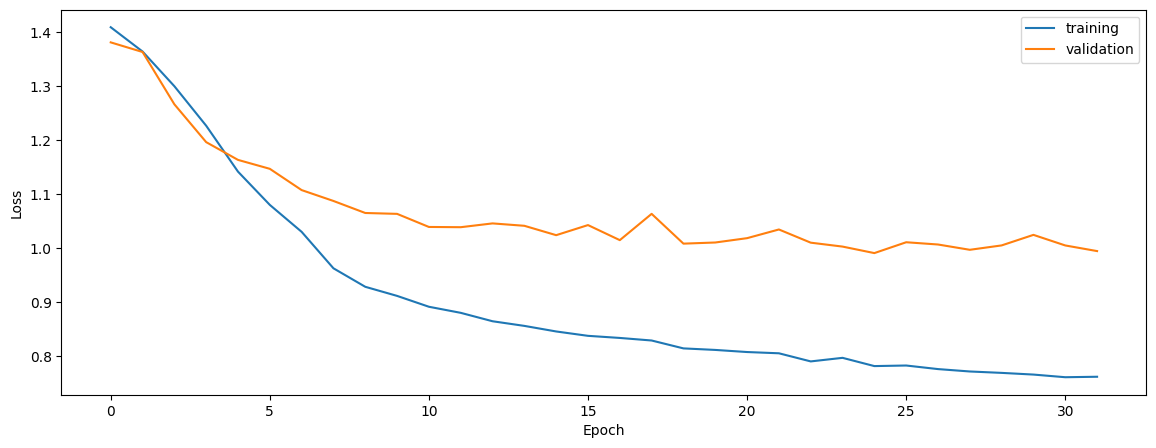

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6903281509261021
0.6169662856814657
0.6842129512313114


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6903281509261021
0.6169662856814657
0.6842129512313114


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6865516489780863
0.6143548846482484
0.6875714830346931


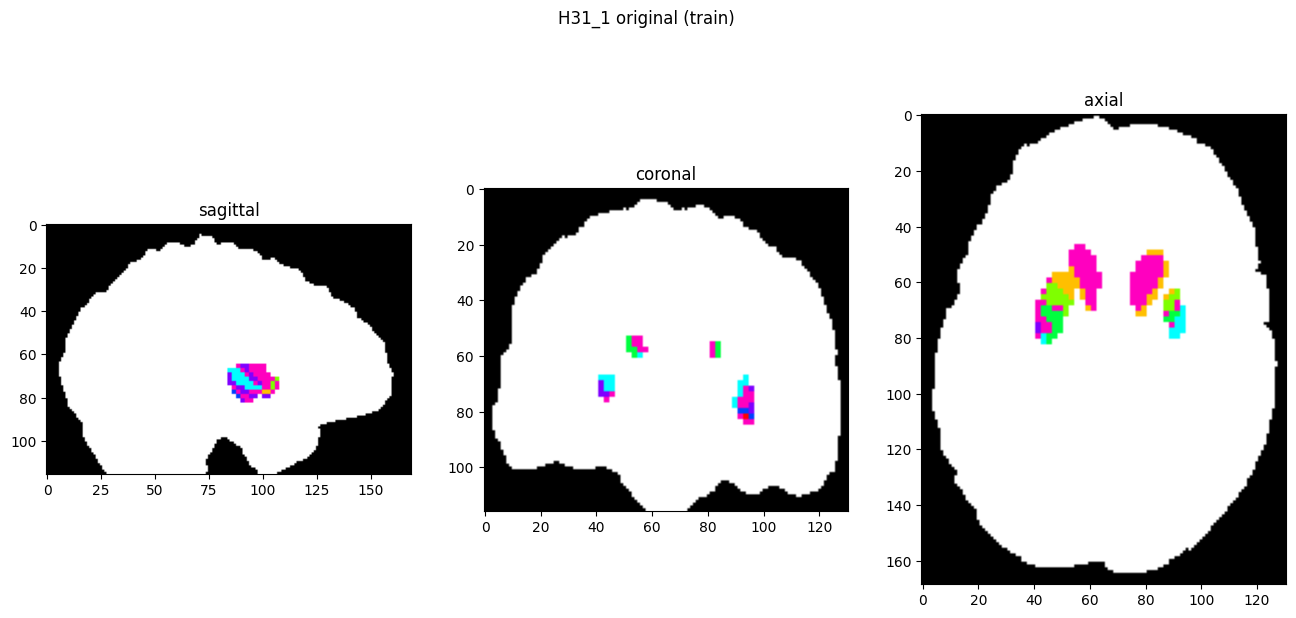

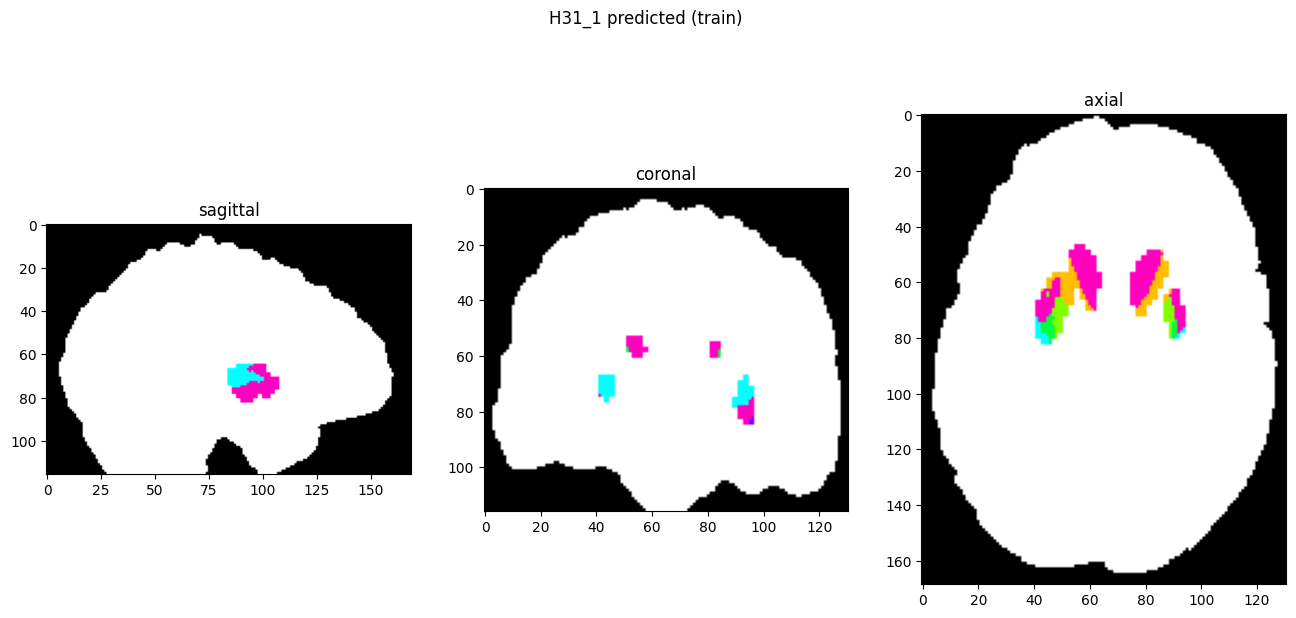

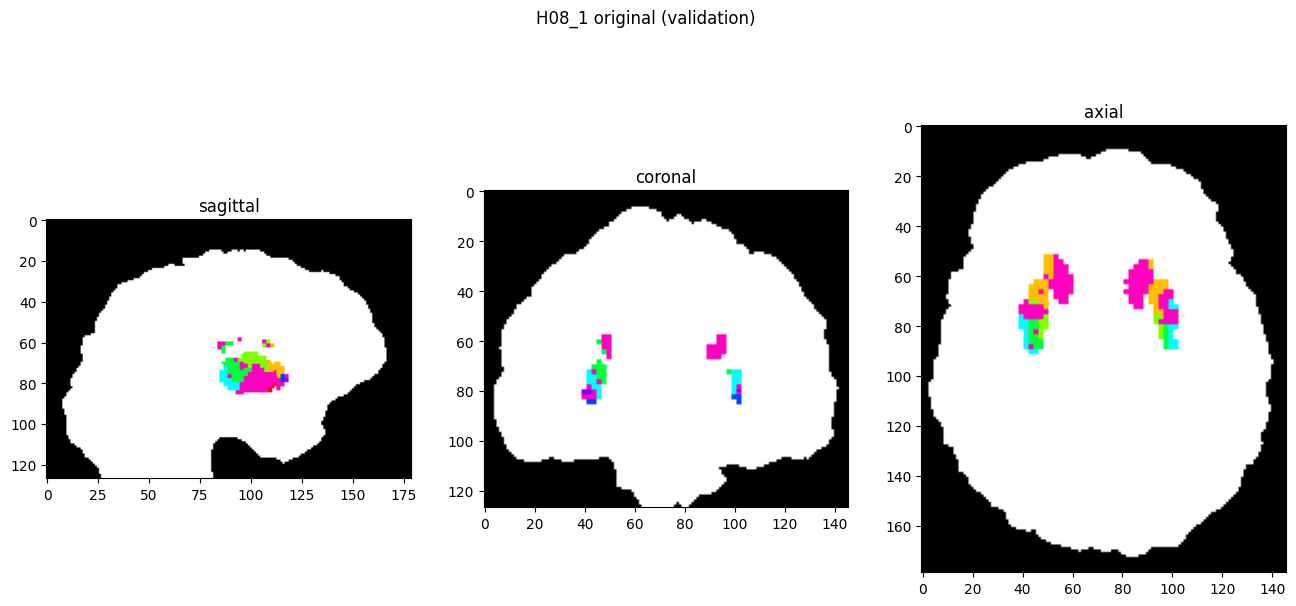

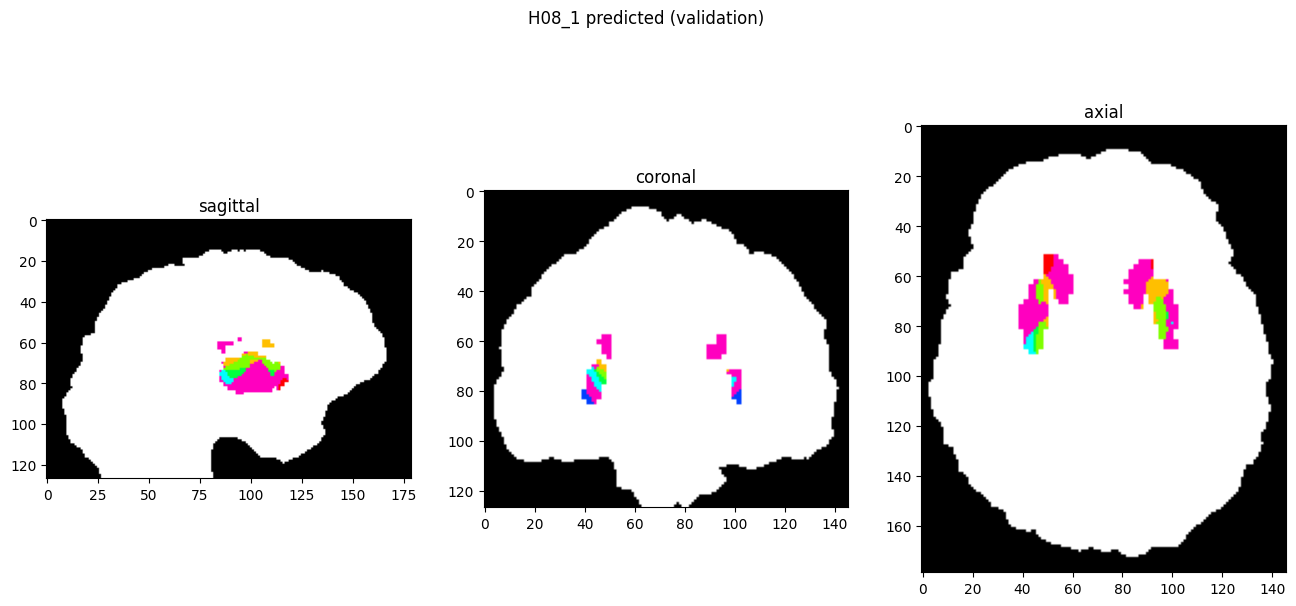

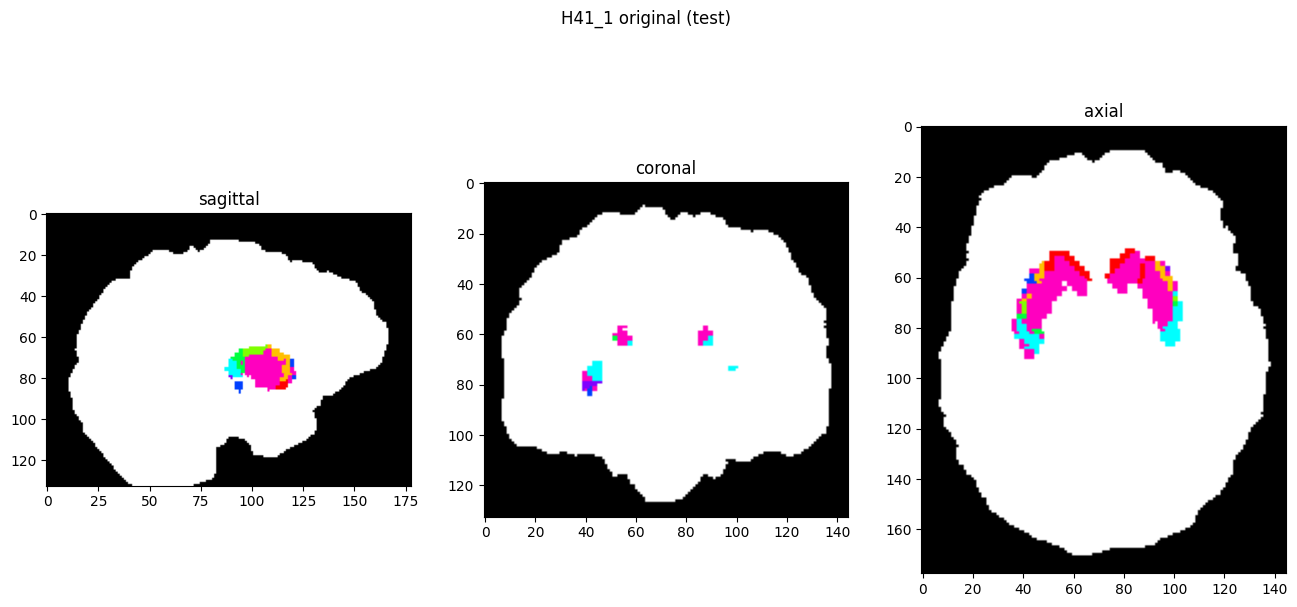

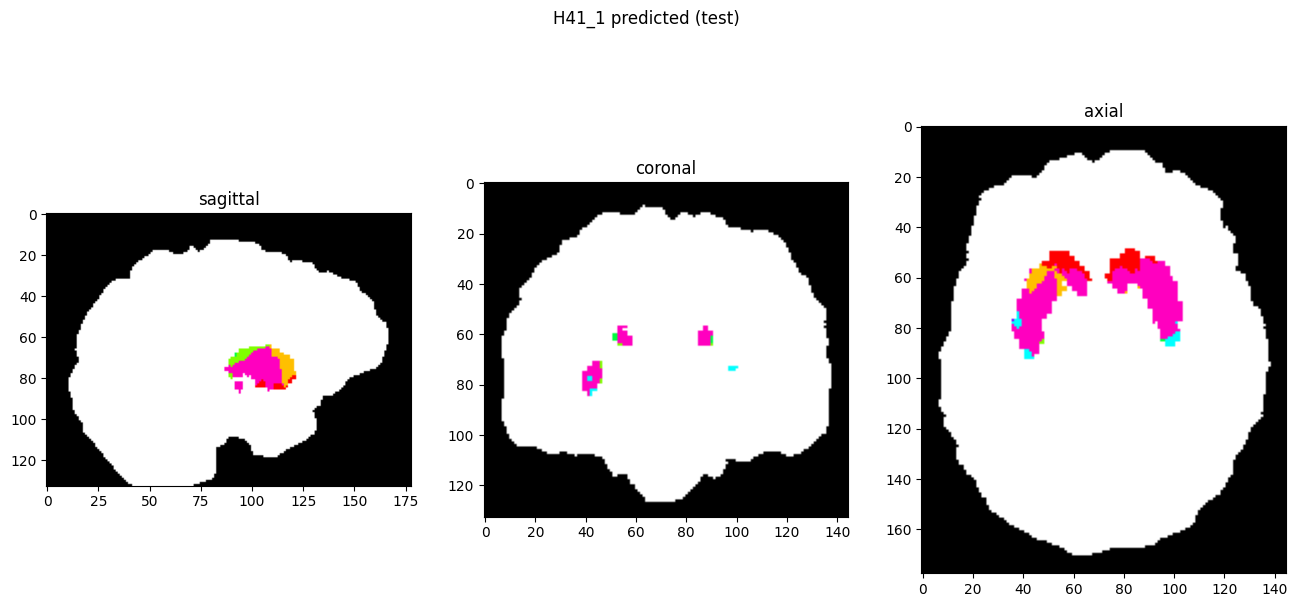

In [10]:
showResults(model, gen, threshold=0)